In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_mse"
ood = "0"

In [3]:
# Parameters
ood = 2


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 274157 images
Dataset type val label type: species


Loaded 35900 images
Dataset type test label type: species


Loaded 36128 images
Dataset type train label type: species


Loaded 101286 images
Dataset type val label type: species


Loaded 12662 images
Dataset type test label type: species


Loaded 12662 images


In [6]:
# model ids
model_ids = {"0": '3qdutcy1', "1": 'czgx4bod', "2": '72y7x1fk', "3": 'cqp59iho', "4": 'fwur6c78'}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

2 72y7x1fk


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                                | 0/4284 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/4284 [00:00<57:33,  1.24it/s]

  0%|                                                                                                        | 3/4284 [00:00<18:35,  3.84it/s]

  0%|                                                                                                        | 5/4284 [00:01<11:04,  6.44it/s]

  0%|▏                                                                                                       | 7/4284 [00:01<08:03,  8.85it/s]

  0%|▏                                                                                                       | 9/4284 [00:01<06:31, 10.93it/s]

  0%|▎                                                                                                      | 11/4284 [00:01<05:36, 12.71it/s]

  0%|▎                                                                                                      | 13/4284 [00:01<05:01, 14.16it/s]

  0%|▎                                                                                                      | 15/4284 [00:01<04:39, 15.26it/s]

  0%|▍                                                                                                      | 17/4284 [00:01<04:24, 16.16it/s]

  0%|▍                                                                                                      | 19/4284 [00:01<04:14, 16.76it/s]

  0%|▌                                                                                                      | 21/4284 [00:01<04:07, 17.20it/s]

  1%|▌                                                                                                      | 23/4284 [00:02<04:03, 17.51it/s]

  1%|▌                                                                                                      | 25/4284 [00:02<04:00, 17.72it/s]

  1%|▋                                                                                                      | 27/4284 [00:02<03:57, 17.92it/s]

  1%|▋                                                                                                      | 29/4284 [00:02<03:56, 18.02it/s]

  1%|▋                                                                                                      | 31/4284 [00:02<03:54, 18.11it/s]

  1%|▊                                                                                                      | 33/4284 [00:02<03:54, 18.15it/s]

  1%|▊                                                                                                      | 35/4284 [00:02<03:54, 18.15it/s]

  1%|▉                                                                                                      | 37/4284 [00:02<03:53, 18.18it/s]

  1%|▉                                                                                                      | 39/4284 [00:02<03:52, 18.22it/s]

  1%|▉                                                                                                      | 41/4284 [00:03<03:52, 18.25it/s]

  1%|█                                                                                                      | 43/4284 [00:03<03:52, 18.27it/s]

  1%|█                                                                                                      | 45/4284 [00:03<03:51, 18.30it/s]

  1%|█▏                                                                                                     | 47/4284 [00:03<03:51, 18.28it/s]

  1%|█▏                                                                                                     | 49/4284 [00:03<03:51, 18.27it/s]

  1%|█▏                                                                                                     | 51/4284 [00:03<03:51, 18.27it/s]

  1%|█▎                                                                                                     | 53/4284 [00:03<03:51, 18.29it/s]

  1%|█▎                                                                                                     | 55/4284 [00:03<03:51, 18.26it/s]

  1%|█▎                                                                                                     | 57/4284 [00:03<03:51, 18.30it/s]

  1%|█▍                                                                                                     | 59/4284 [00:04<03:51, 18.28it/s]

  1%|█▍                                                                                                     | 61/4284 [00:04<03:50, 18.28it/s]

  1%|█▌                                                                                                     | 63/4284 [00:04<03:50, 18.28it/s]

  2%|█▌                                                                                                     | 65/4284 [00:04<03:49, 18.35it/s]

  2%|█▌                                                                                                     | 67/4284 [00:04<03:49, 18.34it/s]

  2%|█▋                                                                                                     | 69/4284 [00:04<03:49, 18.33it/s]

  2%|█▋                                                                                                     | 71/4284 [00:04<03:49, 18.34it/s]

  2%|█▊                                                                                                     | 73/4284 [00:04<03:49, 18.33it/s]

  2%|█▊                                                                                                     | 75/4284 [00:04<03:48, 18.40it/s]

  2%|█▊                                                                                                     | 77/4284 [00:04<03:49, 18.34it/s]

  2%|█▉                                                                                                     | 79/4284 [00:05<03:49, 18.32it/s]

  2%|█▉                                                                                                     | 81/4284 [00:05<03:49, 18.28it/s]

  2%|█▉                                                                                                     | 83/4284 [00:05<03:49, 18.29it/s]

  2%|██                                                                                                     | 85/4284 [00:05<03:49, 18.30it/s]

  2%|██                                                                                                     | 87/4284 [00:05<03:49, 18.29it/s]

  2%|██▏                                                                                                    | 89/4284 [00:05<03:49, 18.29it/s]

  2%|██▏                                                                                                    | 91/4284 [00:05<03:49, 18.29it/s]

  2%|██▏                                                                                                    | 93/4284 [00:05<03:49, 18.28it/s]

  2%|██▎                                                                                                    | 95/4284 [00:05<03:48, 18.31it/s]

  2%|██▎                                                                                                    | 97/4284 [00:06<03:48, 18.35it/s]

  2%|██▍                                                                                                    | 99/4284 [00:06<03:48, 18.33it/s]

  2%|██▍                                                                                                   | 101/4284 [00:06<03:48, 18.32it/s]

  2%|██▍                                                                                                   | 103/4284 [00:06<03:48, 18.31it/s]

  2%|██▌                                                                                                   | 105/4284 [00:06<03:48, 18.27it/s]

  2%|██▌                                                                                                   | 107/4284 [00:06<03:48, 18.27it/s]

  3%|██▌                                                                                                   | 109/4284 [00:06<03:48, 18.28it/s]

  3%|██▋                                                                                                   | 111/4284 [00:06<03:48, 18.28it/s]

  3%|██▋                                                                                                   | 113/4284 [00:06<03:48, 18.29it/s]

  3%|██▋                                                                                                   | 115/4284 [00:07<03:48, 18.27it/s]

  3%|██▊                                                                                                   | 117/4284 [00:07<03:48, 18.25it/s]

  3%|██▊                                                                                                   | 119/4284 [00:07<03:48, 18.20it/s]

  3%|██▉                                                                                                   | 121/4284 [00:07<03:48, 18.21it/s]

  3%|██▉                                                                                                   | 123/4284 [00:07<03:48, 18.21it/s]

  3%|██▉                                                                                                   | 125/4284 [00:07<03:48, 18.24it/s]

  3%|███                                                                                                   | 127/4284 [00:07<03:47, 18.26it/s]

  3%|███                                                                                                   | 129/4284 [00:07<03:47, 18.26it/s]

  3%|███                                                                                                   | 131/4284 [00:07<03:47, 18.28it/s]

  3%|███▏                                                                                                  | 133/4284 [00:08<03:47, 18.27it/s]

  3%|███▏                                                                                                  | 135/4284 [00:08<03:46, 18.29it/s]

  3%|███▎                                                                                                  | 137/4284 [00:08<03:46, 18.31it/s]

  3%|███▎                                                                                                  | 139/4284 [00:08<03:46, 18.32it/s]

  3%|███▎                                                                                                  | 141/4284 [00:08<03:46, 18.32it/s]

  3%|███▍                                                                                                  | 143/4284 [00:08<03:46, 18.29it/s]

  3%|███▍                                                                                                  | 145/4284 [00:08<03:46, 18.29it/s]

  3%|███▌                                                                                                  | 147/4284 [00:08<03:45, 18.32it/s]

  3%|███▌                                                                                                  | 149/4284 [00:08<03:45, 18.31it/s]

  4%|███▌                                                                                                  | 151/4284 [00:09<03:46, 18.28it/s]

  4%|███▋                                                                                                  | 153/4284 [00:09<03:46, 18.27it/s]

  4%|███▋                                                                                                  | 155/4284 [00:09<03:46, 18.23it/s]

  4%|███▋                                                                                                  | 157/4284 [00:09<03:46, 18.24it/s]

  4%|███▊                                                                                                  | 159/4284 [00:09<03:46, 18.25it/s]

  4%|███▊                                                                                                  | 161/4284 [00:09<03:46, 18.23it/s]

  4%|███▉                                                                                                  | 163/4284 [00:09<03:46, 18.22it/s]

  4%|███▉                                                                                                  | 165/4284 [00:09<03:45, 18.25it/s]

  4%|███▉                                                                                                  | 167/4284 [00:09<03:45, 18.27it/s]

  4%|████                                                                                                  | 169/4284 [00:10<03:45, 18.28it/s]

  4%|████                                                                                                  | 171/4284 [00:10<03:44, 18.28it/s]

  4%|████                                                                                                  | 173/4284 [00:10<03:45, 18.25it/s]

  4%|████▏                                                                                                 | 175/4284 [00:10<03:44, 18.27it/s]

  4%|████▏                                                                                                 | 177/4284 [00:10<03:44, 18.29it/s]

  4%|████▎                                                                                                 | 179/4284 [00:10<03:43, 18.33it/s]

  4%|████▎                                                                                                 | 181/4284 [00:10<03:43, 18.32it/s]

  4%|████▎                                                                                                 | 183/4284 [00:10<03:44, 18.30it/s]

  4%|████▍                                                                                                 | 185/4284 [00:10<03:44, 18.29it/s]

  4%|████▍                                                                                                 | 187/4284 [00:11<03:43, 18.31it/s]

  4%|████▌                                                                                                 | 189/4284 [00:11<03:43, 18.32it/s]

  4%|████▌                                                                                                 | 191/4284 [00:11<03:43, 18.29it/s]

  5%|████▌                                                                                                 | 193/4284 [00:11<03:43, 18.28it/s]

  5%|████▋                                                                                                 | 195/4284 [00:11<03:44, 18.24it/s]

  5%|████▋                                                                                                 | 197/4284 [00:11<03:44, 18.23it/s]

  5%|████▋                                                                                                 | 199/4284 [00:11<03:44, 18.23it/s]

  5%|████▊                                                                                                 | 201/4284 [00:11<03:43, 18.23it/s]

  5%|████▊                                                                                                 | 203/4284 [00:11<03:43, 18.22it/s]

  5%|████▉                                                                                                 | 205/4284 [00:11<03:43, 18.28it/s]

  5%|████▉                                                                                                 | 207/4284 [00:12<03:43, 18.28it/s]

  5%|████▉                                                                                                 | 209/4284 [00:12<03:43, 18.27it/s]

  5%|█████                                                                                                 | 211/4284 [00:12<03:42, 18.30it/s]

  5%|█████                                                                                                 | 213/4284 [00:12<03:42, 18.28it/s]

  5%|█████                                                                                                 | 215/4284 [00:12<03:42, 18.30it/s]

  5%|█████▏                                                                                                | 217/4284 [00:12<03:41, 18.35it/s]

  5%|█████▏                                                                                                | 219/4284 [00:12<03:41, 18.33it/s]

  5%|█████▎                                                                                                | 221/4284 [00:12<03:41, 18.32it/s]

  5%|█████▎                                                                                                | 223/4284 [00:12<03:41, 18.31it/s]

  5%|█████▎                                                                                                | 225/4284 [00:13<03:41, 18.30it/s]

  5%|█████▍                                                                                                | 227/4284 [00:13<03:41, 18.31it/s]

  5%|█████▍                                                                                                | 229/4284 [00:13<03:41, 18.31it/s]

  5%|█████▌                                                                                                | 231/4284 [00:13<03:41, 18.29it/s]

  5%|█████▌                                                                                                | 233/4284 [00:13<03:41, 18.33it/s]

  5%|█████▌                                                                                                | 235/4284 [00:13<03:41, 18.30it/s]

  6%|█████▋                                                                                                | 237/4284 [00:13<03:41, 18.27it/s]

  6%|█████▋                                                                                                | 239/4284 [00:13<03:41, 18.24it/s]

  6%|█████▋                                                                                                | 241/4284 [00:13<03:41, 18.25it/s]

  6%|█████▊                                                                                                | 243/4284 [00:14<03:41, 18.25it/s]

  6%|█████▊                                                                                                | 245/4284 [00:14<03:41, 18.24it/s]

  6%|█████▉                                                                                                | 247/4284 [00:14<03:41, 18.26it/s]

  6%|█████▉                                                                                                | 249/4284 [00:14<03:41, 18.25it/s]

  6%|█████▉                                                                                                | 251/4284 [00:14<03:40, 18.26it/s]

  6%|██████                                                                                                | 253/4284 [00:14<03:40, 18.25it/s]

  6%|██████                                                                                                | 255/4284 [00:14<03:40, 18.27it/s]

  6%|██████                                                                                                | 257/4284 [00:14<03:39, 18.32it/s]

  6%|██████▏                                                                                               | 259/4284 [00:14<03:39, 18.32it/s]

  6%|██████▏                                                                                               | 261/4284 [00:15<03:40, 18.28it/s]

  6%|██████▎                                                                                               | 263/4284 [00:15<03:39, 18.28it/s]

  6%|██████▎                                                                                               | 265/4284 [00:15<03:39, 18.30it/s]

  6%|██████▎                                                                                               | 267/4284 [00:15<03:39, 18.30it/s]

  6%|██████▍                                                                                               | 269/4284 [00:15<03:39, 18.33it/s]

  6%|██████▍                                                                                               | 271/4284 [00:15<03:38, 18.34it/s]

  6%|██████▌                                                                                               | 273/4284 [00:15<03:38, 18.32it/s]

  6%|██████▌                                                                                               | 275/4284 [00:15<03:38, 18.35it/s]

  6%|██████▌                                                                                               | 277/4284 [00:15<03:38, 18.33it/s]

  7%|██████▋                                                                                               | 279/4284 [00:16<03:37, 18.38it/s]

  7%|██████▋                                                                                               | 281/4284 [00:16<03:38, 18.36it/s]

  7%|██████▋                                                                                               | 283/4284 [00:16<03:37, 18.36it/s]

  7%|██████▊                                                                                               | 285/4284 [00:16<03:37, 18.39it/s]

  7%|██████▊                                                                                               | 287/4284 [00:16<03:36, 18.43it/s]

  7%|██████▉                                                                                               | 289/4284 [00:16<03:37, 18.41it/s]

  7%|██████▉                                                                                               | 291/4284 [00:16<03:37, 18.38it/s]

  7%|██████▉                                                                                               | 293/4284 [00:16<03:37, 18.38it/s]

  7%|███████                                                                                               | 295/4284 [00:16<03:37, 18.37it/s]

  7%|███████                                                                                               | 297/4284 [00:17<03:37, 18.35it/s]

  7%|███████                                                                                               | 299/4284 [00:17<03:37, 18.33it/s]

  7%|███████▏                                                                                              | 301/4284 [00:17<03:37, 18.34it/s]

  7%|███████▏                                                                                              | 303/4284 [00:17<03:37, 18.30it/s]

  7%|███████▎                                                                                              | 305/4284 [00:17<03:37, 18.28it/s]

  7%|███████▎                                                                                              | 307/4284 [00:17<03:37, 18.29it/s]

  7%|███████▎                                                                                              | 309/4284 [00:17<03:37, 18.29it/s]

  7%|███████▍                                                                                              | 311/4284 [00:17<03:37, 18.31it/s]

  7%|███████▍                                                                                              | 313/4284 [00:17<03:37, 18.28it/s]

  7%|███████▌                                                                                              | 315/4284 [00:18<03:37, 18.29it/s]

  7%|███████▌                                                                                              | 317/4284 [00:18<03:37, 18.26it/s]

  7%|███████▌                                                                                              | 319/4284 [00:18<03:36, 18.33it/s]

  7%|███████▋                                                                                              | 321/4284 [00:18<03:36, 18.34it/s]

  8%|███████▋                                                                                              | 323/4284 [00:18<03:36, 18.32it/s]

  8%|███████▋                                                                                              | 325/4284 [00:18<03:36, 18.30it/s]

  8%|███████▊                                                                                              | 327/4284 [00:18<03:36, 18.31it/s]

  8%|███████▊                                                                                              | 329/4284 [00:18<03:36, 18.25it/s]

  8%|███████▉                                                                                              | 331/4284 [00:18<03:36, 18.23it/s]

  8%|███████▉                                                                                              | 333/4284 [00:18<03:36, 18.24it/s]

  8%|███████▉                                                                                              | 335/4284 [00:19<03:36, 18.27it/s]

  8%|████████                                                                                              | 337/4284 [00:19<03:36, 18.27it/s]

  8%|████████                                                                                              | 339/4284 [00:19<03:35, 18.27it/s]

  8%|████████                                                                                              | 341/4284 [00:19<03:35, 18.27it/s]

  8%|████████▏                                                                                             | 343/4284 [00:19<03:35, 18.27it/s]

  8%|████████▏                                                                                             | 345/4284 [00:19<03:35, 18.32it/s]

  8%|████████▎                                                                                             | 347/4284 [00:19<03:35, 18.29it/s]

  8%|████████▎                                                                                             | 349/4284 [00:19<03:34, 18.32it/s]

  8%|████████▎                                                                                             | 351/4284 [00:19<03:34, 18.30it/s]

  8%|████████▍                                                                                             | 353/4284 [00:20<03:35, 18.28it/s]

  8%|████████▍                                                                                             | 355/4284 [00:20<03:34, 18.29it/s]

  8%|████████▌                                                                                             | 357/4284 [00:20<03:34, 18.30it/s]

  8%|████████▌                                                                                             | 359/4284 [00:20<03:34, 18.33it/s]

  8%|████████▌                                                                                             | 361/4284 [00:20<03:33, 18.35it/s]

  8%|████████▋                                                                                             | 363/4284 [00:20<03:33, 18.32it/s]

  9%|████████▋                                                                                             | 365/4284 [00:20<03:33, 18.35it/s]

  9%|████████▋                                                                                             | 367/4284 [00:20<03:33, 18.37it/s]

  9%|████████▊                                                                                             | 369/4284 [00:20<03:32, 18.39it/s]

  9%|████████▊                                                                                             | 371/4284 [00:21<03:33, 18.36it/s]

  9%|████████▉                                                                                             | 373/4284 [00:21<03:33, 18.36it/s]

  9%|████████▉                                                                                             | 375/4284 [00:21<03:32, 18.36it/s]

  9%|████████▉                                                                                             | 377/4284 [00:21<03:32, 18.35it/s]

  9%|█████████                                                                                             | 379/4284 [00:21<03:32, 18.35it/s]

  9%|█████████                                                                                             | 381/4284 [00:21<03:32, 18.34it/s]

  9%|█████████                                                                                             | 383/4284 [00:21<03:32, 18.35it/s]

  9%|█████████▏                                                                                            | 385/4284 [00:21<03:32, 18.31it/s]

  9%|█████████▏                                                                                            | 387/4284 [00:21<03:32, 18.33it/s]

  9%|█████████▎                                                                                            | 389/4284 [00:22<03:32, 18.37it/s]

  9%|█████████▎                                                                                            | 391/4284 [00:22<03:32, 18.35it/s]

  9%|█████████▎                                                                                            | 393/4284 [00:22<03:31, 18.37it/s]

  9%|█████████▍                                                                                            | 395/4284 [00:22<03:31, 18.37it/s]

  9%|█████████▍                                                                                            | 397/4284 [00:22<03:31, 18.34it/s]

  9%|█████████▌                                                                                            | 399/4284 [00:22<03:31, 18.33it/s]

  9%|█████████▌                                                                                            | 401/4284 [00:22<03:31, 18.34it/s]

  9%|█████████▌                                                                                            | 403/4284 [00:22<03:32, 18.30it/s]

  9%|█████████▋                                                                                            | 405/4284 [00:22<03:32, 18.29it/s]

 10%|█████████▋                                                                                            | 407/4284 [00:23<03:32, 18.27it/s]

 10%|█████████▋                                                                                            | 409/4284 [00:23<03:31, 18.34it/s]

 10%|█████████▊                                                                                            | 411/4284 [00:23<03:30, 18.36it/s]

 10%|█████████▊                                                                                            | 413/4284 [00:23<03:34, 18.05it/s]

 10%|█████████▉                                                                                            | 415/4284 [00:23<03:33, 18.13it/s]

 10%|█████████▉                                                                                            | 417/4284 [00:23<03:32, 18.22it/s]

 10%|█████████▉                                                                                            | 419/4284 [00:23<03:31, 18.25it/s]

 10%|██████████                                                                                            | 421/4284 [00:23<03:31, 18.26it/s]

 10%|██████████                                                                                            | 423/4284 [00:23<03:31, 18.25it/s]

 10%|██████████                                                                                            | 425/4284 [00:24<03:30, 18.30it/s]

 10%|██████████▏                                                                                           | 427/4284 [00:24<03:31, 18.27it/s]

 10%|██████████▏                                                                                           | 429/4284 [00:24<03:31, 18.27it/s]

 10%|██████████▎                                                                                           | 431/4284 [00:24<03:30, 18.28it/s]

 10%|██████████▎                                                                                           | 433/4284 [00:24<03:30, 18.31it/s]

 10%|██████████▎                                                                                           | 435/4284 [00:24<03:29, 18.34it/s]

 10%|██████████▍                                                                                           | 437/4284 [00:24<03:29, 18.33it/s]

 10%|██████████▍                                                                                           | 439/4284 [00:24<03:30, 18.31it/s]

 10%|██████████▌                                                                                           | 441/4284 [00:24<03:29, 18.37it/s]

 10%|██████████▌                                                                                           | 443/4284 [00:24<03:29, 18.35it/s]

 10%|██████████▌                                                                                           | 445/4284 [00:25<03:29, 18.32it/s]

 10%|██████████▋                                                                                           | 447/4284 [00:25<03:28, 18.36it/s]

 10%|██████████▋                                                                                           | 449/4284 [00:25<03:29, 18.35it/s]

 11%|██████████▋                                                                                           | 451/4284 [00:25<03:29, 18.33it/s]

 11%|██████████▊                                                                                           | 453/4284 [00:25<03:29, 18.29it/s]

 11%|██████████▊                                                                                           | 455/4284 [00:25<03:29, 18.28it/s]

 11%|██████████▉                                                                                           | 457/4284 [00:25<03:28, 18.31it/s]

 11%|██████████▉                                                                                           | 459/4284 [00:25<03:28, 18.33it/s]

 11%|██████████▉                                                                                           | 461/4284 [00:25<03:28, 18.32it/s]

 11%|███████████                                                                                           | 463/4284 [00:26<03:28, 18.33it/s]

 11%|███████████                                                                                           | 465/4284 [00:26<03:28, 18.30it/s]

 11%|███████████                                                                                           | 467/4284 [00:26<03:28, 18.31it/s]

 11%|███████████▏                                                                                          | 469/4284 [00:26<03:28, 18.31it/s]

 11%|███████████▏                                                                                          | 471/4284 [00:26<03:27, 18.35it/s]

 11%|███████████▎                                                                                          | 473/4284 [00:26<03:27, 18.35it/s]

 11%|███████████▎                                                                                          | 475/4284 [00:26<03:27, 18.33it/s]

 11%|███████████▎                                                                                          | 477/4284 [00:26<03:27, 18.31it/s]

 11%|███████████▍                                                                                          | 479/4284 [00:26<03:28, 18.25it/s]

 11%|███████████▍                                                                                          | 481/4284 [00:27<03:28, 18.24it/s]

 11%|███████████▌                                                                                          | 483/4284 [00:27<03:28, 18.25it/s]

 11%|███████████▌                                                                                          | 485/4284 [00:27<03:28, 18.26it/s]

 11%|███████████▌                                                                                          | 487/4284 [00:27<03:28, 18.25it/s]

 11%|███████████▋                                                                                          | 489/4284 [00:27<03:27, 18.26it/s]

 11%|███████████▋                                                                                          | 491/4284 [00:27<03:27, 18.26it/s]

 12%|███████████▋                                                                                          | 493/4284 [00:27<03:27, 18.23it/s]

 12%|███████████▊                                                                                          | 495/4284 [00:27<03:27, 18.23it/s]

 12%|███████████▊                                                                                          | 497/4284 [00:27<03:28, 18.20it/s]

 12%|███████████▉                                                                                          | 499/4284 [00:28<03:27, 18.22it/s]

 12%|███████████▉                                                                                          | 501/4284 [00:28<03:27, 18.21it/s]

 12%|███████████▉                                                                                          | 503/4284 [00:28<03:27, 18.23it/s]

 12%|████████████                                                                                          | 505/4284 [00:28<03:27, 18.24it/s]

 12%|████████████                                                                                          | 507/4284 [00:28<03:26, 18.26it/s]

 12%|████████████                                                                                          | 509/4284 [00:28<03:26, 18.31it/s]

 12%|████████████▏                                                                                         | 511/4284 [00:28<03:26, 18.29it/s]

 12%|████████████▏                                                                                         | 513/4284 [00:28<03:26, 18.30it/s]

 12%|████████████▎                                                                                         | 515/4284 [00:28<03:26, 18.25it/s]

 12%|████████████▎                                                                                         | 517/4284 [00:29<03:26, 18.27it/s]

 12%|████████████▎                                                                                         | 519/4284 [00:29<03:25, 18.29it/s]

 12%|████████████▍                                                                                         | 521/4284 [00:29<03:25, 18.29it/s]

 12%|████████████▍                                                                                         | 523/4284 [00:29<03:26, 18.25it/s]

 12%|████████████▌                                                                                         | 525/4284 [00:29<03:25, 18.26it/s]

 12%|████████████▌                                                                                         | 527/4284 [00:29<03:25, 18.30it/s]

 12%|████████████▌                                                                                         | 529/4284 [00:29<03:25, 18.29it/s]

 12%|████████████▋                                                                                         | 531/4284 [00:29<03:24, 18.32it/s]

 12%|████████████▋                                                                                         | 533/4284 [00:29<03:24, 18.32it/s]

 12%|████████████▋                                                                                         | 535/4284 [00:30<03:24, 18.29it/s]

 13%|████████████▊                                                                                         | 537/4284 [00:30<03:25, 18.23it/s]

 13%|████████████▊                                                                                         | 539/4284 [00:30<03:25, 18.23it/s]

 13%|████████████▉                                                                                         | 541/4284 [00:30<03:24, 18.27it/s]

 13%|████████████▉                                                                                         | 543/4284 [00:30<03:24, 18.27it/s]

 13%|████████████▉                                                                                         | 545/4284 [00:30<03:24, 18.29it/s]

 13%|█████████████                                                                                         | 547/4284 [00:30<03:24, 18.29it/s]

 13%|█████████████                                                                                         | 549/4284 [00:30<03:24, 18.27it/s]

 13%|█████████████                                                                                         | 551/4284 [00:30<03:24, 18.27it/s]

 13%|█████████████▏                                                                                        | 553/4284 [00:31<03:23, 18.30it/s]

 13%|█████████████▏                                                                                        | 555/4284 [00:31<03:23, 18.32it/s]

 13%|█████████████▎                                                                                        | 557/4284 [00:31<03:23, 18.29it/s]

 13%|█████████████▎                                                                                        | 559/4284 [00:31<03:23, 18.29it/s]

 13%|█████████████▎                                                                                        | 561/4284 [00:31<03:23, 18.27it/s]

 13%|█████████████▍                                                                                        | 563/4284 [00:31<03:23, 18.29it/s]

 13%|█████████████▍                                                                                        | 565/4284 [00:31<03:22, 18.35it/s]

 13%|█████████████▌                                                                                        | 567/4284 [00:31<03:22, 18.33it/s]

 13%|█████████████▌                                                                                        | 569/4284 [00:31<03:22, 18.33it/s]

 13%|█████████████▌                                                                                        | 571/4284 [00:31<03:22, 18.30it/s]

 13%|█████████████▋                                                                                        | 573/4284 [00:32<03:23, 18.27it/s]

 13%|█████████████▋                                                                                        | 575/4284 [00:32<03:23, 18.23it/s]

 13%|█████████████▋                                                                                        | 577/4284 [00:32<03:23, 18.25it/s]

 14%|█████████████▊                                                                                        | 579/4284 [00:32<03:22, 18.27it/s]

 14%|█████████████▊                                                                                        | 581/4284 [00:32<03:22, 18.28it/s]

 14%|█████████████▉                                                                                        | 583/4284 [00:32<03:22, 18.30it/s]

 14%|█████████████▉                                                                                        | 585/4284 [00:32<03:21, 18.32it/s]

 14%|█████████████▉                                                                                        | 587/4284 [00:32<03:21, 18.32it/s]

 14%|██████████████                                                                                        | 589/4284 [00:32<03:21, 18.37it/s]

 14%|██████████████                                                                                        | 591/4284 [00:33<03:21, 18.34it/s]

 14%|██████████████                                                                                        | 593/4284 [00:33<03:21, 18.33it/s]

 14%|██████████████▏                                                                                       | 595/4284 [00:33<03:21, 18.31it/s]

 14%|██████████████▏                                                                                       | 597/4284 [00:33<03:21, 18.27it/s]

 14%|██████████████▎                                                                                       | 599/4284 [00:33<03:21, 18.29it/s]

 14%|██████████████▎                                                                                       | 601/4284 [00:33<03:20, 18.35it/s]

 14%|██████████████▎                                                                                       | 603/4284 [00:33<03:20, 18.34it/s]

 14%|██████████████▍                                                                                       | 605/4284 [00:33<03:20, 18.32it/s]

 14%|██████████████▍                                                                                       | 607/4284 [00:33<03:20, 18.35it/s]

 14%|██████████████▌                                                                                       | 609/4284 [00:34<03:20, 18.34it/s]

 14%|██████████████▌                                                                                       | 611/4284 [00:34<03:20, 18.33it/s]

 14%|██████████████▌                                                                                       | 613/4284 [00:34<03:20, 18.32it/s]

 14%|██████████████▋                                                                                       | 615/4284 [00:34<03:20, 18.30it/s]

 14%|██████████████▋                                                                                       | 617/4284 [00:34<03:20, 18.30it/s]

 14%|██████████████▋                                                                                       | 619/4284 [00:34<03:20, 18.30it/s]

 14%|██████████████▊                                                                                       | 621/4284 [00:34<03:20, 18.30it/s]

 15%|██████████████▊                                                                                       | 623/4284 [00:34<03:20, 18.27it/s]

 15%|██████████████▉                                                                                       | 625/4284 [00:34<03:20, 18.29it/s]

 15%|██████████████▉                                                                                       | 627/4284 [00:35<03:19, 18.32it/s]

 15%|██████████████▉                                                                                       | 629/4284 [00:35<03:19, 18.30it/s]

 15%|███████████████                                                                                       | 631/4284 [00:35<03:19, 18.31it/s]

 15%|███████████████                                                                                       | 633/4284 [00:35<03:19, 18.30it/s]

 15%|███████████████                                                                                       | 635/4284 [00:35<03:19, 18.29it/s]

 15%|███████████████▏                                                                                      | 637/4284 [00:35<03:19, 18.30it/s]

 15%|███████████████▏                                                                                      | 639/4284 [00:35<03:19, 18.31it/s]

 15%|███████████████▎                                                                                      | 641/4284 [00:35<03:18, 18.31it/s]

 15%|███████████████▎                                                                                      | 643/4284 [00:35<03:20, 18.16it/s]

 15%|███████████████▎                                                                                      | 645/4284 [00:36<03:21, 18.06it/s]

 15%|███████████████▍                                                                                      | 647/4284 [00:36<03:21, 18.01it/s]

 15%|███████████████▍                                                                                      | 649/4284 [00:36<03:22, 17.94it/s]

 15%|███████████████▍                                                                                      | 651/4284 [00:36<03:22, 17.92it/s]

 15%|███████████████▌                                                                                      | 653/4284 [00:36<03:22, 17.89it/s]

 15%|███████████████▌                                                                                      | 655/4284 [00:36<03:23, 17.87it/s]

 15%|███████████████▋                                                                                      | 657/4284 [00:36<03:23, 17.81it/s]

 15%|███████████████▋                                                                                      | 659/4284 [00:36<03:22, 17.86it/s]

 15%|███████████████▋                                                                                      | 661/4284 [00:36<03:21, 17.96it/s]

 15%|███████████████▊                                                                                      | 663/4284 [00:37<03:20, 18.05it/s]

 16%|███████████████▊                                                                                      | 665/4284 [00:37<03:19, 18.16it/s]

 16%|███████████████▉                                                                                      | 667/4284 [00:37<03:19, 18.15it/s]

 16%|███████████████▉                                                                                      | 669/4284 [00:37<03:18, 18.17it/s]

 16%|███████████████▉                                                                                      | 671/4284 [00:37<03:18, 18.19it/s]

 16%|████████████████                                                                                      | 673/4284 [00:37<03:18, 18.22it/s]

 16%|████████████████                                                                                      | 675/4284 [00:37<03:18, 18.19it/s]

 16%|████████████████                                                                                      | 677/4284 [00:37<03:18, 18.21it/s]

 16%|████████████████▏                                                                                     | 679/4284 [00:37<03:17, 18.23it/s]

 16%|████████████████▏                                                                                     | 681/4284 [00:38<03:17, 18.27it/s]

 16%|████████████████▎                                                                                     | 683/4284 [00:38<03:17, 18.27it/s]

 16%|████████████████▎                                                                                     | 685/4284 [00:38<03:16, 18.29it/s]

 16%|████████████████▎                                                                                     | 687/4284 [00:38<03:16, 18.29it/s]

 16%|████████████████▍                                                                                     | 689/4284 [00:38<03:16, 18.26it/s]

 16%|████████████████▍                                                                                     | 691/4284 [00:38<03:16, 18.24it/s]

 16%|████████████████▌                                                                                     | 693/4284 [00:38<03:16, 18.26it/s]

 16%|████████████████▌                                                                                     | 695/4284 [00:38<03:16, 18.28it/s]

 16%|████████████████▌                                                                                     | 697/4284 [00:38<03:15, 18.30it/s]

 16%|████████████████▋                                                                                     | 699/4284 [00:39<03:15, 18.30it/s]

 16%|████████████████▋                                                                                     | 701/4284 [00:39<03:15, 18.30it/s]

 16%|████████████████▋                                                                                     | 703/4284 [00:39<03:15, 18.33it/s]

 16%|████████████████▊                                                                                     | 705/4284 [00:39<03:15, 18.33it/s]

 17%|████████████████▊                                                                                     | 707/4284 [00:39<03:15, 18.29it/s]

 17%|████████████████▉                                                                                     | 709/4284 [00:39<03:15, 18.29it/s]

 17%|████████████████▉                                                                                     | 711/4284 [00:39<03:15, 18.32it/s]

 17%|████████████████▉                                                                                     | 713/4284 [00:39<03:15, 18.30it/s]

 17%|█████████████████                                                                                     | 715/4284 [00:39<03:15, 18.29it/s]

 17%|█████████████████                                                                                     | 717/4284 [00:40<03:15, 18.28it/s]

 17%|█████████████████                                                                                     | 719/4284 [00:40<03:14, 18.29it/s]

 17%|█████████████████▏                                                                                    | 721/4284 [00:40<03:14, 18.29it/s]

 17%|█████████████████▏                                                                                    | 723/4284 [00:40<03:14, 18.31it/s]

 17%|█████████████████▎                                                                                    | 725/4284 [00:40<03:14, 18.31it/s]

 17%|█████████████████▎                                                                                    | 727/4284 [00:40<03:14, 18.30it/s]

 17%|█████████████████▎                                                                                    | 729/4284 [00:40<03:13, 18.33it/s]

 17%|█████████████████▍                                                                                    | 731/4284 [00:40<03:13, 18.33it/s]

 17%|█████████████████▍                                                                                    | 733/4284 [00:40<03:13, 18.33it/s]

 17%|█████████████████▌                                                                                    | 735/4284 [00:40<03:13, 18.34it/s]

 17%|█████████████████▌                                                                                    | 737/4284 [00:41<03:13, 18.33it/s]

 17%|█████████████████▌                                                                                    | 739/4284 [00:41<03:13, 18.35it/s]

 17%|█████████████████▋                                                                                    | 741/4284 [00:41<03:12, 18.37it/s]

 17%|█████████████████▋                                                                                    | 743/4284 [00:41<03:13, 18.34it/s]

 17%|█████████████████▋                                                                                    | 745/4284 [00:41<03:13, 18.32it/s]

 17%|█████████████████▊                                                                                    | 747/4284 [00:41<03:13, 18.30it/s]

 17%|█████████████████▊                                                                                    | 749/4284 [00:41<03:12, 18.36it/s]

 18%|█████████████████▉                                                                                    | 751/4284 [00:41<03:12, 18.36it/s]

 18%|█████████████████▉                                                                                    | 753/4284 [00:41<03:12, 18.34it/s]

 18%|█████████████████▉                                                                                    | 755/4284 [00:42<03:12, 18.32it/s]

 18%|██████████████████                                                                                    | 757/4284 [00:42<03:12, 18.29it/s]

 18%|██████████████████                                                                                    | 759/4284 [00:42<03:12, 18.33it/s]

 18%|██████████████████                                                                                    | 761/4284 [00:42<03:12, 18.32it/s]

 18%|██████████████████▏                                                                                   | 763/4284 [00:42<03:12, 18.31it/s]

 18%|██████████████████▏                                                                                   | 765/4284 [00:42<03:12, 18.31it/s]

 18%|██████████████████▎                                                                                   | 767/4284 [00:42<03:12, 18.30it/s]

 18%|██████████████████▎                                                                                   | 769/4284 [00:42<03:12, 18.29it/s]

 18%|██████████████████▎                                                                                   | 771/4284 [00:42<03:11, 18.32it/s]

 18%|██████████████████▍                                                                                   | 773/4284 [00:43<03:11, 18.32it/s]

 18%|██████████████████▍                                                                                   | 775/4284 [00:43<03:11, 18.32it/s]

 18%|██████████████████▌                                                                                   | 777/4284 [00:43<03:11, 18.30it/s]

 18%|██████████████████▌                                                                                   | 779/4284 [00:43<03:11, 18.26it/s]

 18%|██████████████████▌                                                                                   | 781/4284 [00:43<03:11, 18.28it/s]

 18%|██████████████████▋                                                                                   | 783/4284 [00:43<03:11, 18.33it/s]

 18%|██████████████████▋                                                                                   | 785/4284 [00:43<03:11, 18.30it/s]

 18%|██████████████████▋                                                                                   | 787/4284 [00:43<03:11, 18.31it/s]

 18%|██████████████████▊                                                                                   | 789/4284 [00:43<03:11, 18.29it/s]

 18%|██████████████████▊                                                                                   | 791/4284 [00:44<03:10, 18.30it/s]

 19%|██████████████████▉                                                                                   | 793/4284 [00:44<03:10, 18.31it/s]

 19%|██████████████████▉                                                                                   | 795/4284 [00:44<03:10, 18.31it/s]

 19%|██████████████████▉                                                                                   | 797/4284 [00:44<03:10, 18.29it/s]

 19%|███████████████████                                                                                   | 799/4284 [00:44<03:10, 18.30it/s]

 19%|███████████████████                                                                                   | 801/4284 [00:44<03:10, 18.27it/s]

 19%|███████████████████                                                                                   | 803/4284 [00:44<03:11, 18.21it/s]

 19%|███████████████████▏                                                                                  | 805/4284 [00:44<03:10, 18.23it/s]

 19%|███████████████████▏                                                                                  | 807/4284 [00:44<03:10, 18.28it/s]

 19%|███████████████████▎                                                                                  | 809/4284 [00:45<03:10, 18.27it/s]

 19%|███████████████████▎                                                                                  | 811/4284 [00:45<03:10, 18.24it/s]

 19%|███████████████████▎                                                                                  | 813/4284 [00:45<03:10, 18.24it/s]

 19%|███████████████████▍                                                                                  | 815/4284 [00:45<03:10, 18.21it/s]

 19%|███████████████████▍                                                                                  | 817/4284 [00:45<03:10, 18.23it/s]

 19%|███████████████████▌                                                                                  | 819/4284 [00:45<03:10, 18.19it/s]

 19%|███████████████████▌                                                                                  | 821/4284 [00:45<03:10, 18.19it/s]

 19%|███████████████████▌                                                                                  | 823/4284 [00:45<03:09, 18.24it/s]

 19%|███████████████████▋                                                                                  | 825/4284 [00:45<03:09, 18.29it/s]

 19%|███████████████████▋                                                                                  | 827/4284 [00:46<03:09, 18.26it/s]

 19%|███████████████████▋                                                                                  | 829/4284 [00:46<03:09, 18.26it/s]

 19%|███████████████████▊                                                                                  | 831/4284 [00:46<03:09, 18.26it/s]

 19%|███████████████████▊                                                                                  | 833/4284 [00:46<03:09, 18.21it/s]

 19%|███████████████████▉                                                                                  | 835/4284 [00:46<03:09, 18.21it/s]

 20%|███████████████████▉                                                                                  | 837/4284 [00:46<03:09, 18.22it/s]

 20%|███████████████████▉                                                                                  | 839/4284 [00:46<03:08, 18.23it/s]

 20%|████████████████████                                                                                  | 841/4284 [00:46<03:08, 18.26it/s]

 20%|████████████████████                                                                                  | 843/4284 [00:46<03:08, 18.26it/s]

 20%|████████████████████                                                                                  | 845/4284 [00:47<03:08, 18.29it/s]

 20%|████████████████████▏                                                                                 | 847/4284 [00:47<03:07, 18.32it/s]

 20%|████████████████████▏                                                                                 | 849/4284 [00:47<03:07, 18.28it/s]

 20%|████████████████████▎                                                                                 | 851/4284 [00:47<03:07, 18.30it/s]

 20%|████████████████████▎                                                                                 | 853/4284 [00:47<03:07, 18.31it/s]

 20%|████████████████████▎                                                                                 | 855/4284 [00:47<03:07, 18.31it/s]

 20%|████████████████████▍                                                                                 | 857/4284 [00:47<03:07, 18.30it/s]

 20%|████████████████████▍                                                                                 | 859/4284 [00:47<03:06, 18.33it/s]

 20%|████████████████████▌                                                                                 | 861/4284 [00:47<03:06, 18.32it/s]

 20%|████████████████████▌                                                                                 | 863/4284 [00:47<03:06, 18.33it/s]

 20%|████████████████████▌                                                                                 | 865/4284 [00:48<03:06, 18.31it/s]

 20%|████████████████████▋                                                                                 | 867/4284 [00:48<03:06, 18.30it/s]

 20%|████████████████████▋                                                                                 | 869/4284 [00:48<03:06, 18.28it/s]

 20%|████████████████████▋                                                                                 | 871/4284 [00:48<03:06, 18.29it/s]

 20%|████████████████████▊                                                                                 | 873/4284 [00:48<03:06, 18.32it/s]

 20%|████████████████████▊                                                                                 | 875/4284 [00:48<03:05, 18.34it/s]

 20%|████████████████████▉                                                                                 | 877/4284 [00:48<03:05, 18.33it/s]

 21%|████████████████████▉                                                                                 | 879/4284 [00:48<03:06, 18.30it/s]

 21%|████████████████████▉                                                                                 | 881/4284 [00:48<03:06, 18.27it/s]

 21%|█████████████████████                                                                                 | 883/4284 [00:49<03:05, 18.31it/s]

 21%|█████████████████████                                                                                 | 885/4284 [00:49<03:05, 18.34it/s]

 21%|█████████████████████                                                                                 | 887/4284 [00:49<03:05, 18.32it/s]

 21%|█████████████████████▏                                                                                | 889/4284 [00:49<03:05, 18.32it/s]

 21%|█████████████████████▏                                                                                | 891/4284 [00:49<03:05, 18.31it/s]

 21%|█████████████████████▎                                                                                | 893/4284 [00:49<03:05, 18.29it/s]

 21%|█████████████████████▎                                                                                | 895/4284 [00:49<03:05, 18.28it/s]

 21%|█████████████████████▎                                                                                | 897/4284 [00:49<03:05, 18.30it/s]

 21%|█████████████████████▍                                                                                | 899/4284 [00:49<03:05, 18.27it/s]

 21%|█████████████████████▍                                                                                | 901/4284 [00:50<03:05, 18.24it/s]

 21%|█████████████████████▌                                                                                | 903/4284 [00:50<03:05, 18.27it/s]

 21%|█████████████████████▌                                                                                | 905/4284 [00:50<03:05, 18.25it/s]

 21%|█████████████████████▌                                                                                | 907/4284 [00:50<03:05, 18.24it/s]

 21%|█████████████████████▋                                                                                | 909/4284 [00:50<03:04, 18.27it/s]

 21%|█████████████████████▋                                                                                | 911/4284 [00:50<03:04, 18.32it/s]

 21%|█████████████████████▋                                                                                | 913/4284 [00:50<03:03, 18.32it/s]

 21%|█████████████████████▊                                                                                | 915/4284 [00:50<03:04, 18.30it/s]

 21%|█████████████████████▊                                                                                | 917/4284 [00:50<03:04, 18.26it/s]

 21%|█████████████████████▉                                                                                | 919/4284 [00:51<03:03, 18.31it/s]

 21%|█████████████████████▉                                                                                | 921/4284 [00:51<03:03, 18.28it/s]

 22%|█████████████████████▉                                                                                | 923/4284 [00:51<03:03, 18.31it/s]

 22%|██████████████████████                                                                                | 925/4284 [00:51<03:03, 18.32it/s]

 22%|██████████████████████                                                                                | 927/4284 [00:51<03:03, 18.32it/s]

 22%|██████████████████████                                                                                | 929/4284 [00:51<03:03, 18.32it/s]

 22%|██████████████████████▏                                                                               | 931/4284 [00:51<03:02, 18.37it/s]

 22%|██████████████████████▏                                                                               | 933/4284 [00:51<03:02, 18.36it/s]

 22%|██████████████████████▎                                                                               | 935/4284 [00:51<03:02, 18.32it/s]

 22%|██████████████████████▎                                                                               | 937/4284 [00:52<03:02, 18.30it/s]

 22%|██████████████████████▎                                                                               | 939/4284 [00:52<03:02, 18.29it/s]

 22%|██████████████████████▍                                                                               | 941/4284 [00:52<03:03, 18.26it/s]

 22%|██████████████████████▍                                                                               | 943/4284 [00:52<03:06, 17.96it/s]

 22%|██████████████████████▌                                                                               | 945/4284 [00:52<03:04, 18.07it/s]

 22%|██████████████████████▌                                                                               | 947/4284 [00:52<03:04, 18.09it/s]

 22%|██████████████████████▌                                                                               | 949/4284 [00:52<03:03, 18.18it/s]

 22%|██████████████████████▋                                                                               | 951/4284 [00:52<03:03, 18.21it/s]

 22%|██████████████████████▋                                                                               | 953/4284 [00:52<03:02, 18.28it/s]

 22%|██████████████████████▋                                                                               | 955/4284 [00:53<03:02, 18.24it/s]

 22%|██████████████████████▊                                                                               | 957/4284 [00:53<03:02, 18.23it/s]

 22%|██████████████████████▊                                                                               | 959/4284 [00:53<03:02, 18.26it/s]

 22%|██████████████████████▉                                                                               | 961/4284 [00:53<03:02, 18.24it/s]

 22%|██████████████████████▉                                                                               | 963/4284 [00:53<03:02, 18.23it/s]

 23%|██████████████████████▉                                                                               | 965/4284 [00:53<03:01, 18.26it/s]

 23%|███████████████████████                                                                               | 967/4284 [00:53<03:01, 18.27it/s]

 23%|███████████████████████                                                                               | 969/4284 [00:53<03:01, 18.26it/s]

 23%|███████████████████████                                                                               | 971/4284 [00:53<03:01, 18.22it/s]

 23%|███████████████████████▏                                                                              | 973/4284 [00:54<03:01, 18.22it/s]

 23%|███████████████████████▏                                                                              | 975/4284 [00:54<03:01, 18.25it/s]

 23%|███████████████████████▎                                                                              | 977/4284 [00:54<03:01, 18.27it/s]

 23%|███████████████████████▎                                                                              | 979/4284 [00:54<03:00, 18.26it/s]

 23%|███████████████████████▎                                                                              | 981/4284 [00:54<03:00, 18.26it/s]

 23%|███████████████████████▍                                                                              | 983/4284 [00:54<03:01, 18.24it/s]

 23%|███████████████████████▍                                                                              | 985/4284 [00:54<03:00, 18.25it/s]

 23%|███████████████████████▌                                                                              | 987/4284 [00:54<03:00, 18.22it/s]

 23%|███████████████████████▌                                                                              | 989/4284 [00:54<03:00, 18.24it/s]

 23%|███████████████████████▌                                                                              | 991/4284 [00:54<03:00, 18.23it/s]

 23%|███████████████████████▋                                                                              | 993/4284 [00:55<03:00, 18.24it/s]

 23%|███████████████████████▋                                                                              | 995/4284 [00:55<03:00, 18.20it/s]

 23%|███████████████████████▋                                                                              | 997/4284 [00:55<03:00, 18.22it/s]

 23%|███████████████████████▊                                                                              | 999/4284 [00:55<03:00, 18.21it/s]

 23%|███████████████████████▌                                                                             | 1001/4284 [00:55<03:00, 18.23it/s]

 23%|███████████████████████▋                                                                             | 1003/4284 [00:55<03:00, 18.22it/s]

 23%|███████████████████████▋                                                                             | 1005/4284 [00:55<02:59, 18.23it/s]

 24%|███████████████████████▋                                                                             | 1007/4284 [00:55<02:59, 18.24it/s]

 24%|███████████████████████▊                                                                             | 1009/4284 [00:55<02:59, 18.22it/s]

 24%|███████████████████████▊                                                                             | 1011/4284 [00:56<02:59, 18.24it/s]

 24%|███████████████████████▉                                                                             | 1013/4284 [00:56<02:58, 18.28it/s]

 24%|███████████████████████▉                                                                             | 1015/4284 [00:56<02:58, 18.26it/s]

 24%|███████████████████████▉                                                                             | 1017/4284 [00:56<02:58, 18.27it/s]

 24%|████████████████████████                                                                             | 1019/4284 [00:56<02:58, 18.26it/s]

 24%|████████████████████████                                                                             | 1021/4284 [00:56<02:58, 18.25it/s]

 24%|████████████████████████                                                                             | 1023/4284 [00:56<02:58, 18.26it/s]

 24%|████████████████████████▏                                                                            | 1025/4284 [00:56<02:58, 18.23it/s]

 24%|████████████████████████▏                                                                            | 1027/4284 [00:56<02:58, 18.24it/s]

 24%|████████████████████████▎                                                                            | 1029/4284 [00:57<02:58, 18.24it/s]

 24%|████████████████████████▎                                                                            | 1031/4284 [00:57<02:58, 18.26it/s]

 24%|████████████████████████▎                                                                            | 1033/4284 [00:57<02:58, 18.25it/s]

 24%|████████████████████████▍                                                                            | 1035/4284 [00:57<02:58, 18.22it/s]

 24%|████████████████████████▍                                                                            | 1037/4284 [00:57<02:58, 18.21it/s]

 24%|████████████████████████▍                                                                            | 1039/4284 [00:57<02:57, 18.23it/s]

 24%|████████████████████████▌                                                                            | 1041/4284 [00:57<02:57, 18.24it/s]

 24%|████████████████████████▌                                                                            | 1043/4284 [00:57<02:57, 18.25it/s]

 24%|████████████████████████▋                                                                            | 1045/4284 [00:57<02:57, 18.28it/s]

 24%|████████████████████████▋                                                                            | 1047/4284 [00:58<02:57, 18.25it/s]

 24%|████████████████████████▋                                                                            | 1049/4284 [00:58<02:57, 18.25it/s]

 25%|████████████████████████▊                                                                            | 1051/4284 [00:58<02:57, 18.25it/s]

 25%|████████████████████████▊                                                                            | 1053/4284 [00:58<02:57, 18.20it/s]

 25%|████████████████████████▊                                                                            | 1055/4284 [00:58<02:57, 18.17it/s]

 25%|████████████████████████▉                                                                            | 1057/4284 [00:58<02:57, 18.20it/s]

 25%|████████████████████████▉                                                                            | 1059/4284 [00:58<02:57, 18.20it/s]

 25%|█████████████████████████                                                                            | 1061/4284 [00:58<02:57, 18.20it/s]

 25%|█████████████████████████                                                                            | 1063/4284 [00:58<02:57, 18.20it/s]

 25%|█████████████████████████                                                                            | 1065/4284 [00:59<02:56, 18.22it/s]

 25%|█████████████████████████▏                                                                           | 1067/4284 [00:59<02:56, 18.25it/s]

 25%|█████████████████████████▏                                                                           | 1069/4284 [00:59<02:56, 18.25it/s]

 25%|█████████████████████████▎                                                                           | 1071/4284 [00:59<02:56, 18.24it/s]

 25%|█████████████████████████▎                                                                           | 1073/4284 [00:59<02:55, 18.25it/s]

 25%|█████████████████████████▎                                                                           | 1075/4284 [00:59<02:55, 18.31it/s]

 25%|█████████████████████████▍                                                                           | 1077/4284 [00:59<02:54, 18.34it/s]

 25%|█████████████████████████▍                                                                           | 1079/4284 [00:59<02:55, 18.31it/s]

 25%|█████████████████████████▍                                                                           | 1081/4284 [00:59<02:55, 18.27it/s]

 25%|█████████████████████████▌                                                                           | 1083/4284 [01:00<02:55, 18.20it/s]

 25%|█████████████████████████▌                                                                           | 1085/4284 [01:00<02:56, 18.13it/s]

 25%|█████████████████████████▋                                                                           | 1087/4284 [01:00<02:56, 18.12it/s]

 25%|█████████████████████████▋                                                                           | 1089/4284 [01:00<02:56, 18.13it/s]

 25%|█████████████████████████▋                                                                           | 1091/4284 [01:00<02:55, 18.14it/s]

 26%|█████████████████████████▊                                                                           | 1093/4284 [01:00<02:55, 18.19it/s]

 26%|█████████████████████████▊                                                                           | 1095/4284 [01:00<02:55, 18.18it/s]

 26%|█████████████████████████▊                                                                           | 1097/4284 [01:00<02:55, 18.18it/s]

 26%|█████████████████████████▉                                                                           | 1099/4284 [01:00<02:55, 18.19it/s]

 26%|█████████████████████████▉                                                                           | 1101/4284 [01:01<02:55, 18.16it/s]

 26%|██████████████████████████                                                                           | 1103/4284 [01:01<02:54, 18.23it/s]

 26%|██████████████████████████                                                                           | 1105/4284 [01:01<02:54, 18.22it/s]

 26%|██████████████████████████                                                                           | 1107/4284 [01:01<02:54, 18.21it/s]

 26%|██████████████████████████▏                                                                          | 1109/4284 [01:01<02:54, 18.20it/s]

 26%|██████████████████████████▏                                                                          | 1111/4284 [01:01<02:54, 18.23it/s]

 26%|██████████████████████████▏                                                                          | 1113/4284 [01:01<02:53, 18.26it/s]

 26%|██████████████████████████▎                                                                          | 1115/4284 [01:01<02:53, 18.24it/s]

 26%|██████████████████████████▎                                                                          | 1117/4284 [01:01<02:53, 18.24it/s]

 26%|██████████████████████████▍                                                                          | 1119/4284 [01:02<02:53, 18.25it/s]

 26%|██████████████████████████▍                                                                          | 1121/4284 [01:02<02:53, 18.25it/s]

 26%|██████████████████████████▍                                                                          | 1123/4284 [01:02<02:53, 18.22it/s]

 26%|██████████████████████████▌                                                                          | 1125/4284 [01:02<02:53, 18.20it/s]

 26%|██████████████████████████▌                                                                          | 1127/4284 [01:02<02:53, 18.18it/s]

 26%|██████████████████████████▌                                                                          | 1129/4284 [01:02<02:53, 18.17it/s]

 26%|██████████████████████████▋                                                                          | 1131/4284 [01:02<02:53, 18.19it/s]

 26%|██████████████████████████▋                                                                          | 1133/4284 [01:02<02:53, 18.18it/s]

 26%|██████████████████████████▊                                                                          | 1135/4284 [01:02<02:52, 18.21it/s]

 27%|██████████████████████████▊                                                                          | 1137/4284 [01:03<02:52, 18.20it/s]

 27%|██████████████████████████▊                                                                          | 1139/4284 [01:03<02:52, 18.20it/s]

 27%|██████████████████████████▉                                                                          | 1141/4284 [01:03<02:52, 18.17it/s]

 27%|██████████████████████████▉                                                                          | 1143/4284 [01:03<02:52, 18.18it/s]

 27%|██████████████████████████▉                                                                          | 1145/4284 [01:03<02:52, 18.17it/s]

 27%|███████████████████████████                                                                          | 1147/4284 [01:03<02:52, 18.20it/s]

 27%|███████████████████████████                                                                          | 1149/4284 [01:03<02:52, 18.21it/s]

 27%|███████████████████████████▏                                                                         | 1151/4284 [01:03<02:52, 18.20it/s]

 27%|███████████████████████████▏                                                                         | 1153/4284 [01:03<02:51, 18.21it/s]

 27%|███████████████████████████▏                                                                         | 1155/4284 [01:03<02:51, 18.24it/s]

 27%|███████████████████████████▎                                                                         | 1157/4284 [01:04<02:51, 18.26it/s]

 27%|███████████████████████████▎                                                                         | 1159/4284 [01:04<02:51, 18.24it/s]

 27%|███████████████████████████▎                                                                         | 1161/4284 [01:04<02:50, 18.28it/s]

 27%|███████████████████████████▍                                                                         | 1163/4284 [01:04<02:50, 18.31it/s]

 27%|███████████████████████████▍                                                                         | 1165/4284 [01:04<02:50, 18.29it/s]

 27%|███████████████████████████▌                                                                         | 1167/4284 [01:04<02:51, 18.22it/s]

 27%|███████████████████████████▌                                                                         | 1169/4284 [01:04<02:51, 18.20it/s]

 27%|███████████████████████████▌                                                                         | 1171/4284 [01:04<02:51, 18.20it/s]

 27%|███████████████████████████▋                                                                         | 1173/4284 [01:04<02:50, 18.21it/s]

 27%|███████████████████████████▋                                                                         | 1175/4284 [01:05<02:50, 18.19it/s]

 27%|███████████████████████████▋                                                                         | 1177/4284 [01:05<02:51, 18.17it/s]

 28%|███████████████████████████▊                                                                         | 1179/4284 [01:05<02:50, 18.20it/s]

 28%|███████████████████████████▊                                                                         | 1181/4284 [01:05<02:50, 18.22it/s]

 28%|███████████████████████████▉                                                                         | 1183/4284 [01:05<02:50, 18.21it/s]

 28%|███████████████████████████▉                                                                         | 1185/4284 [01:05<02:50, 18.22it/s]

 28%|███████████████████████████▉                                                                         | 1187/4284 [01:05<02:49, 18.26it/s]

 28%|████████████████████████████                                                                         | 1189/4284 [01:05<02:49, 18.24it/s]

 28%|████████████████████████████                                                                         | 1191/4284 [01:05<02:49, 18.21it/s]

 28%|████████████████████████████▏                                                                        | 1193/4284 [01:06<02:49, 18.19it/s]

 28%|████████████████████████████▏                                                                        | 1195/4284 [01:06<02:49, 18.22it/s]

 28%|████████████████████████████▏                                                                        | 1197/4284 [01:06<02:52, 17.90it/s]

 28%|████████████████████████████▎                                                                        | 1199/4284 [01:06<02:51, 17.99it/s]

 28%|████████████████████████████▎                                                                        | 1201/4284 [01:06<02:50, 18.06it/s]

 28%|████████████████████████████▎                                                                        | 1203/4284 [01:06<02:49, 18.14it/s]

 28%|████████████████████████████▍                                                                        | 1205/4284 [01:06<02:49, 18.18it/s]

 28%|████████████████████████████▍                                                                        | 1207/4284 [01:06<02:48, 18.22it/s]

 28%|████████████████████████████▌                                                                        | 1209/4284 [01:06<02:48, 18.26it/s]

 28%|████████████████████████████▌                                                                        | 1211/4284 [01:07<02:48, 18.24it/s]

 28%|████████████████████████████▌                                                                        | 1213/4284 [01:07<02:48, 18.26it/s]

 28%|████████████████████████████▋                                                                        | 1215/4284 [01:07<02:48, 18.25it/s]

 28%|████████████████████████████▋                                                                        | 1217/4284 [01:07<02:48, 18.23it/s]

 28%|████████████████████████████▋                                                                        | 1219/4284 [01:07<02:47, 18.27it/s]

 29%|████████████████████████████▊                                                                        | 1221/4284 [01:07<02:47, 18.27it/s]

 29%|████████████████████████████▊                                                                        | 1223/4284 [01:07<02:47, 18.26it/s]

 29%|████████████████████████████▉                                                                        | 1225/4284 [01:07<02:47, 18.28it/s]

 29%|████████████████████████████▉                                                                        | 1227/4284 [01:07<02:47, 18.30it/s]

 29%|████████████████████████████▉                                                                        | 1229/4284 [01:08<02:47, 18.28it/s]

 29%|█████████████████████████████                                                                        | 1231/4284 [01:08<02:46, 18.31it/s]

 29%|█████████████████████████████                                                                        | 1233/4284 [01:08<02:47, 18.26it/s]

 29%|█████████████████████████████                                                                        | 1235/4284 [01:08<02:47, 18.24it/s]

 29%|█████████████████████████████▏                                                                       | 1237/4284 [01:08<02:47, 18.24it/s]

 29%|█████████████████████████████▏                                                                       | 1239/4284 [01:08<02:46, 18.26it/s]

 29%|█████████████████████████████▎                                                                       | 1241/4284 [01:08<02:46, 18.23it/s]

 29%|█████████████████████████████▎                                                                       | 1243/4284 [01:08<02:46, 18.24it/s]

 29%|█████████████████████████████▎                                                                       | 1245/4284 [01:08<02:46, 18.26it/s]

 29%|█████████████████████████████▍                                                                       | 1247/4284 [01:09<02:46, 18.25it/s]

 29%|█████████████████████████████▍                                                                       | 1249/4284 [01:09<02:46, 18.25it/s]

 29%|█████████████████████████████▍                                                                       | 1251/4284 [01:09<02:46, 18.26it/s]

 29%|█████████████████████████████▌                                                                       | 1253/4284 [01:09<02:46, 18.25it/s]

 29%|█████████████████████████████▌                                                                       | 1255/4284 [01:09<02:46, 18.23it/s]

 29%|█████████████████████████████▋                                                                       | 1257/4284 [01:09<02:45, 18.24it/s]

 29%|█████████████████████████████▋                                                                       | 1259/4284 [01:09<02:45, 18.24it/s]

 29%|█████████████████████████████▋                                                                       | 1261/4284 [01:09<02:45, 18.25it/s]

 29%|█████████████████████████████▊                                                                       | 1263/4284 [01:09<02:45, 18.23it/s]

 30%|█████████████████████████████▊                                                                       | 1265/4284 [01:10<02:45, 18.24it/s]

 30%|█████████████████████████████▊                                                                       | 1267/4284 [01:10<02:45, 18.27it/s]

 30%|█████████████████████████████▉                                                                       | 1269/4284 [01:10<02:45, 18.22it/s]

 30%|█████████████████████████████▉                                                                       | 1271/4284 [01:10<02:45, 18.20it/s]

 30%|██████████████████████████████                                                                       | 1273/4284 [01:10<02:45, 18.19it/s]

 30%|██████████████████████████████                                                                       | 1275/4284 [01:10<02:45, 18.22it/s]

 30%|██████████████████████████████                                                                       | 1277/4284 [01:10<02:44, 18.24it/s]

 30%|██████████████████████████████▏                                                                      | 1279/4284 [01:10<02:44, 18.25it/s]

 30%|██████████████████████████████▏                                                                      | 1281/4284 [01:10<02:44, 18.24it/s]

 30%|██████████████████████████████▏                                                                      | 1283/4284 [01:11<02:44, 18.26it/s]

 30%|██████████████████████████████▎                                                                      | 1285/4284 [01:11<02:44, 18.26it/s]

 30%|██████████████████████████████▎                                                                      | 1287/4284 [01:11<02:44, 18.27it/s]

 30%|██████████████████████████████▍                                                                      | 1289/4284 [01:11<02:44, 18.25it/s]

 30%|██████████████████████████████▍                                                                      | 1291/4284 [01:11<02:44, 18.25it/s]

 30%|██████████████████████████████▍                                                                      | 1293/4284 [01:11<02:44, 18.22it/s]

 30%|██████████████████████████████▌                                                                      | 1295/4284 [01:11<02:43, 18.25it/s]

 30%|██████████████████████████████▌                                                                      | 1297/4284 [01:11<02:43, 18.25it/s]

 30%|██████████████████████████████▋                                                                      | 1299/4284 [01:11<02:43, 18.28it/s]

 30%|██████████████████████████████▋                                                                      | 1301/4284 [01:12<02:43, 18.26it/s]

 30%|██████████████████████████████▋                                                                      | 1303/4284 [01:12<02:43, 18.28it/s]

 30%|██████████████████████████████▊                                                                      | 1305/4284 [01:12<02:42, 18.32it/s]

 31%|██████████████████████████████▊                                                                      | 1307/4284 [01:12<02:42, 18.31it/s]

 31%|██████████████████████████████▊                                                                      | 1309/4284 [01:12<02:42, 18.33it/s]

 31%|██████████████████████████████▉                                                                      | 1311/4284 [01:12<02:42, 18.30it/s]

 31%|██████████████████████████████▉                                                                      | 1313/4284 [01:12<02:42, 18.23it/s]

 31%|███████████████████████████████                                                                      | 1315/4284 [01:12<02:42, 18.27it/s]

 31%|███████████████████████████████                                                                      | 1317/4284 [01:12<02:42, 18.25it/s]

 31%|███████████████████████████████                                                                      | 1319/4284 [01:12<02:42, 18.23it/s]

 31%|███████████████████████████████▏                                                                     | 1321/4284 [01:13<02:42, 18.27it/s]

 31%|███████████████████████████████▏                                                                     | 1323/4284 [01:13<02:42, 18.26it/s]

 31%|███████████████████████████████▏                                                                     | 1325/4284 [01:13<02:42, 18.24it/s]

 31%|███████████████████████████████▎                                                                     | 1327/4284 [01:13<02:42, 18.22it/s]

 31%|███████████████████████████████▎                                                                     | 1329/4284 [01:13<02:41, 18.24it/s]

 31%|███████████████████████████████▍                                                                     | 1331/4284 [01:13<02:41, 18.29it/s]

 31%|███████████████████████████████▍                                                                     | 1333/4284 [01:13<02:41, 18.28it/s]

 31%|███████████████████████████████▍                                                                     | 1335/4284 [01:13<02:41, 18.30it/s]

 31%|███████████████████████████████▌                                                                     | 1337/4284 [01:13<02:41, 18.25it/s]

 31%|███████████████████████████████▌                                                                     | 1339/4284 [01:14<02:41, 18.24it/s]

 31%|███████████████████████████████▌                                                                     | 1341/4284 [01:14<02:41, 18.27it/s]

 31%|███████████████████████████████▋                                                                     | 1343/4284 [01:14<02:41, 18.25it/s]

 31%|███████████████████████████████▋                                                                     | 1345/4284 [01:14<02:40, 18.27it/s]

 31%|███████████████████████████████▊                                                                     | 1347/4284 [01:14<02:40, 18.29it/s]

 31%|███████████████████████████████▊                                                                     | 1349/4284 [01:14<02:40, 18.30it/s]

 32%|███████████████████████████████▊                                                                     | 1351/4284 [01:14<02:40, 18.29it/s]

 32%|███████████████████████████████▉                                                                     | 1353/4284 [01:14<02:40, 18.26it/s]

 32%|███████████████████████████████▉                                                                     | 1355/4284 [01:14<02:40, 18.26it/s]

 32%|███████████████████████████████▉                                                                     | 1357/4284 [01:15<02:39, 18.30it/s]

 32%|████████████████████████████████                                                                     | 1359/4284 [01:15<02:40, 18.26it/s]

 32%|████████████████████████████████                                                                     | 1361/4284 [01:15<02:40, 18.25it/s]

 32%|████████████████████████████████▏                                                                    | 1363/4284 [01:15<02:39, 18.28it/s]

 32%|████████████████████████████████▏                                                                    | 1365/4284 [01:15<02:39, 18.26it/s]

 32%|████████████████████████████████▏                                                                    | 1367/4284 [01:15<02:39, 18.28it/s]

 32%|████████████████████████████████▎                                                                    | 1369/4284 [01:15<02:39, 18.27it/s]

 32%|████████████████████████████████▎                                                                    | 1371/4284 [01:15<02:39, 18.29it/s]

 32%|████████████████████████████████▎                                                                    | 1373/4284 [01:15<02:39, 18.28it/s]

 32%|████████████████████████████████▍                                                                    | 1375/4284 [01:16<02:38, 18.31it/s]

 32%|████████████████████████████████▍                                                                    | 1377/4284 [01:16<02:38, 18.30it/s]

 32%|████████████████████████████████▌                                                                    | 1379/4284 [01:16<02:39, 18.27it/s]

 32%|████████████████████████████████▌                                                                    | 1381/4284 [01:16<02:38, 18.26it/s]

 32%|████████████████████████████████▌                                                                    | 1383/4284 [01:16<02:38, 18.26it/s]

 32%|████████████████████████████████▋                                                                    | 1385/4284 [01:16<02:38, 18.25it/s]

 32%|████████████████████████████████▋                                                                    | 1387/4284 [01:16<02:38, 18.25it/s]

 32%|████████████████████████████████▋                                                                    | 1389/4284 [01:16<02:38, 18.26it/s]

 32%|████████████████████████████████▊                                                                    | 1391/4284 [01:16<02:38, 18.26it/s]

 33%|████████████████████████████████▊                                                                    | 1393/4284 [01:17<02:38, 18.28it/s]

 33%|████████████████████████████████▉                                                                    | 1395/4284 [01:17<02:38, 18.28it/s]

 33%|████████████████████████████████▉                                                                    | 1397/4284 [01:17<02:37, 18.27it/s]

 33%|████████████████████████████████▉                                                                    | 1399/4284 [01:17<02:37, 18.27it/s]

 33%|█████████████████████████████████                                                                    | 1401/4284 [01:17<02:37, 18.25it/s]

 33%|█████████████████████████████████                                                                    | 1403/4284 [01:17<02:38, 18.22it/s]

 33%|█████████████████████████████████                                                                    | 1405/4284 [01:17<02:38, 18.20it/s]

 33%|█████████████████████████████████▏                                                                   | 1407/4284 [01:17<02:37, 18.23it/s]

 33%|█████████████████████████████████▏                                                                   | 1409/4284 [01:17<02:37, 18.21it/s]

 33%|█████████████████████████████████▎                                                                   | 1411/4284 [01:18<02:37, 18.21it/s]

 33%|█████████████████████████████████▎                                                                   | 1413/4284 [01:18<02:38, 18.17it/s]

 33%|█████████████████████████████████▎                                                                   | 1415/4284 [01:18<02:38, 18.13it/s]

 33%|█████████████████████████████████▍                                                                   | 1417/4284 [01:18<02:37, 18.15it/s]

 33%|█████████████████████████████████▍                                                                   | 1419/4284 [01:18<02:37, 18.14it/s]

 33%|█████████████████████████████████▌                                                                   | 1421/4284 [01:18<02:38, 18.10it/s]

 33%|█████████████████████████████████▌                                                                   | 1423/4284 [01:18<02:38, 18.09it/s]

 33%|█████████████████████████████████▌                                                                   | 1425/4284 [01:18<02:38, 18.03it/s]

 33%|█████████████████████████████████▋                                                                   | 1427/4284 [01:18<02:38, 18.04it/s]

 33%|█████████████████████████████████▋                                                                   | 1429/4284 [01:19<02:37, 18.10it/s]

 33%|█████████████████████████████████▋                                                                   | 1431/4284 [01:19<02:36, 18.18it/s]

 33%|█████████████████████████████████▊                                                                   | 1433/4284 [01:19<02:36, 18.19it/s]

 33%|█████████████████████████████████▊                                                                   | 1435/4284 [01:19<02:36, 18.18it/s]

 34%|█████████████████████████████████▉                                                                   | 1437/4284 [01:19<02:36, 18.18it/s]

 34%|█████████████████████████████████▉                                                                   | 1439/4284 [01:19<02:36, 18.20it/s]

 34%|█████████████████████████████████▉                                                                   | 1441/4284 [01:19<02:35, 18.24it/s]

 34%|██████████████████████████████████                                                                   | 1443/4284 [01:19<02:35, 18.22it/s]

 34%|██████████████████████████████████                                                                   | 1445/4284 [01:19<02:36, 18.20it/s]

 34%|██████████████████████████████████                                                                   | 1447/4284 [01:20<02:36, 18.18it/s]

 34%|██████████████████████████████████▏                                                                  | 1449/4284 [01:20<02:35, 18.22it/s]

 34%|██████████████████████████████████▏                                                                  | 1451/4284 [01:20<02:35, 18.22it/s]

 34%|██████████████████████████████████▎                                                                  | 1453/4284 [01:20<02:35, 18.23it/s]

 34%|██████████████████████████████████▎                                                                  | 1455/4284 [01:20<02:35, 18.23it/s]

 34%|██████████████████████████████████▎                                                                  | 1457/4284 [01:20<02:35, 18.23it/s]

 34%|██████████████████████████████████▍                                                                  | 1459/4284 [01:20<02:35, 18.19it/s]

 34%|██████████████████████████████████▍                                                                  | 1461/4284 [01:20<02:34, 18.23it/s]

 34%|██████████████████████████████████▍                                                                  | 1463/4284 [01:20<02:34, 18.22it/s]

 34%|██████████████████████████████████▌                                                                  | 1465/4284 [01:20<02:34, 18.24it/s]

 34%|██████████████████████████████████▌                                                                  | 1467/4284 [01:21<02:34, 18.23it/s]

 34%|██████████████████████████████████▋                                                                  | 1469/4284 [01:21<02:34, 18.22it/s]

 34%|██████████████████████████████████▋                                                                  | 1471/4284 [01:21<02:34, 18.23it/s]

 34%|██████████████████████████████████▋                                                                  | 1473/4284 [01:21<02:33, 18.27it/s]

 34%|██████████████████████████████████▊                                                                  | 1475/4284 [01:21<02:33, 18.28it/s]

 34%|██████████████████████████████████▊                                                                  | 1477/4284 [01:21<02:33, 18.30it/s]

 35%|██████████████████████████████████▊                                                                  | 1479/4284 [01:21<02:34, 18.21it/s]

 35%|██████████████████████████████████▉                                                                  | 1481/4284 [01:21<02:33, 18.22it/s]

 35%|██████████████████████████████████▉                                                                  | 1483/4284 [01:21<02:33, 18.23it/s]

 35%|███████████████████████████████████                                                                  | 1485/4284 [01:22<02:33, 18.21it/s]

 35%|███████████████████████████████████                                                                  | 1487/4284 [01:22<02:33, 18.20it/s]

 35%|███████████████████████████████████                                                                  | 1489/4284 [01:22<02:33, 18.23it/s]

 35%|███████████████████████████████████▏                                                                 | 1491/4284 [01:22<02:33, 18.22it/s]

 35%|███████████████████████████████████▏                                                                 | 1493/4284 [01:22<02:32, 18.25it/s]

 35%|███████████████████████████████████▏                                                                 | 1495/4284 [01:22<02:32, 18.24it/s]

 35%|███████████████████████████████████▎                                                                 | 1497/4284 [01:22<02:32, 18.25it/s]

 35%|███████████████████████████████████▎                                                                 | 1499/4284 [01:22<02:32, 18.23it/s]

 35%|███████████████████████████████████▍                                                                 | 1501/4284 [01:22<02:32, 18.21it/s]

 35%|███████████████████████████████████▍                                                                 | 1503/4284 [01:23<02:33, 18.10it/s]

 35%|███████████████████████████████████▍                                                                 | 1505/4284 [01:23<02:34, 17.96it/s]

 35%|███████████████████████████████████▌                                                                 | 1507/4284 [01:23<02:34, 17.94it/s]

 35%|███████████████████████████████████▌                                                                 | 1509/4284 [01:23<02:34, 18.00it/s]

 35%|███████████████████████████████████▌                                                                 | 1511/4284 [01:23<02:33, 18.07it/s]

 35%|███████████████████████████████████▋                                                                 | 1513/4284 [01:23<02:33, 18.10it/s]

 35%|███████████████████████████████████▋                                                                 | 1515/4284 [01:23<02:32, 18.16it/s]

 35%|███████████████████████████████████▊                                                                 | 1517/4284 [01:23<02:32, 18.15it/s]

 35%|███████████████████████████████████▊                                                                 | 1519/4284 [01:23<02:33, 18.02it/s]

 36%|███████████████████████████████████▊                                                                 | 1521/4284 [01:24<02:34, 17.92it/s]

 36%|███████████████████████████████████▉                                                                 | 1523/4284 [01:24<02:34, 17.87it/s]

 36%|███████████████████████████████████▉                                                                 | 1525/4284 [01:24<02:34, 17.92it/s]

 36%|████████████████████████████████████                                                                 | 1527/4284 [01:24<02:33, 18.00it/s]

 36%|████████████████████████████████████                                                                 | 1529/4284 [01:24<02:32, 18.06it/s]

 36%|████████████████████████████████████                                                                 | 1531/4284 [01:24<02:31, 18.12it/s]

 36%|████████████████████████████████████▏                                                                | 1533/4284 [01:24<02:31, 18.17it/s]

 36%|████████████████████████████████████▏                                                                | 1535/4284 [01:24<02:30, 18.22it/s]

 36%|████████████████████████████████████▏                                                                | 1537/4284 [01:24<02:30, 18.23it/s]

 36%|████████████████████████████████████▎                                                                | 1539/4284 [01:25<02:30, 18.24it/s]

 36%|████████████████████████████████████▎                                                                | 1541/4284 [01:25<02:30, 18.26it/s]

 36%|████████████████████████████████████▍                                                                | 1543/4284 [01:25<02:30, 18.26it/s]

 36%|████████████████████████████████████▍                                                                | 1545/4284 [01:25<02:30, 18.25it/s]

 36%|████████████████████████████████████▍                                                                | 1547/4284 [01:25<02:30, 18.18it/s]

 36%|████████████████████████████████████▌                                                                | 1549/4284 [01:25<02:30, 18.20it/s]

 36%|████████████████████████████████████▌                                                                | 1551/4284 [01:25<02:29, 18.27it/s]

 36%|████████████████████████████████████▌                                                                | 1553/4284 [01:25<02:29, 18.26it/s]

 36%|████████████████████████████████████▋                                                                | 1555/4284 [01:25<02:29, 18.22it/s]

 36%|████████████████████████████████████▋                                                                | 1557/4284 [01:26<02:29, 18.27it/s]

 36%|████████████████████████████████████▊                                                                | 1559/4284 [01:26<02:29, 18.28it/s]

 36%|████████████████████████████████████▊                                                                | 1561/4284 [01:26<02:29, 18.25it/s]

 36%|████████████████████████████████████▊                                                                | 1563/4284 [01:26<02:29, 18.23it/s]

 37%|████████████████████████████████████▉                                                                | 1565/4284 [01:26<02:29, 18.24it/s]

 37%|████████████████████████████████████▉                                                                | 1567/4284 [01:26<02:28, 18.24it/s]

 37%|████████████████████████████████████▉                                                                | 1569/4284 [01:26<02:28, 18.28it/s]

 37%|█████████████████████████████████████                                                                | 1571/4284 [01:26<02:28, 18.26it/s]

 37%|█████████████████████████████████████                                                                | 1573/4284 [01:26<02:28, 18.28it/s]

 37%|█████████████████████████████████████▏                                                               | 1575/4284 [01:27<02:28, 18.28it/s]

 37%|█████████████████████████████████████▏                                                               | 1577/4284 [01:27<02:28, 18.26it/s]

 37%|█████████████████████████████████████▏                                                               | 1579/4284 [01:27<02:28, 18.25it/s]

 37%|█████████████████████████████████████▎                                                               | 1581/4284 [01:27<02:28, 18.26it/s]

 37%|█████████████████████████████████████▎                                                               | 1583/4284 [01:27<02:28, 18.25it/s]

 37%|█████████████████████████████████████▎                                                               | 1585/4284 [01:27<02:27, 18.28it/s]

 37%|█████████████████████████████████████▍                                                               | 1587/4284 [01:27<02:27, 18.27it/s]

 37%|█████████████████████████████████████▍                                                               | 1589/4284 [01:27<02:27, 18.26it/s]

 37%|█████████████████████████████████████▌                                                               | 1591/4284 [01:27<02:27, 18.24it/s]

 37%|█████████████████████████████████████▌                                                               | 1593/4284 [01:28<02:27, 18.23it/s]

 37%|█████████████████████████████████████▌                                                               | 1595/4284 [01:28<02:27, 18.23it/s]

 37%|█████████████████████████████████████▋                                                               | 1597/4284 [01:28<02:27, 18.25it/s]

 37%|█████████████████████████████████████▋                                                               | 1599/4284 [01:28<02:26, 18.27it/s]

 37%|█████████████████████████████████████▋                                                               | 1601/4284 [01:28<02:26, 18.28it/s]

 37%|█████████████████████████████████████▊                                                               | 1603/4284 [01:28<02:26, 18.25it/s]

 37%|█████████████████████████████████████▊                                                               | 1605/4284 [01:28<02:26, 18.25it/s]

 38%|█████████████████████████████████████▉                                                               | 1607/4284 [01:28<02:26, 18.29it/s]

 38%|█████████████████████████████████████▉                                                               | 1609/4284 [01:28<02:26, 18.29it/s]

 38%|█████████████████████████████████████▉                                                               | 1611/4284 [01:29<02:26, 18.23it/s]

 38%|██████████████████████████████████████                                                               | 1613/4284 [01:29<02:26, 18.25it/s]

 38%|██████████████████████████████████████                                                               | 1615/4284 [01:29<02:26, 18.27it/s]

 38%|██████████████████████████████████████                                                               | 1617/4284 [01:29<02:26, 18.25it/s]

 38%|██████████████████████████████████████▏                                                              | 1619/4284 [01:29<02:26, 18.22it/s]

 38%|██████████████████████████████████████▏                                                              | 1621/4284 [01:29<02:26, 18.21it/s]

 38%|██████████████████████████████████████▎                                                              | 1623/4284 [01:29<02:25, 18.28it/s]

 38%|██████████████████████████████████████▎                                                              | 1625/4284 [01:29<02:25, 18.31it/s]

 38%|██████████████████████████████████████▎                                                              | 1627/4284 [01:29<02:25, 18.28it/s]

 38%|██████████████████████████████████████▍                                                              | 1629/4284 [01:30<02:25, 18.30it/s]

 38%|██████████████████████████████████████▍                                                              | 1631/4284 [01:30<02:25, 18.30it/s]

 38%|██████████████████████████████████████▍                                                              | 1633/4284 [01:30<02:25, 18.28it/s]

 38%|██████████████████████████████████████▌                                                              | 1635/4284 [01:30<02:25, 18.20it/s]

 38%|██████████████████████████████████████▌                                                              | 1637/4284 [01:30<02:25, 18.20it/s]

 38%|██████████████████████████████████████▋                                                              | 1639/4284 [01:30<02:25, 18.23it/s]

 38%|██████████████████████████████████████▋                                                              | 1641/4284 [01:30<02:24, 18.27it/s]

 38%|██████████████████████████████████████▋                                                              | 1643/4284 [01:30<02:24, 18.27it/s]

 38%|██████████████████████████████████████▊                                                              | 1645/4284 [01:30<02:24, 18.28it/s]

 38%|██████████████████████████████████████▊                                                              | 1647/4284 [01:30<02:24, 18.26it/s]

 38%|██████████████████████████████████████▉                                                              | 1649/4284 [01:31<02:24, 18.22it/s]

 39%|██████████████████████████████████████▉                                                              | 1651/4284 [01:31<02:24, 18.24it/s]

 39%|██████████████████████████████████████▉                                                              | 1653/4284 [01:31<02:24, 18.25it/s]

 39%|███████████████████████████████████████                                                              | 1655/4284 [01:31<02:24, 18.25it/s]

 39%|███████████████████████████████████████                                                              | 1657/4284 [01:31<02:23, 18.32it/s]

 39%|███████████████████████████████████████                                                              | 1659/4284 [01:31<02:23, 18.31it/s]

 39%|███████████████████████████████████████▏                                                             | 1661/4284 [01:31<02:23, 18.28it/s]

 39%|███████████████████████████████████████▏                                                             | 1663/4284 [01:31<02:23, 18.24it/s]

 39%|███████████████████████████████████████▎                                                             | 1665/4284 [01:31<02:23, 18.26it/s]

 39%|███████████████████████████████████████▎                                                             | 1667/4284 [01:32<02:23, 18.25it/s]

 39%|███████████████████████████████████████▎                                                             | 1669/4284 [01:32<02:22, 18.29it/s]

 39%|███████████████████████████████████████▍                                                             | 1671/4284 [01:32<02:22, 18.29it/s]

 39%|███████████████████████████████████████▍                                                             | 1673/4284 [01:32<02:23, 18.24it/s]

 39%|███████████████████████████████████████▍                                                             | 1675/4284 [01:32<02:22, 18.26it/s]

 39%|███████████████████████████████████████▌                                                             | 1677/4284 [01:32<02:22, 18.25it/s]

 39%|███████████████████████████████████████▌                                                             | 1679/4284 [01:32<02:22, 18.25it/s]

 39%|███████████████████████████████████████▋                                                             | 1681/4284 [01:32<02:22, 18.28it/s]

 39%|███████████████████████████████████████▋                                                             | 1683/4284 [01:32<02:22, 18.26it/s]

 39%|███████████████████████████████████████▋                                                             | 1685/4284 [01:33<02:21, 18.31it/s]

 39%|███████████████████████████████████████▊                                                             | 1687/4284 [01:33<02:21, 18.29it/s]

 39%|███████████████████████████████████████▊                                                             | 1689/4284 [01:33<02:21, 18.29it/s]

 39%|███████████████████████████████████████▊                                                             | 1691/4284 [01:33<02:21, 18.29it/s]

 40%|███████████████████████████████████████▉                                                             | 1693/4284 [01:33<02:21, 18.30it/s]

 40%|███████████████████████████████████████▉                                                             | 1695/4284 [01:33<02:21, 18.30it/s]

 40%|████████████████████████████████████████                                                             | 1697/4284 [01:33<02:21, 18.33it/s]

 40%|████████████████████████████████████████                                                             | 1699/4284 [01:33<02:20, 18.34it/s]

 40%|████████████████████████████████████████                                                             | 1701/4284 [01:33<02:20, 18.34it/s]

 40%|████████████████████████████████████████▏                                                            | 1703/4284 [01:34<02:20, 18.32it/s]

 40%|████████████████████████████████████████▏                                                            | 1705/4284 [01:34<02:20, 18.33it/s]

 40%|████████████████████████████████████████▏                                                            | 1707/4284 [01:34<02:20, 18.33it/s]

 40%|████████████████████████████████████████▎                                                            | 1709/4284 [01:34<02:20, 18.33it/s]

 40%|████████████████████████████████████████▎                                                            | 1711/4284 [01:34<02:20, 18.30it/s]

 40%|████████████████████████████████████████▍                                                            | 1713/4284 [01:34<02:20, 18.31it/s]

 40%|████████████████████████████████████████▍                                                            | 1715/4284 [01:34<02:20, 18.27it/s]

 40%|████████████████████████████████████████▍                                                            | 1717/4284 [01:34<02:20, 18.30it/s]

 40%|████████████████████████████████████████▌                                                            | 1719/4284 [01:34<02:19, 18.33it/s]

 40%|████████████████████████████████████████▌                                                            | 1721/4284 [01:35<02:19, 18.32it/s]

 40%|████████████████████████████████████████▌                                                            | 1723/4284 [01:35<02:19, 18.30it/s]

 40%|████████████████████████████████████████▋                                                            | 1725/4284 [01:35<02:19, 18.31it/s]

 40%|████████████████████████████████████████▋                                                            | 1727/4284 [01:35<02:19, 18.30it/s]

 40%|████████████████████████████████████████▊                                                            | 1729/4284 [01:35<02:19, 18.33it/s]

 40%|████████████████████████████████████████▊                                                            | 1731/4284 [01:35<02:19, 18.32it/s]

 40%|████████████████████████████████████████▊                                                            | 1733/4284 [01:35<02:19, 18.28it/s]

 40%|████████████████████████████████████████▉                                                            | 1735/4284 [01:35<02:21, 17.97it/s]

 41%|████████████████████████████████████████▉                                                            | 1737/4284 [01:35<02:20, 18.08it/s]

 41%|████████████████████████████████████████▉                                                            | 1739/4284 [01:36<02:20, 18.13it/s]

 41%|█████████████████████████████████████████                                                            | 1741/4284 [01:36<02:19, 18.17it/s]

 41%|█████████████████████████████████████████                                                            | 1743/4284 [01:36<02:19, 18.19it/s]

 41%|█████████████████████████████████████████▏                                                           | 1745/4284 [01:36<02:19, 18.24it/s]

 41%|█████████████████████████████████████████▏                                                           | 1747/4284 [01:36<02:19, 18.23it/s]

 41%|█████████████████████████████████████████▏                                                           | 1749/4284 [01:36<02:18, 18.30it/s]

 41%|█████████████████████████████████████████▎                                                           | 1751/4284 [01:36<02:18, 18.28it/s]

 41%|█████████████████████████████████████████▎                                                           | 1753/4284 [01:36<02:18, 18.27it/s]

 41%|█████████████████████████████████████████▍                                                           | 1755/4284 [01:36<02:18, 18.24it/s]

 41%|█████████████████████████████████████████▍                                                           | 1757/4284 [01:37<02:18, 18.22it/s]

 41%|█████████████████████████████████████████▍                                                           | 1759/4284 [01:37<02:18, 18.23it/s]

 41%|█████████████████████████████████████████▌                                                           | 1761/4284 [01:37<02:18, 18.27it/s]

 41%|█████████████████████████████████████████▌                                                           | 1763/4284 [01:37<02:18, 18.24it/s]

 41%|█████████████████████████████████████████▌                                                           | 1765/4284 [01:37<02:17, 18.27it/s]

 41%|█████████████████████████████████████████▋                                                           | 1767/4284 [01:37<02:17, 18.30it/s]

 41%|█████████████████████████████████████████▋                                                           | 1769/4284 [01:37<02:17, 18.29it/s]

 41%|█████████████████████████████████████████▊                                                           | 1771/4284 [01:37<02:17, 18.31it/s]

 41%|█████████████████████████████████████████▊                                                           | 1773/4284 [01:37<02:17, 18.28it/s]

 41%|█████████████████████████████████████████▊                                                           | 1775/4284 [01:38<02:18, 18.13it/s]

 41%|█████████████████████████████████████████▉                                                           | 1777/4284 [01:38<02:19, 18.03it/s]

 42%|█████████████████████████████████████████▉                                                           | 1779/4284 [01:38<02:19, 18.00it/s]

 42%|█████████████████████████████████████████▉                                                           | 1781/4284 [01:38<02:19, 17.95it/s]

 42%|██████████████████████████████████████████                                                           | 1783/4284 [01:38<02:19, 17.91it/s]

 42%|██████████████████████████████████████████                                                           | 1785/4284 [01:38<02:19, 17.88it/s]

 42%|██████████████████████████████████████████▏                                                          | 1787/4284 [01:38<02:20, 17.83it/s]

 42%|██████████████████████████████████████████▏                                                          | 1789/4284 [01:38<02:20, 17.79it/s]

 42%|██████████████████████████████████████████▏                                                          | 1791/4284 [01:38<02:19, 17.90it/s]

 42%|██████████████████████████████████████████▎                                                          | 1793/4284 [01:39<02:18, 18.00it/s]

 42%|██████████████████████████████████████████▎                                                          | 1795/4284 [01:39<02:17, 18.10it/s]

 42%|██████████████████████████████████████████▎                                                          | 1797/4284 [01:39<02:17, 18.15it/s]

 42%|██████████████████████████████████████████▍                                                          | 1799/4284 [01:39<02:16, 18.14it/s]

 42%|██████████████████████████████████████████▍                                                          | 1801/4284 [01:39<02:16, 18.18it/s]

 42%|██████████████████████████████████████████▌                                                          | 1803/4284 [01:39<02:15, 18.25it/s]

 42%|██████████████████████████████████████████▌                                                          | 1805/4284 [01:39<02:15, 18.25it/s]

 42%|██████████████████████████████████████████▌                                                          | 1807/4284 [01:39<02:15, 18.26it/s]

 42%|██████████████████████████████████████████▋                                                          | 1809/4284 [01:39<02:15, 18.27it/s]

 42%|██████████████████████████████████████████▋                                                          | 1811/4284 [01:39<02:15, 18.28it/s]

 42%|██████████████████████████████████████████▋                                                          | 1813/4284 [01:40<02:15, 18.30it/s]

 42%|██████████████████████████████████████████▊                                                          | 1815/4284 [01:40<02:15, 18.28it/s]

 42%|██████████████████████████████████████████▊                                                          | 1817/4284 [01:40<02:14, 18.29it/s]

 42%|██████████████████████████████████████████▉                                                          | 1819/4284 [01:40<02:14, 18.29it/s]

 43%|██████████████████████████████████████████▉                                                          | 1821/4284 [01:40<02:14, 18.29it/s]

 43%|██████████████████████████████████████████▉                                                          | 1823/4284 [01:40<02:14, 18.30it/s]

 43%|███████████████████████████████████████████                                                          | 1825/4284 [01:40<02:14, 18.28it/s]

 43%|███████████████████████████████████████████                                                          | 1827/4284 [01:40<02:14, 18.33it/s]

 43%|███████████████████████████████████████████                                                          | 1829/4284 [01:40<02:14, 18.30it/s]

 43%|███████████████████████████████████████████▏                                                         | 1831/4284 [01:41<02:14, 18.26it/s]

 43%|███████████████████████████████████████████▏                                                         | 1833/4284 [01:41<02:14, 18.25it/s]

 43%|███████████████████████████████████████████▎                                                         | 1835/4284 [01:41<02:14, 18.25it/s]

 43%|███████████████████████████████████████████▎                                                         | 1837/4284 [01:41<02:14, 18.24it/s]

 43%|███████████████████████████████████████████▎                                                         | 1839/4284 [01:41<02:14, 18.21it/s]

 43%|███████████████████████████████████████████▍                                                         | 1841/4284 [01:41<02:14, 18.19it/s]

 43%|███████████████████████████████████████████▍                                                         | 1843/4284 [01:41<02:13, 18.24it/s]

 43%|███████████████████████████████████████████▍                                                         | 1845/4284 [01:41<02:13, 18.29it/s]

 43%|███████████████████████████████████████████▌                                                         | 1847/4284 [01:41<02:13, 18.31it/s]

 43%|███████████████████████████████████████████▌                                                         | 1849/4284 [01:42<02:12, 18.31it/s]

 43%|███████████████████████████████████████████▋                                                         | 1851/4284 [01:42<02:12, 18.32it/s]

 43%|███████████████████████████████████████████▋                                                         | 1853/4284 [01:42<02:12, 18.34it/s]

 43%|███████████████████████████████████████████▋                                                         | 1855/4284 [01:42<02:12, 18.34it/s]

 43%|███████████████████████████████████████████▊                                                         | 1857/4284 [01:42<02:12, 18.33it/s]

 43%|███████████████████████████████████████████▊                                                         | 1859/4284 [01:42<02:12, 18.32it/s]

 43%|███████████████████████████████████████████▉                                                         | 1861/4284 [01:42<02:12, 18.33it/s]

 43%|███████████████████████████████████████████▉                                                         | 1863/4284 [01:42<02:12, 18.29it/s]

 44%|███████████████████████████████████████████▉                                                         | 1865/4284 [01:42<02:12, 18.30it/s]

 44%|████████████████████████████████████████████                                                         | 1867/4284 [01:43<02:11, 18.31it/s]

 44%|████████████████████████████████████████████                                                         | 1869/4284 [01:43<02:11, 18.32it/s]

 44%|████████████████████████████████████████████                                                         | 1871/4284 [01:43<02:12, 18.17it/s]

 44%|████████████████████████████████████████████▏                                                        | 1873/4284 [01:43<02:12, 18.22it/s]

 44%|████████████████████████████████████████████▏                                                        | 1875/4284 [01:43<02:11, 18.25it/s]

 44%|████████████████████████████████████████████▎                                                        | 1877/4284 [01:43<02:11, 18.27it/s]

 44%|████████████████████████████████████████████▎                                                        | 1879/4284 [01:43<02:11, 18.35it/s]

 44%|████████████████████████████████████████████▎                                                        | 1881/4284 [01:43<02:11, 18.33it/s]

 44%|████████████████████████████████████████████▍                                                        | 1883/4284 [01:43<02:11, 18.28it/s]

 44%|████████████████████████████████████████████▍                                                        | 1885/4284 [01:44<02:11, 18.28it/s]

 44%|████████████████████████████████████████████▍                                                        | 1887/4284 [01:44<02:10, 18.32it/s]

 44%|████████████████████████████████████████████▌                                                        | 1889/4284 [01:44<02:10, 18.29it/s]

 44%|████████████████████████████████████████████▌                                                        | 1891/4284 [01:44<02:10, 18.30it/s]

 44%|████████████████████████████████████████████▋                                                        | 1893/4284 [01:44<02:10, 18.33it/s]

 44%|████████████████████████████████████████████▋                                                        | 1895/4284 [01:44<02:10, 18.33it/s]

 44%|████████████████████████████████████████████▋                                                        | 1897/4284 [01:44<02:10, 18.32it/s]

 44%|████████████████████████████████████████████▊                                                        | 1899/4284 [01:44<02:10, 18.30it/s]

 44%|████████████████████████████████████████████▊                                                        | 1901/4284 [01:44<02:10, 18.29it/s]

 44%|████████████████████████████████████████████▊                                                        | 1903/4284 [01:45<02:10, 18.31it/s]

 44%|████████████████████████████████████████████▉                                                        | 1905/4284 [01:45<02:10, 18.29it/s]

 45%|████████████████████████████████████████████▉                                                        | 1907/4284 [01:45<02:09, 18.31it/s]

 45%|█████████████████████████████████████████████                                                        | 1909/4284 [01:45<02:09, 18.31it/s]

 45%|█████████████████████████████████████████████                                                        | 1911/4284 [01:45<02:09, 18.32it/s]

 45%|█████████████████████████████████████████████                                                        | 1913/4284 [01:45<02:09, 18.30it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1915/4284 [01:45<02:09, 18.32it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1917/4284 [01:45<02:09, 18.30it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1919/4284 [01:45<02:09, 18.32it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1921/4284 [01:46<02:08, 18.32it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1923/4284 [01:46<02:08, 18.32it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1925/4284 [01:46<02:08, 18.30it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1927/4284 [01:46<02:08, 18.32it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1929/4284 [01:46<02:08, 18.31it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1931/4284 [01:46<02:08, 18.31it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1933/4284 [01:46<02:08, 18.33it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1935/4284 [01:46<02:08, 18.31it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1937/4284 [01:46<02:08, 18.33it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1939/4284 [01:46<02:07, 18.33it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1941/4284 [01:47<02:07, 18.31it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1943/4284 [01:47<02:07, 18.31it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1945/4284 [01:47<02:07, 18.28it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1947/4284 [01:47<02:07, 18.28it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1949/4284 [01:47<02:07, 18.28it/s]

 46%|█████████████████████████████████████████████▉                                                       | 1951/4284 [01:47<02:07, 18.27it/s]

 46%|██████████████████████████████████████████████                                                       | 1953/4284 [01:47<02:07, 18.31it/s]

 46%|██████████████████████████████████████████████                                                       | 1955/4284 [01:47<02:07, 18.30it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1957/4284 [01:47<02:06, 18.34it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1959/4284 [01:48<02:06, 18.38it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1961/4284 [01:48<02:06, 18.38it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1963/4284 [01:48<02:06, 18.35it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1965/4284 [01:48<02:06, 18.35it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1967/4284 [01:48<02:06, 18.34it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1969/4284 [01:48<02:06, 18.34it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1971/4284 [01:48<02:06, 18.34it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1973/4284 [01:48<02:06, 18.33it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1975/4284 [01:48<02:05, 18.34it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1977/4284 [01:49<02:05, 18.31it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1979/4284 [01:49<02:05, 18.32it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1981/4284 [01:49<02:05, 18.30it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1983/4284 [01:49<02:05, 18.31it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1985/4284 [01:49<02:05, 18.31it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1987/4284 [01:49<02:05, 18.31it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1989/4284 [01:49<02:05, 18.27it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1991/4284 [01:49<02:05, 18.29it/s]

 47%|██████████████████████████████████████████████▉                                                      | 1993/4284 [01:49<02:05, 18.28it/s]

 47%|███████████████████████████████████████████████                                                      | 1995/4284 [01:50<02:05, 18.27it/s]

 47%|███████████████████████████████████████████████                                                      | 1997/4284 [01:50<02:04, 18.31it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1999/4284 [01:50<02:04, 18.32it/s]

 47%|███████████████████████████████████████████████▏                                                     | 2001/4284 [01:50<02:04, 18.28it/s]

 47%|███████████████████████████████████████████████▏                                                     | 2003/4284 [01:50<02:04, 18.31it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2005/4284 [01:50<02:04, 18.29it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2007/4284 [01:50<02:04, 18.29it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2009/4284 [01:50<02:04, 18.25it/s]

 47%|███████████████████████████████████████████████▍                                                     | 2011/4284 [01:50<02:04, 18.25it/s]

 47%|███████████████████████████████████████████████▍                                                     | 2013/4284 [01:51<02:04, 18.21it/s]

 47%|███████████████████████████████████████████████▌                                                     | 2015/4284 [01:51<02:04, 18.20it/s]

 47%|███████████████████████████████████████████████▌                                                     | 2017/4284 [01:51<02:04, 18.18it/s]

 47%|███████████████████████████████████████████████▌                                                     | 2019/4284 [01:51<02:04, 18.21it/s]

 47%|███████████████████████████████████████████████▋                                                     | 2021/4284 [01:51<02:04, 18.22it/s]

 47%|███████████████████████████████████████████████▋                                                     | 2023/4284 [01:51<02:03, 18.26it/s]

 47%|███████████████████████████████████████████████▋                                                     | 2025/4284 [01:51<02:03, 18.27it/s]

 47%|███████████████████████████████████████████████▊                                                     | 2027/4284 [01:51<02:03, 18.28it/s]

 47%|███████████████████████████████████████████████▊                                                     | 2029/4284 [01:51<02:03, 18.29it/s]

 47%|███████████████████████████████████████████████▉                                                     | 2031/4284 [01:52<02:03, 18.29it/s]

 47%|███████████████████████████████████████████████▉                                                     | 2033/4284 [01:52<02:03, 18.28it/s]

 48%|███████████████████████████████████████████████▉                                                     | 2035/4284 [01:52<02:02, 18.31it/s]

 48%|████████████████████████████████████████████████                                                     | 2037/4284 [01:52<02:02, 18.32it/s]

 48%|████████████████████████████████████████████████                                                     | 2039/4284 [01:52<02:02, 18.33it/s]

 48%|████████████████████████████████████████████████                                                     | 2041/4284 [01:52<02:02, 18.33it/s]

 48%|████████████████████████████████████████████████▏                                                    | 2043/4284 [01:52<02:02, 18.33it/s]

 48%|████████████████████████████████████████████████▏                                                    | 2045/4284 [01:52<02:02, 18.29it/s]

 48%|████████████████████████████████████████████████▎                                                    | 2047/4284 [01:52<02:02, 18.32it/s]

 48%|████████████████████████████████████████████████▎                                                    | 2049/4284 [01:52<02:01, 18.33it/s]

 48%|████████████████████████████████████████████████▎                                                    | 2051/4284 [01:53<02:01, 18.31it/s]

 48%|████████████████████████████████████████████████▍                                                    | 2053/4284 [01:53<02:01, 18.29it/s]

 48%|████████████████████████████████████████████████▍                                                    | 2055/4284 [01:53<02:01, 18.27it/s]

 48%|████████████████████████████████████████████████▍                                                    | 2057/4284 [01:53<02:01, 18.26it/s]

 48%|████████████████████████████████████████████████▌                                                    | 2059/4284 [01:53<02:01, 18.26it/s]

 48%|████████████████████████████████████████████████▌                                                    | 2061/4284 [01:53<02:01, 18.29it/s]

 48%|████████████████████████████████████████████████▋                                                    | 2063/4284 [01:53<02:01, 18.27it/s]

 48%|████████████████████████████████████████████████▋                                                    | 2065/4284 [01:53<02:01, 18.25it/s]

 48%|████████████████████████████████████████████████▋                                                    | 2067/4284 [01:53<02:01, 18.23it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2069/4284 [01:54<02:01, 18.28it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2071/4284 [01:54<02:01, 18.28it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2073/4284 [01:54<02:00, 18.28it/s]

 48%|████████████████████████████████████████████████▉                                                    | 2075/4284 [01:54<02:00, 18.28it/s]

 48%|████████████████████████████████████████████████▉                                                    | 2077/4284 [01:54<02:00, 18.31it/s]

 49%|█████████████████████████████████████████████████                                                    | 2079/4284 [01:54<02:00, 18.31it/s]

 49%|█████████████████████████████████████████████████                                                    | 2081/4284 [01:54<02:00, 18.30it/s]

 49%|█████████████████████████████████████████████████                                                    | 2083/4284 [01:54<02:00, 18.27it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2085/4284 [01:54<02:00, 18.26it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2087/4284 [01:55<02:00, 18.23it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2089/4284 [01:55<02:00, 18.22it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2091/4284 [01:55<02:00, 18.24it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2093/4284 [01:55<02:00, 18.24it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2095/4284 [01:55<01:59, 18.29it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2097/4284 [01:55<01:59, 18.30it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2099/4284 [01:55<01:59, 18.29it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2101/4284 [01:55<01:59, 18.33it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2103/4284 [01:55<01:59, 18.30it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2105/4284 [01:56<01:59, 18.24it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2107/4284 [01:56<01:58, 18.30it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2109/4284 [01:56<01:58, 18.31it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2111/4284 [01:56<01:58, 18.31it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2113/4284 [01:56<01:58, 18.33it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2115/4284 [01:56<01:58, 18.33it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2117/4284 [01:56<01:58, 18.32it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2119/4284 [01:56<01:58, 18.32it/s]

 50%|██████████████████████████████████████████████████                                                   | 2121/4284 [01:56<01:58, 18.30it/s]

 50%|██████████████████████████████████████████████████                                                   | 2123/4284 [01:57<01:57, 18.33it/s]

 50%|██████████████████████████████████████████████████                                                   | 2125/4284 [01:57<01:57, 18.32it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2127/4284 [01:57<01:57, 18.31it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2129/4284 [01:57<01:57, 18.29it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2131/4284 [01:57<01:57, 18.30it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2133/4284 [01:57<01:57, 18.30it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2135/4284 [01:57<01:57, 18.29it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2137/4284 [01:57<01:57, 18.30it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2139/4284 [01:57<01:57, 18.31it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2141/4284 [01:58<01:57, 18.30it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2143/4284 [01:58<01:57, 18.29it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2145/4284 [01:58<01:56, 18.30it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2147/4284 [01:58<01:57, 18.25it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2149/4284 [01:58<01:57, 18.25it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2151/4284 [01:58<01:56, 18.27it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2153/4284 [01:58<01:56, 18.27it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2155/4284 [01:58<01:56, 18.28it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2157/4284 [01:58<01:56, 18.29it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2159/4284 [01:59<01:56, 18.29it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2161/4284 [01:59<01:55, 18.31it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2163/4284 [01:59<01:55, 18.33it/s]

 51%|███████████████████████████████████████████████████                                                  | 2165/4284 [01:59<01:55, 18.32it/s]

 51%|███████████████████████████████████████████████████                                                  | 2167/4284 [01:59<01:55, 18.31it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2169/4284 [01:59<01:55, 18.28it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2171/4284 [01:59<01:55, 18.33it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2173/4284 [01:59<01:55, 18.34it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2175/4284 [01:59<01:55, 18.30it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2177/4284 [01:59<01:55, 18.25it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2179/4284 [02:00<01:55, 18.23it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2181/4284 [02:00<01:55, 18.21it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2183/4284 [02:00<01:55, 18.24it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2185/4284 [02:00<01:55, 18.21it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2187/4284 [02:00<01:55, 18.20it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2189/4284 [02:00<01:56, 17.93it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2191/4284 [02:00<01:55, 18.05it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2193/4284 [02:00<01:55, 18.12it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2195/4284 [02:00<01:54, 18.18it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2197/4284 [02:01<01:54, 18.17it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2199/4284 [02:01<01:54, 18.18it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2201/4284 [02:01<01:54, 18.17it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2203/4284 [02:01<01:54, 18.18it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2205/4284 [02:01<01:54, 18.21it/s]

 52%|████████████████████████████████████████████████████                                                 | 2207/4284 [02:01<01:53, 18.24it/s]

 52%|████████████████████████████████████████████████████                                                 | 2209/4284 [02:01<01:53, 18.25it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2211/4284 [02:01<01:53, 18.25it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2213/4284 [02:01<01:53, 18.22it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2215/4284 [02:02<01:53, 18.23it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2217/4284 [02:02<01:53, 18.24it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2219/4284 [02:02<01:53, 18.23it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2221/4284 [02:02<01:53, 18.22it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2223/4284 [02:02<01:52, 18.25it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2225/4284 [02:02<01:52, 18.28it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2227/4284 [02:02<01:52, 18.27it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2229/4284 [02:02<01:52, 18.26it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2231/4284 [02:02<01:52, 18.31it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2233/4284 [02:03<01:51, 18.32it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2235/4284 [02:03<01:51, 18.34it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2237/4284 [02:03<01:51, 18.30it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2239/4284 [02:03<01:51, 18.28it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2241/4284 [02:03<01:51, 18.26it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2243/4284 [02:03<01:51, 18.30it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2245/4284 [02:03<01:51, 18.32it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2247/4284 [02:03<01:51, 18.27it/s]

 52%|█████████████████████████████████████████████████████                                                | 2249/4284 [02:03<01:51, 18.27it/s]

 53%|█████████████████████████████████████████████████████                                                | 2251/4284 [02:04<01:51, 18.31it/s]

 53%|█████████████████████████████████████████████████████                                                | 2253/4284 [02:04<01:51, 18.29it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2255/4284 [02:04<01:50, 18.33it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2257/4284 [02:04<01:50, 18.30it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2259/4284 [02:04<01:50, 18.30it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2261/4284 [02:04<01:50, 18.28it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2263/4284 [02:04<01:50, 18.29it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2265/4284 [02:04<01:50, 18.27it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2267/4284 [02:04<01:50, 18.33it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2269/4284 [02:05<01:50, 18.27it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 2271/4284 [02:05<01:50, 18.25it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 2273/4284 [02:05<01:49, 18.29it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2275/4284 [02:05<01:49, 18.27it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2277/4284 [02:05<01:49, 18.28it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2279/4284 [02:05<01:49, 18.33it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 2281/4284 [02:05<01:49, 18.35it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 2283/4284 [02:05<01:49, 18.35it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 2285/4284 [02:05<01:49, 18.34it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2287/4284 [02:06<01:48, 18.33it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2289/4284 [02:06<01:49, 18.29it/s]

 53%|██████████████████████████████████████████████████████                                               | 2291/4284 [02:06<01:48, 18.34it/s]

 54%|██████████████████████████████████████████████████████                                               | 2293/4284 [02:06<01:48, 18.31it/s]

 54%|██████████████████████████████████████████████████████                                               | 2295/4284 [02:06<01:48, 18.29it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2297/4284 [02:06<01:48, 18.30it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2299/4284 [02:06<01:48, 18.29it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2301/4284 [02:06<01:48, 18.27it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2303/4284 [02:06<01:48, 18.33it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2305/4284 [02:07<01:47, 18.32it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2307/4284 [02:07<01:47, 18.32it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2309/4284 [02:07<01:47, 18.29it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2311/4284 [02:07<01:47, 18.28it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2313/4284 [02:07<01:47, 18.27it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2315/4284 [02:07<01:47, 18.32it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 2317/4284 [02:07<01:47, 18.33it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 2319/4284 [02:07<01:47, 18.33it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 2321/4284 [02:07<01:47, 18.33it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2323/4284 [02:07<01:47, 18.33it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2325/4284 [02:08<01:47, 18.30it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2327/4284 [02:08<01:46, 18.29it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 2329/4284 [02:08<01:47, 18.21it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 2331/4284 [02:08<01:47, 18.20it/s]

 54%|███████████████████████████████████████████████████████                                              | 2333/4284 [02:08<01:46, 18.27it/s]

 55%|███████████████████████████████████████████████████████                                              | 2335/4284 [02:08<01:46, 18.29it/s]

 55%|███████████████████████████████████████████████████████                                              | 2337/4284 [02:08<01:46, 18.29it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2339/4284 [02:08<01:46, 18.32it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2341/4284 [02:08<01:46, 18.30it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2343/4284 [02:09<01:46, 18.29it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2345/4284 [02:09<01:46, 18.29it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2347/4284 [02:09<01:46, 18.25it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2349/4284 [02:09<01:46, 18.15it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2351/4284 [02:09<01:46, 18.20it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2353/4284 [02:09<01:46, 18.20it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2355/4284 [02:09<01:45, 18.23it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2357/4284 [02:09<01:45, 18.25it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2359/4284 [02:09<01:45, 18.28it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 2361/4284 [02:10<01:45, 18.27it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 2363/4284 [02:10<01:44, 18.30it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2365/4284 [02:10<01:44, 18.31it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2367/4284 [02:10<01:44, 18.31it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2369/4284 [02:10<01:45, 18.17it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2371/4284 [02:10<01:45, 18.21it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2373/4284 [02:10<01:44, 18.24it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2375/4284 [02:10<01:44, 18.26it/s]

 55%|████████████████████████████████████████████████████████                                             | 2377/4284 [02:10<01:44, 18.27it/s]

 56%|████████████████████████████████████████████████████████                                             | 2379/4284 [02:11<01:44, 18.27it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2381/4284 [02:11<01:44, 18.27it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2383/4284 [02:11<01:43, 18.30it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2385/4284 [02:11<01:43, 18.31it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 2387/4284 [02:11<01:43, 18.25it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 2389/4284 [02:11<01:44, 18.07it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 2391/4284 [02:11<01:44, 18.10it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 2393/4284 [02:11<01:44, 18.13it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 2395/4284 [02:11<01:43, 18.16it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 2397/4284 [02:12<01:43, 18.20it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 2399/4284 [02:12<01:43, 18.25it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 2401/4284 [02:12<01:43, 18.26it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 2403/4284 [02:12<01:42, 18.29it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 2405/4284 [02:12<01:42, 18.30it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 2407/4284 [02:12<01:42, 18.33it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 2409/4284 [02:12<01:42, 18.31it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 2411/4284 [02:12<01:42, 18.29it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 2413/4284 [02:12<01:42, 18.28it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 2415/4284 [02:13<01:42, 18.30it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 2417/4284 [02:13<01:42, 18.30it/s]

 56%|█████████████████████████████████████████████████████████                                            | 2419/4284 [02:13<01:41, 18.32it/s]

 57%|█████████████████████████████████████████████████████████                                            | 2421/4284 [02:13<01:41, 18.30it/s]

 57%|█████████████████████████████████████████████████████████                                            | 2423/4284 [02:13<01:41, 18.31it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 2425/4284 [02:13<01:41, 18.29it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 2427/4284 [02:13<01:41, 18.28it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 2429/4284 [02:13<01:41, 18.24it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 2431/4284 [02:13<01:41, 18.29it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 2433/4284 [02:14<01:41, 18.30it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 2435/4284 [02:14<01:41, 18.28it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 2437/4284 [02:14<01:40, 18.29it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 2439/4284 [02:14<01:40, 18.32it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 2441/4284 [02:14<01:40, 18.27it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 2443/4284 [02:14<01:40, 18.32it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 2445/4284 [02:14<01:40, 18.31it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 2447/4284 [02:14<01:40, 18.28it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 2449/4284 [02:14<01:40, 18.25it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 2451/4284 [02:15<01:40, 18.20it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 2453/4284 [02:15<01:40, 18.18it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 2455/4284 [02:15<01:40, 18.21it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 2457/4284 [02:15<01:40, 18.24it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 2459/4284 [02:15<01:40, 18.24it/s]

 57%|██████████████████████████████████████████████████████████                                           | 2461/4284 [02:15<01:39, 18.26it/s]

 57%|██████████████████████████████████████████████████████████                                           | 2463/4284 [02:15<01:39, 18.27it/s]

 58%|██████████████████████████████████████████████████████████                                           | 2465/4284 [02:15<01:39, 18.28it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 2467/4284 [02:15<01:39, 18.30it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 2469/4284 [02:15<01:39, 18.32it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 2471/4284 [02:16<01:39, 18.31it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 2473/4284 [02:16<01:38, 18.33it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 2475/4284 [02:16<01:38, 18.32it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 2477/4284 [02:16<01:38, 18.31it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 2479/4284 [02:16<01:38, 18.32it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 2481/4284 [02:16<01:38, 18.32it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 2483/4284 [02:16<01:38, 18.34it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 2485/4284 [02:16<01:38, 18.32it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 2487/4284 [02:16<01:37, 18.37it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 2489/4284 [02:17<01:38, 18.30it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 2491/4284 [02:17<01:37, 18.33it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 2493/4284 [02:17<01:37, 18.36it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 2495/4284 [02:17<01:37, 18.33it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 2497/4284 [02:17<01:37, 18.32it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 2499/4284 [02:17<01:37, 18.33it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 2501/4284 [02:17<01:37, 18.33it/s]

 58%|███████████████████████████████████████████████████████████                                          | 2503/4284 [02:17<01:37, 18.33it/s]

 58%|███████████████████████████████████████████████████████████                                          | 2505/4284 [02:17<01:36, 18.34it/s]

 59%|███████████████████████████████████████████████████████████                                          | 2507/4284 [02:18<01:36, 18.37it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 2509/4284 [02:18<01:36, 18.33it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 2511/4284 [02:18<01:37, 18.21it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 2513/4284 [02:18<01:37, 18.25it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 2515/4284 [02:18<01:36, 18.24it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 2517/4284 [02:18<01:36, 18.24it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 2519/4284 [02:18<01:36, 18.25it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 2521/4284 [02:18<01:36, 18.24it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 2523/4284 [02:18<01:36, 18.30it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 2525/4284 [02:19<01:36, 18.32it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 2527/4284 [02:19<01:35, 18.32it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 2529/4284 [02:19<01:35, 18.29it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 2531/4284 [02:19<01:36, 18.22it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 2533/4284 [02:19<01:36, 18.20it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 2535/4284 [02:19<01:35, 18.24it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 2537/4284 [02:19<01:35, 18.26it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 2539/4284 [02:19<01:35, 18.28it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 2541/4284 [02:19<01:35, 18.28it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 2543/4284 [02:20<01:35, 18.28it/s]

 59%|████████████████████████████████████████████████████████████                                         | 2545/4284 [02:20<01:35, 18.26it/s]

 59%|████████████████████████████████████████████████████████████                                         | 2547/4284 [02:20<01:35, 18.25it/s]

 60%|████████████████████████████████████████████████████████████                                         | 2549/4284 [02:20<01:35, 18.24it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 2551/4284 [02:20<01:35, 18.22it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 2553/4284 [02:20<01:34, 18.26it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 2555/4284 [02:20<01:34, 18.26it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 2557/4284 [02:20<01:34, 18.30it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 2559/4284 [02:20<01:34, 18.33it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 2561/4284 [02:21<01:34, 18.30it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 2563/4284 [02:21<01:33, 18.32it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 2565/4284 [02:21<01:33, 18.31it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 2567/4284 [02:21<01:33, 18.31it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 2569/4284 [02:21<01:33, 18.30it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 2571/4284 [02:21<01:34, 18.05it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 2573/4284 [02:21<01:34, 18.11it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 2575/4284 [02:21<01:34, 18.15it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 2577/4284 [02:21<01:33, 18.21it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 2579/4284 [02:22<01:33, 18.21it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 2581/4284 [02:22<01:33, 18.18it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 2583/4284 [02:22<01:33, 18.19it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 2585/4284 [02:22<01:33, 18.20it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 2587/4284 [02:22<01:33, 18.21it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 2589/4284 [02:22<01:32, 18.26it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 2591/4284 [02:22<01:32, 18.25it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 2593/4284 [02:22<01:32, 18.24it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 2595/4284 [02:22<01:32, 18.24it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 2597/4284 [02:22<01:32, 18.23it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 2599/4284 [02:23<01:32, 18.24it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 2601/4284 [02:23<01:32, 18.29it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 2603/4284 [02:23<01:31, 18.31it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 2605/4284 [02:23<01:31, 18.30it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 2607/4284 [02:23<01:31, 18.29it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 2609/4284 [02:23<01:31, 18.32it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 2611/4284 [02:23<01:31, 18.29it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 2613/4284 [02:23<01:31, 18.32it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 2615/4284 [02:23<01:31, 18.33it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 2617/4284 [02:24<01:31, 18.28it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 2619/4284 [02:24<01:31, 18.27it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 2621/4284 [02:24<01:31, 18.27it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 2623/4284 [02:24<01:30, 18.27it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 2625/4284 [02:24<01:30, 18.31it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 2627/4284 [02:24<01:30, 18.28it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 2629/4284 [02:24<01:30, 18.29it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 2631/4284 [02:24<01:30, 18.23it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 2633/4284 [02:24<01:30, 18.22it/s]

 62%|██████████████████████████████████████████████████████████████                                       | 2635/4284 [02:25<01:30, 18.21it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 2637/4284 [02:25<01:30, 18.25it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 2639/4284 [02:25<01:30, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 2641/4284 [02:25<01:29, 18.30it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 2643/4284 [02:25<01:29, 18.34it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 2645/4284 [02:25<01:29, 18.29it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 2647/4284 [02:25<01:29, 18.32it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 2649/4284 [02:25<01:29, 18.32it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 2651/4284 [02:25<01:29, 18.35it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 2653/4284 [02:26<01:28, 18.35it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 2655/4284 [02:26<01:28, 18.34it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 2657/4284 [02:26<01:28, 18.29it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 2659/4284 [02:26<01:28, 18.33it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 2661/4284 [02:26<01:28, 18.38it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 2663/4284 [02:26<01:28, 18.35it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 2665/4284 [02:26<01:28, 18.34it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 2667/4284 [02:26<01:29, 18.14it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 2669/4284 [02:26<01:28, 18.18it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 2671/4284 [02:27<01:28, 18.17it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 2673/4284 [02:27<01:28, 18.17it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 2675/4284 [02:27<01:28, 18.22it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 2677/4284 [02:27<01:28, 18.25it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 2679/4284 [02:27<01:27, 18.26it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 2681/4284 [02:27<01:27, 18.28it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 2683/4284 [02:27<01:27, 18.26it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 2685/4284 [02:27<01:27, 18.28it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 2687/4284 [02:27<01:27, 18.25it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 2689/4284 [02:28<01:27, 18.25it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 2691/4284 [02:28<01:27, 18.17it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 2693/4284 [02:28<01:27, 18.13it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 2695/4284 [02:28<01:27, 18.20it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 2697/4284 [02:28<01:26, 18.24it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 2699/4284 [02:28<01:26, 18.26it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 2701/4284 [02:28<01:26, 18.26it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 2703/4284 [02:28<01:26, 18.29it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 2705/4284 [02:28<01:26, 18.30it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 2707/4284 [02:29<01:26, 18.30it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 2709/4284 [02:29<01:25, 18.36it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 2711/4284 [02:29<01:26, 18.29it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 2713/4284 [02:29<01:25, 18.30it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 2715/4284 [02:29<01:25, 18.29it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 2717/4284 [02:29<01:25, 18.30it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 2719/4284 [02:29<01:25, 18.32it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 2721/4284 [02:29<01:25, 18.36it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 2723/4284 [02:29<01:25, 18.31it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 2725/4284 [02:29<01:25, 18.28it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 2727/4284 [02:30<01:25, 18.31it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 2729/4284 [02:30<01:24, 18.30it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 2731/4284 [02:30<01:25, 18.27it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 2733/4284 [02:30<01:24, 18.30it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 2735/4284 [02:30<01:25, 18.20it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 2737/4284 [02:30<01:25, 18.15it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 2739/4284 [02:30<01:25, 18.15it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 2741/4284 [02:30<01:24, 18.20it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 2743/4284 [02:30<01:24, 18.20it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 2745/4284 [02:31<01:24, 18.20it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 2747/4284 [02:31<01:24, 18.20it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 2749/4284 [02:31<01:24, 18.22it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 2751/4284 [02:31<01:25, 18.00it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 2753/4284 [02:31<01:24, 18.02it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 2755/4284 [02:31<01:24, 18.06it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 2757/4284 [02:31<01:24, 18.13it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 2759/4284 [02:31<01:24, 18.15it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 2761/4284 [02:31<01:23, 18.19it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                   | 2763/4284 [02:32<01:23, 18.20it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 2765/4284 [02:32<01:23, 18.20it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 2767/4284 [02:32<01:23, 18.20it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 2769/4284 [02:32<01:23, 18.17it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 2771/4284 [02:32<01:23, 18.22it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 2773/4284 [02:32<01:22, 18.23it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 2775/4284 [02:32<01:22, 18.26it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 2777/4284 [02:32<01:22, 18.26it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 2779/4284 [02:32<01:22, 18.29it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 2781/4284 [02:33<01:22, 18.27it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 2783/4284 [02:33<01:22, 18.29it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 2785/4284 [02:33<01:22, 18.28it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 2787/4284 [02:33<01:21, 18.27it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 2789/4284 [02:33<01:21, 18.29it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 2791/4284 [02:33<01:21, 18.31it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 2793/4284 [02:33<01:21, 18.27it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 2795/4284 [02:33<01:21, 18.29it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 2797/4284 [02:33<01:21, 18.28it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 2799/4284 [02:34<01:21, 18.28it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 2801/4284 [02:34<01:21, 18.28it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 2803/4284 [02:34<01:21, 18.28it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                  | 2805/4284 [02:34<01:20, 18.31it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 2807/4284 [02:34<01:20, 18.27it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 2809/4284 [02:34<01:20, 18.26it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 2811/4284 [02:34<01:21, 18.16it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 2813/4284 [02:34<01:21, 18.16it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 2815/4284 [02:34<01:20, 18.19it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 2817/4284 [02:35<01:20, 18.24it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 2819/4284 [02:35<01:20, 18.24it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 2821/4284 [02:35<01:20, 18.28it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 2823/4284 [02:35<01:20, 18.26it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 2825/4284 [02:35<01:19, 18.26it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 2827/4284 [02:35<01:19, 18.25it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 2829/4284 [02:35<01:19, 18.23it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 2831/4284 [02:35<01:19, 18.21it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 2833/4284 [02:35<01:19, 18.25it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 2835/4284 [02:36<01:19, 18.26it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 2837/4284 [02:36<01:19, 18.29it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 2839/4284 [02:36<01:18, 18.32it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 2841/4284 [02:36<01:18, 18.29it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 2843/4284 [02:36<01:18, 18.28it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 2845/4284 [02:36<01:18, 18.27it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 2847/4284 [02:36<01:18, 18.30it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 2849/4284 [02:36<01:18, 18.26it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 2851/4284 [02:36<01:18, 18.26it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 2853/4284 [02:37<01:18, 18.23it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 2855/4284 [02:37<01:18, 18.25it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 2857/4284 [02:37<01:18, 18.26it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 2859/4284 [02:37<01:18, 18.25it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 2861/4284 [02:37<01:18, 18.24it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 2863/4284 [02:37<01:17, 18.25it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 2865/4284 [02:37<01:17, 18.28it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 2867/4284 [02:37<01:17, 18.27it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 2869/4284 [02:37<01:17, 18.27it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 2871/4284 [02:38<01:17, 18.18it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 2873/4284 [02:38<01:17, 18.13it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 2875/4284 [02:38<01:17, 18.20it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 2877/4284 [02:38<01:17, 18.22it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 2879/4284 [02:38<01:16, 18.25it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 2881/4284 [02:38<01:16, 18.29it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 2883/4284 [02:38<01:16, 18.28it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 2885/4284 [02:38<01:16, 18.30it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 2887/4284 [02:38<01:16, 18.30it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 2889/4284 [02:38<01:16, 18.29it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 2891/4284 [02:39<01:16, 18.17it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 2893/4284 [02:39<01:16, 18.19it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 2895/4284 [02:39<01:16, 18.21it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 2897/4284 [02:39<01:16, 18.21it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 2899/4284 [02:39<01:15, 18.25it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 2901/4284 [02:39<01:15, 18.24it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 2903/4284 [02:39<01:15, 18.27it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 2905/4284 [02:39<01:15, 18.25it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 2907/4284 [02:39<01:15, 18.19it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 2909/4284 [02:40<01:16, 18.08it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 2911/4284 [02:40<01:16, 17.99it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 2913/4284 [02:40<01:16, 17.95it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 2915/4284 [02:40<01:16, 17.95it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 2917/4284 [02:40<01:16, 17.93it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 2919/4284 [02:40<01:16, 17.92it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 2921/4284 [02:40<01:16, 17.79it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2923/4284 [02:40<01:16, 17.85it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2925/4284 [02:40<01:15, 17.93it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2927/4284 [02:41<01:15, 18.01it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2929/4284 [02:41<01:15, 18.05it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2931/4284 [02:41<01:15, 17.88it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 2933/4284 [02:41<01:15, 17.91it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 2935/4284 [02:41<01:15, 17.98it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 2937/4284 [02:41<01:14, 18.06it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2939/4284 [02:41<01:13, 18.19it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2941/4284 [02:41<01:13, 18.18it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 2943/4284 [02:41<01:13, 18.20it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 2945/4284 [02:42<01:13, 18.17it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 2947/4284 [02:42<01:13, 18.17it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2949/4284 [02:42<01:13, 18.22it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2951/4284 [02:42<01:13, 18.23it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2953/4284 [02:42<01:13, 18.21it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 2955/4284 [02:42<01:12, 18.23it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 2957/4284 [02:42<01:12, 18.20it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2959/4284 [02:42<01:12, 18.20it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2961/4284 [02:42<01:12, 18.18it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2963/4284 [02:43<01:12, 18.17it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2965/4284 [02:43<01:12, 18.20it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2967/4284 [02:43<01:12, 18.20it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2969/4284 [02:43<01:12, 18.21it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2971/4284 [02:43<01:12, 18.19it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2973/4284 [02:43<01:12, 18.16it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 2975/4284 [02:43<01:11, 18.18it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 2977/4284 [02:43<01:11, 18.20it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 2979/4284 [02:43<01:11, 18.21it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2981/4284 [02:44<01:11, 18.19it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2983/4284 [02:44<01:11, 18.26it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2985/4284 [02:44<01:11, 18.28it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 2987/4284 [02:44<01:11, 18.25it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 2989/4284 [02:44<01:11, 18.23it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2991/4284 [02:44<01:10, 18.24it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2993/4284 [02:44<01:10, 18.22it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2995/4284 [02:44<01:10, 18.22it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2997/4284 [02:44<01:10, 18.25it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2999/4284 [02:45<01:10, 18.22it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 3001/4284 [02:45<01:10, 18.13it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 3003/4284 [02:45<01:10, 18.15it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 3005/4284 [02:45<01:10, 18.15it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 3007/4284 [02:45<01:10, 18.19it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 3009/4284 [02:45<01:10, 18.21it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 3011/4284 [02:45<01:09, 18.25it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 3013/4284 [02:45<01:09, 18.24it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 3015/4284 [02:45<01:09, 18.24it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 3017/4284 [02:46<01:09, 18.20it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 3019/4284 [02:46<01:09, 18.19it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 3021/4284 [02:46<01:09, 18.18it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 3023/4284 [02:46<01:09, 18.18it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 3025/4284 [02:46<01:09, 18.18it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 3027/4284 [02:46<01:08, 18.23it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 3029/4284 [02:46<01:08, 18.25it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 3031/4284 [02:46<01:08, 18.25it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 3033/4284 [02:46<01:08, 18.26it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 3035/4284 [02:47<01:08, 18.24it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 3037/4284 [02:47<01:08, 18.27it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 3039/4284 [02:47<01:08, 18.25it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 3041/4284 [02:47<01:08, 18.25it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 3043/4284 [02:47<01:08, 18.24it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 3045/4284 [02:47<01:07, 18.25it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 3047/4284 [02:47<01:07, 18.24it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 3049/4284 [02:47<01:07, 18.28it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 3051/4284 [02:47<01:07, 18.19it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 3053/4284 [02:48<01:07, 18.16it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 3055/4284 [02:48<01:07, 18.17it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 3057/4284 [02:48<01:07, 18.18it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 3059/4284 [02:48<01:07, 18.22it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 3061/4284 [02:48<01:06, 18.26it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 3063/4284 [02:48<01:06, 18.25it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 3065/4284 [02:48<01:06, 18.26it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 3067/4284 [02:48<01:06, 18.28it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 3069/4284 [02:48<01:06, 18.23it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 3071/4284 [02:49<01:06, 18.16it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 3073/4284 [02:49<01:06, 18.12it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 3075/4284 [02:49<01:06, 18.09it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 3077/4284 [02:49<01:06, 18.12it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 3079/4284 [02:49<01:06, 18.16it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 3081/4284 [02:49<01:06, 18.19it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 3083/4284 [02:49<01:06, 18.17it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 3085/4284 [02:49<01:05, 18.22it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 3087/4284 [02:49<01:05, 18.16it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 3089/4284 [02:49<01:06, 18.10it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 3091/4284 [02:50<01:06, 18.04it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 3093/4284 [02:50<01:05, 18.09it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 3095/4284 [02:50<01:05, 18.15it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 3097/4284 [02:50<01:05, 18.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 3099/4284 [02:50<01:04, 18.25it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 3101/4284 [02:50<01:04, 18.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 3103/4284 [02:50<01:04, 18.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 3105/4284 [02:50<01:04, 18.27it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 3107/4284 [02:50<01:04, 18.28it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 3109/4284 [02:51<01:04, 18.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 3111/4284 [02:51<01:05, 18.03it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 3113/4284 [02:51<01:05, 18.01it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 3115/4284 [02:51<01:04, 18.00it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 3117/4284 [02:51<01:04, 18.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 3119/4284 [02:51<01:04, 18.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 3121/4284 [02:51<01:04, 18.14it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 3123/4284 [02:51<01:04, 18.14it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 3125/4284 [02:51<01:03, 18.12it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 3127/4284 [02:52<01:03, 18.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 3129/4284 [02:52<01:03, 18.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 3131/4284 [02:52<01:03, 18.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 3133/4284 [02:52<01:03, 18.12it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 3135/4284 [02:52<01:03, 18.14it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 3137/4284 [02:52<01:03, 18.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 3139/4284 [02:52<01:03, 18.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 3141/4284 [02:52<01:02, 18.20it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 3143/4284 [02:52<01:02, 18.18it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 3145/4284 [02:53<01:02, 18.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 3147/4284 [02:53<01:02, 18.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████▏                          | 3149/4284 [02:53<01:02, 18.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 3151/4284 [02:53<01:02, 18.14it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 3153/4284 [02:53<01:02, 18.13it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 3155/4284 [02:53<01:02, 18.14it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 3157/4284 [02:53<01:02, 18.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 3159/4284 [02:53<01:01, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 3161/4284 [02:53<01:01, 18.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 3163/4284 [02:54<01:01, 18.25it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 3165/4284 [02:54<01:01, 18.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 3167/4284 [02:54<01:01, 18.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 3169/4284 [02:54<01:01, 18.24it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 3171/4284 [02:54<01:01, 18.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 3173/4284 [02:54<01:01, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 3175/4284 [02:54<01:00, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 3177/4284 [02:54<01:00, 18.24it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 3179/4284 [02:54<01:00, 18.24it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 3181/4284 [02:55<01:00, 18.19it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 3183/4284 [02:55<01:00, 18.23it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 3185/4284 [02:55<01:00, 18.20it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 3187/4284 [02:55<01:00, 18.18it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 3189/4284 [02:55<01:00, 18.19it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 3191/4284 [02:55<01:00, 18.15it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 3193/4284 [02:55<00:59, 18.19it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 3195/4284 [02:55<00:59, 18.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 3197/4284 [02:55<00:59, 18.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 3199/4284 [02:56<00:59, 18.18it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 3201/4284 [02:56<00:59, 18.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 3203/4284 [02:56<00:59, 18.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 3205/4284 [02:56<00:59, 18.19it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 3207/4284 [02:56<00:59, 18.23it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 3209/4284 [02:56<00:58, 18.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 3211/4284 [02:56<00:58, 18.26it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 3213/4284 [02:56<00:58, 18.23it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 3215/4284 [02:56<00:58, 18.20it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 3217/4284 [02:57<00:58, 18.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 3219/4284 [02:57<00:58, 18.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 3221/4284 [02:57<00:58, 18.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 3223/4284 [02:57<00:58, 18.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 3225/4284 [02:57<00:58, 18.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 3227/4284 [02:57<00:58, 18.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 3229/4284 [02:57<00:58, 18.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 3231/4284 [02:57<00:58, 18.07it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 3233/4284 [02:57<00:58, 18.05it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 3235/4284 [02:58<00:57, 18.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 3237/4284 [02:58<00:57, 18.18it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 3239/4284 [02:58<00:57, 18.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 3241/4284 [02:58<00:57, 18.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 3243/4284 [02:58<00:57, 18.23it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 3245/4284 [02:58<00:56, 18.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 3247/4284 [02:58<00:56, 18.24it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 3249/4284 [02:58<00:56, 18.23it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 3251/4284 [02:58<00:56, 18.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 3253/4284 [02:59<00:56, 18.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 3255/4284 [02:59<00:56, 18.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 3257/4284 [02:59<00:56, 18.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 3259/4284 [02:59<00:56, 18.19it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 3261/4284 [02:59<00:56, 18.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 3263/4284 [02:59<00:56, 18.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 3265/4284 [02:59<00:55, 18.24it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 3267/4284 [02:59<00:55, 18.20it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 3269/4284 [02:59<00:55, 18.19it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 3271/4284 [03:00<00:55, 18.20it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 3273/4284 [03:00<00:55, 18.21it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 3275/4284 [03:00<00:55, 18.18it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                       | 3277/4284 [03:00<00:55, 18.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 3279/4284 [03:00<00:55, 18.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 3281/4284 [03:00<00:55, 18.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 3283/4284 [03:00<00:55, 18.08it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 3285/4284 [03:00<00:55, 18.05it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 3287/4284 [03:00<00:55, 18.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 3289/4284 [03:01<00:54, 18.09it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 3291/4284 [03:01<00:55, 17.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 3293/4284 [03:01<00:55, 17.90it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 3295/4284 [03:01<00:55, 17.95it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 3297/4284 [03:01<00:54, 18.05it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 3299/4284 [03:01<00:54, 18.09it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 3301/4284 [03:01<00:54, 18.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 3303/4284 [03:01<00:53, 18.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 3305/4284 [03:01<00:53, 18.22it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 3307/4284 [03:01<00:53, 18.22it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 3309/4284 [03:02<00:53, 18.21it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 3311/4284 [03:02<00:53, 18.17it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 3313/4284 [03:02<00:53, 18.17it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 3315/4284 [03:02<00:53, 18.21it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 3317/4284 [03:02<00:52, 18.25it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 3319/4284 [03:02<00:52, 18.25it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 3321/4284 [03:02<00:52, 18.29it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 3323/4284 [03:02<00:52, 18.28it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 3325/4284 [03:02<00:52, 18.26it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 3327/4284 [03:03<00:52, 18.29it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 3329/4284 [03:03<00:52, 18.25it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 3331/4284 [03:03<00:52, 18.23it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 3333/4284 [03:03<00:52, 18.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 3335/4284 [03:03<00:52, 18.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 3337/4284 [03:03<00:51, 18.25it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 3339/4284 [03:03<00:51, 18.26it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 3341/4284 [03:03<00:51, 18.28it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 3343/4284 [03:03<00:51, 18.27it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 3345/4284 [03:04<00:51, 18.27it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 3347/4284 [03:04<00:51, 18.29it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 3349/4284 [03:04<00:51, 18.27it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 3351/4284 [03:04<00:51, 18.25it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 3353/4284 [03:04<00:51, 18.17it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 3355/4284 [03:04<00:51, 18.21it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 3357/4284 [03:04<00:50, 18.19it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 3359/4284 [03:04<00:50, 18.21it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 3361/4284 [03:04<00:50, 18.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 3363/4284 [03:05<00:50, 18.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 3365/4284 [03:05<00:50, 18.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 3367/4284 [03:05<00:50, 18.26it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 3369/4284 [03:05<00:50, 18.27it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 3371/4284 [03:05<00:50, 18.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 3373/4284 [03:05<00:49, 18.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 3375/4284 [03:05<00:49, 18.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 3377/4284 [03:05<00:50, 18.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 3379/4284 [03:05<00:49, 18.15it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 3381/4284 [03:06<00:49, 18.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 3383/4284 [03:06<00:49, 18.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 3385/4284 [03:06<00:49, 18.27it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 3387/4284 [03:06<00:49, 18.30it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 3389/4284 [03:06<00:49, 18.26it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 3391/4284 [03:06<00:48, 18.29it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 3393/4284 [03:06<00:48, 18.32it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 3395/4284 [03:06<00:48, 18.29it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 3397/4284 [03:06<00:48, 18.28it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 3399/4284 [03:07<00:48, 18.32it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 3401/4284 [03:07<00:48, 18.32it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 3403/4284 [03:07<00:48, 18.29it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                    | 3405/4284 [03:07<00:48, 18.31it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 3407/4284 [03:07<00:47, 18.30it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 3409/4284 [03:07<00:47, 18.28it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 3411/4284 [03:07<00:48, 18.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 3413/4284 [03:07<00:48, 18.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 3415/4284 [03:07<00:47, 18.13it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 3417/4284 [03:08<00:47, 18.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 3419/4284 [03:08<00:47, 18.18it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 3421/4284 [03:08<00:47, 18.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 3423/4284 [03:08<00:47, 18.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 3425/4284 [03:08<00:47, 18.23it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 3427/4284 [03:08<00:46, 18.26it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 3429/4284 [03:08<00:46, 18.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 3431/4284 [03:08<00:46, 18.26it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 3433/4284 [03:08<00:46, 18.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 3435/4284 [03:09<00:46, 18.20it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 3437/4284 [03:09<00:46, 18.18it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 3439/4284 [03:09<00:46, 18.22it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 3441/4284 [03:09<00:46, 18.22it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 3443/4284 [03:09<00:46, 18.22it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 3445/4284 [03:09<00:46, 18.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 3447/4284 [03:09<00:45, 18.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 3449/4284 [03:09<00:45, 18.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 3451/4284 [03:09<00:45, 18.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 3453/4284 [03:10<00:45, 18.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 3455/4284 [03:10<00:45, 18.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 3457/4284 [03:10<00:45, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 3459/4284 [03:10<00:45, 18.29it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 3461/4284 [03:10<00:45, 18.25it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 3463/4284 [03:10<00:44, 18.27it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 3465/4284 [03:10<00:44, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 3467/4284 [03:10<00:44, 18.29it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 3469/4284 [03:10<00:44, 18.25it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 3471/4284 [03:10<00:44, 18.29it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 3473/4284 [03:11<00:44, 18.03it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 3475/4284 [03:11<00:44, 18.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 3477/4284 [03:11<00:44, 18.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 3479/4284 [03:11<00:44, 18.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 3481/4284 [03:11<00:44, 18.10it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 3483/4284 [03:11<00:44, 18.13it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 3485/4284 [03:11<00:43, 18.17it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 3487/4284 [03:11<00:43, 18.24it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 3489/4284 [03:11<00:43, 18.23it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 3491/4284 [03:12<00:43, 18.24it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 3493/4284 [03:12<00:43, 18.24it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 3495/4284 [03:12<00:43, 18.27it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 3497/4284 [03:12<00:43, 18.26it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 3499/4284 [03:12<00:42, 18.29it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 3501/4284 [03:12<00:42, 18.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 3503/4284 [03:12<00:42, 18.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 3505/4284 [03:12<00:42, 18.29it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 3507/4284 [03:12<00:42, 18.31it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 3509/4284 [03:13<00:42, 18.30it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 3511/4284 [03:13<00:42, 18.33it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 3513/4284 [03:13<00:42, 18.26it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 3515/4284 [03:13<00:42, 18.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 3517/4284 [03:13<00:42, 18.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 3519/4284 [03:13<00:41, 18.26it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 3521/4284 [03:13<00:41, 18.22it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 3523/4284 [03:13<00:41, 18.21it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 3525/4284 [03:13<00:41, 18.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 3527/4284 [03:14<00:41, 18.23it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 3529/4284 [03:14<00:41, 18.26it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 3531/4284 [03:14<00:41, 18.28it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 3533/4284 [03:14<00:41, 18.24it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 3535/4284 [03:14<00:41, 18.22it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 3537/4284 [03:14<00:41, 18.22it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 3539/4284 [03:14<00:40, 18.21it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 3541/4284 [03:14<00:40, 18.22it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 3543/4284 [03:14<00:40, 18.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 3545/4284 [03:15<00:40, 18.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 3547/4284 [03:15<00:40, 18.27it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 3549/4284 [03:15<00:40, 18.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 3551/4284 [03:15<00:40, 18.22it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 3553/4284 [03:15<00:40, 18.22it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 3555/4284 [03:15<00:39, 18.26it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 3557/4284 [03:15<00:39, 18.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 3559/4284 [03:15<00:39, 18.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 3561/4284 [03:15<00:39, 18.28it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 3563/4284 [03:16<00:39, 18.27it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 3565/4284 [03:16<00:39, 18.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 3567/4284 [03:16<00:39, 18.24it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 3569/4284 [03:16<00:39, 18.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 3571/4284 [03:16<00:39, 18.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 3573/4284 [03:16<00:38, 18.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 3575/4284 [03:16<00:38, 18.29it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 3577/4284 [03:16<00:38, 18.27it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 3579/4284 [03:16<00:38, 18.29it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 3581/4284 [03:17<00:38, 18.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 3583/4284 [03:17<00:38, 18.26it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 3585/4284 [03:17<00:38, 18.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 3587/4284 [03:17<00:38, 18.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 3589/4284 [03:17<00:38, 18.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 3591/4284 [03:17<00:38, 18.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 3593/4284 [03:17<00:38, 18.12it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 3595/4284 [03:17<00:38, 18.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 3597/4284 [03:17<00:37, 18.13it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 3599/4284 [03:18<00:37, 18.17it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 3601/4284 [03:18<00:37, 18.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 3603/4284 [03:18<00:37, 18.19it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 3605/4284 [03:18<00:37, 18.19it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 3607/4284 [03:18<00:37, 18.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 3609/4284 [03:18<00:37, 18.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 3611/4284 [03:18<00:36, 18.22it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 3613/4284 [03:18<00:36, 18.15it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 3615/4284 [03:18<00:36, 18.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 3617/4284 [03:19<00:36, 18.17it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 3619/4284 [03:19<00:36, 18.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎               | 3621/4284 [03:19<00:36, 18.22it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 3623/4284 [03:19<00:36, 18.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 3625/4284 [03:19<00:36, 18.22it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 3627/4284 [03:19<00:36, 18.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 3629/4284 [03:19<00:35, 18.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 3631/4284 [03:19<00:35, 18.27it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 3633/4284 [03:19<00:35, 18.26it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 3635/4284 [03:19<00:35, 18.24it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 3637/4284 [03:20<00:35, 18.26it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 3639/4284 [03:20<00:35, 18.24it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 3641/4284 [03:20<00:35, 18.24it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 3643/4284 [03:20<00:35, 18.22it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 3645/4284 [03:20<00:35, 18.23it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 3647/4284 [03:20<00:34, 18.23it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 3649/4284 [03:20<00:34, 18.23it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 3651/4284 [03:20<00:34, 18.24it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 3653/4284 [03:20<00:35, 17.90it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 3655/4284 [03:21<00:35, 17.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 3657/4284 [03:21<00:34, 18.00it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 3659/4284 [03:21<00:34, 18.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 3661/4284 [03:21<00:34, 18.09it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▎              | 3663/4284 [03:21<00:34, 18.12it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 3665/4284 [03:21<00:34, 18.14it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 3667/4284 [03:21<00:33, 18.15it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 3669/4284 [03:21<00:33, 18.16it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 3671/4284 [03:21<00:33, 18.17it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 3673/4284 [03:22<00:33, 18.19it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 3675/4284 [03:22<00:33, 18.21it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 3677/4284 [03:22<00:33, 18.20it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 3679/4284 [03:22<00:33, 18.24it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 3681/4284 [03:22<00:33, 18.25it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 3683/4284 [03:22<00:32, 18.26it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 3685/4284 [03:22<00:32, 18.23it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 3687/4284 [03:22<00:32, 18.25it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 3689/4284 [03:22<00:32, 18.21it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 3691/4284 [03:23<00:32, 18.20it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 3693/4284 [03:23<00:32, 18.16it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 3695/4284 [03:23<00:32, 18.19it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 3697/4284 [03:23<00:32, 18.22it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 3699/4284 [03:23<00:32, 18.22it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 3701/4284 [03:23<00:31, 18.24it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 3703/4284 [03:23<00:31, 18.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 3705/4284 [03:23<00:31, 18.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 3707/4284 [03:23<00:31, 18.20it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 3709/4284 [03:24<00:31, 18.20it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 3711/4284 [03:24<00:31, 18.22it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 3713/4284 [03:24<00:31, 18.18it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 3715/4284 [03:24<00:31, 18.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 3717/4284 [03:24<00:31, 18.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 3719/4284 [03:24<00:30, 18.23it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 3721/4284 [03:24<00:30, 18.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 3723/4284 [03:24<00:30, 18.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 3725/4284 [03:24<00:30, 18.26it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 3727/4284 [03:25<00:30, 18.26it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 3729/4284 [03:25<00:30, 18.24it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 3731/4284 [03:25<00:30, 18.21it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 3733/4284 [03:25<00:30, 18.21it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 3735/4284 [03:25<00:30, 18.23it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 3737/4284 [03:25<00:30, 18.20it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 3739/4284 [03:25<00:29, 18.20it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 3741/4284 [03:25<00:29, 18.23it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 3743/4284 [03:25<00:29, 18.24it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 3745/4284 [03:26<00:29, 18.24it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 3747/4284 [03:26<00:29, 18.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 3749/4284 [03:26<00:29, 18.21it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 3751/4284 [03:26<00:29, 18.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 3753/4284 [03:26<00:29, 18.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 3755/4284 [03:26<00:28, 18.27it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 3757/4284 [03:26<00:28, 18.25it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 3759/4284 [03:26<00:28, 18.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 3761/4284 [03:26<00:28, 18.22it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 3763/4284 [03:27<00:28, 18.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 3765/4284 [03:27<00:28, 18.25it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 3767/4284 [03:27<00:28, 18.31it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 3769/4284 [03:27<00:28, 18.28it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 3771/4284 [03:27<00:28, 18.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 3773/4284 [03:27<00:28, 18.16it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 3775/4284 [03:27<00:28, 18.16it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 3777/4284 [03:27<00:27, 18.23it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 3779/4284 [03:27<00:27, 18.25it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 3781/4284 [03:28<00:27, 18.23it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 3783/4284 [03:28<00:27, 18.27it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 3785/4284 [03:28<00:27, 18.23it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 3787/4284 [03:28<00:27, 18.24it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 3789/4284 [03:28<00:27, 18.26it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 3791/4284 [03:28<00:27, 18.25it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 3793/4284 [03:28<00:26, 18.19it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 3795/4284 [03:28<00:26, 18.22it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 3797/4284 [03:28<00:26, 18.24it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 3799/4284 [03:28<00:26, 18.03it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 3801/4284 [03:29<00:26, 18.10it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 3803/4284 [03:29<00:26, 18.17it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 3805/4284 [03:29<00:26, 18.17it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 3807/4284 [03:29<00:26, 18.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 3809/4284 [03:29<00:26, 18.24it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 3811/4284 [03:29<00:25, 18.28it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 3813/4284 [03:29<00:25, 18.25it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 3815/4284 [03:29<00:25, 18.30it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 3817/4284 [03:29<00:25, 18.30it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 3819/4284 [03:30<00:25, 18.29it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 3821/4284 [03:30<00:25, 18.31it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 3823/4284 [03:30<00:25, 18.33it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 3825/4284 [03:30<00:25, 18.31it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 3827/4284 [03:30<00:24, 18.32it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 3829/4284 [03:30<00:24, 18.30it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 3831/4284 [03:30<00:24, 18.29it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 3833/4284 [03:30<00:25, 18.00it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 3835/4284 [03:30<00:24, 17.98it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 3837/4284 [03:31<00:24, 18.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 3839/4284 [03:31<00:24, 18.07it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 3841/4284 [03:31<00:24, 18.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 3843/4284 [03:31<00:24, 18.15it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 3845/4284 [03:31<00:24, 18.19it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 3847/4284 [03:31<00:23, 18.22it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 3849/4284 [03:31<00:23, 18.22it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 3851/4284 [03:31<00:23, 18.26it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 3853/4284 [03:31<00:23, 18.25it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 3855/4284 [03:32<00:23, 18.27it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 3857/4284 [03:32<00:23, 18.26it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 3859/4284 [03:32<00:23, 18.25it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 3861/4284 [03:32<00:23, 18.21it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 3863/4284 [03:32<00:23, 18.26it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 3865/4284 [03:32<00:22, 18.26it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 3867/4284 [03:32<00:22, 18.28it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 3869/4284 [03:32<00:22, 18.25it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 3871/4284 [03:32<00:22, 18.29it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 3873/4284 [03:33<00:22, 18.26it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 3875/4284 [03:33<00:22, 18.25it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 3877/4284 [03:33<00:22, 18.21it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 3879/4284 [03:33<00:22, 18.24it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 3881/4284 [03:33<00:22, 18.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 3883/4284 [03:33<00:21, 18.23it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 3885/4284 [03:33<00:21, 18.24it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 3887/4284 [03:33<00:21, 18.24it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 3889/4284 [03:33<00:21, 18.24it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 3891/4284 [03:34<00:21, 18.21it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 3893/4284 [03:34<00:21, 18.18it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 3895/4284 [03:34<00:21, 18.19it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 3897/4284 [03:34<00:21, 18.17it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 3899/4284 [03:34<00:21, 18.14it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 3901/4284 [03:34<00:21, 18.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 3903/4284 [03:34<00:20, 18.15it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 3905/4284 [03:34<00:20, 18.16it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 3907/4284 [03:34<00:20, 18.19it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 3909/4284 [03:35<00:20, 18.16it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 3911/4284 [03:35<00:20, 18.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 3913/4284 [03:35<00:20, 18.09it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 3915/4284 [03:35<00:20, 18.09it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 3917/4284 [03:35<00:20, 18.09it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 3919/4284 [03:35<00:20, 18.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 3921/4284 [03:35<00:20, 18.13it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 3923/4284 [03:35<00:19, 18.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 3925/4284 [03:35<00:19, 18.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 3927/4284 [03:36<00:19, 18.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 3929/4284 [03:36<00:19, 18.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 3931/4284 [03:36<00:19, 18.24it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 3933/4284 [03:36<00:19, 18.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 3935/4284 [03:36<00:19, 18.18it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 3937/4284 [03:36<00:19, 18.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 3939/4284 [03:36<00:18, 18.23it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 3941/4284 [03:36<00:18, 18.18it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 3943/4284 [03:36<00:18, 18.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 3945/4284 [03:37<00:18, 18.22it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 3947/4284 [03:37<00:18, 18.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 3949/4284 [03:37<00:18, 18.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 3951/4284 [03:37<00:18, 18.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 3953/4284 [03:37<00:18, 18.08it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 3955/4284 [03:37<00:18, 18.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 3957/4284 [03:37<00:18, 18.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 3959/4284 [03:37<00:17, 18.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 3961/4284 [03:37<00:17, 18.15it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 3963/4284 [03:38<00:17, 18.16it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 3965/4284 [03:38<00:17, 18.13it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 3967/4284 [03:38<00:17, 18.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 3969/4284 [03:38<00:17, 18.21it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 3971/4284 [03:38<00:17, 18.19it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 3973/4284 [03:38<00:17, 18.12it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 3975/4284 [03:38<00:17, 18.13it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 3977/4284 [03:38<00:16, 18.13it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 3979/4284 [03:38<00:16, 18.15it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 3981/4284 [03:39<00:16, 18.13it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 3983/4284 [03:39<00:16, 18.10it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 3985/4284 [03:39<00:16, 18.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 3987/4284 [03:39<00:16, 18.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 3989/4284 [03:39<00:16, 18.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 3991/4284 [03:39<00:16, 18.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 3993/4284 [03:39<00:16, 18.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 3995/4284 [03:39<00:15, 18.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 3997/4284 [03:39<00:15, 18.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 3999/4284 [03:39<00:15, 18.22it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 4001/4284 [03:40<00:15, 18.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 4003/4284 [03:40<00:15, 18.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 4005/4284 [03:40<00:15, 18.13it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 4007/4284 [03:40<00:15, 18.12it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 4009/4284 [03:40<00:15, 18.11it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 4011/4284 [03:40<00:15, 18.11it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 4013/4284 [03:40<00:15, 17.85it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 4015/4284 [03:40<00:15, 17.90it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 4017/4284 [03:40<00:14, 17.90it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 4019/4284 [03:41<00:14, 17.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 4021/4284 [03:41<00:14, 17.94it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 4023/4284 [03:41<00:14, 17.97it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 4025/4284 [03:41<00:14, 17.98it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 4027/4284 [03:41<00:14, 17.96it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 4029/4284 [03:41<00:14, 17.99it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 4031/4284 [03:41<00:14, 18.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 4033/4284 [03:41<00:13, 18.05it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 4035/4284 [03:41<00:13, 18.07it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 4037/4284 [03:42<00:13, 18.09it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 4039/4284 [03:42<00:13, 18.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 4041/4284 [03:42<00:13, 18.07it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 4043/4284 [03:42<00:13, 18.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 4045/4284 [03:42<00:13, 18.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 4047/4284 [03:42<00:13, 18.04it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 4049/4284 [03:42<00:13, 17.99it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 4051/4284 [03:42<00:12, 17.98it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 4053/4284 [03:42<00:12, 17.91it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 4055/4284 [03:43<00:12, 17.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 4057/4284 [03:43<00:12, 17.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 4059/4284 [03:43<00:12, 17.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 4061/4284 [03:43<00:12, 17.78it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 4063/4284 [03:43<00:12, 17.73it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 4065/4284 [03:43<00:12, 17.68it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 4067/4284 [03:43<00:12, 17.71it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 4069/4284 [03:43<00:12, 17.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 4071/4284 [03:44<00:11, 17.93it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 4073/4284 [03:44<00:11, 17.93it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 4075/4284 [03:44<00:11, 17.98it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 4077/4284 [03:44<00:11, 18.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4079/4284 [03:44<00:11, 18.10it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4081/4284 [03:44<00:11, 18.11it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4083/4284 [03:44<00:11, 18.15it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4085/4284 [03:44<00:10, 18.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4087/4284 [03:44<00:10, 18.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4089/4284 [03:44<00:10, 18.17it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4091/4284 [03:45<00:10, 18.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4093/4284 [03:45<00:10, 18.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4095/4284 [03:45<00:10, 18.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4097/4284 [03:45<00:10, 18.13it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4099/4284 [03:45<00:10, 18.09it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4101/4284 [03:45<00:10, 18.10it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4103/4284 [03:45<00:09, 18.19it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4105/4284 [03:45<00:09, 18.19it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4107/4284 [03:45<00:09, 18.22it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4109/4284 [03:46<00:09, 18.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4111/4284 [03:46<00:09, 18.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4113/4284 [03:46<00:09, 18.19it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 4115/4284 [03:46<00:09, 18.22it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 4117/4284 [03:46<00:09, 18.23it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 4119/4284 [03:46<00:09, 18.29it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4121/4284 [03:46<00:08, 18.29it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4123/4284 [03:46<00:08, 18.28it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4125/4284 [03:46<00:08, 18.26it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4127/4284 [03:47<00:08, 18.26it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4129/4284 [03:47<00:08, 18.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4131/4284 [03:47<00:08, 18.31it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4133/4284 [03:47<00:08, 18.21it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4135/4284 [03:47<00:08, 18.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4137/4284 [03:47<00:08, 18.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4139/4284 [03:47<00:07, 18.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4141/4284 [03:47<00:07, 18.19it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4143/4284 [03:47<00:07, 18.25it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4145/4284 [03:48<00:07, 18.26it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4147/4284 [03:48<00:07, 18.31it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4149/4284 [03:48<00:07, 18.28it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4151/4284 [03:48<00:07, 18.25it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4153/4284 [03:48<00:07, 18.21it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4155/4284 [03:48<00:07, 18.20it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 4157/4284 [03:48<00:06, 18.23it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 4159/4284 [03:48<00:06, 18.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 4161/4284 [03:48<00:06, 18.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4163/4284 [03:49<00:06, 18.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4165/4284 [03:49<00:06, 18.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4167/4284 [03:49<00:06, 18.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4169/4284 [03:49<00:06, 18.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4171/4284 [03:49<00:06, 18.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4173/4284 [03:49<00:06, 18.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4175/4284 [03:49<00:05, 18.27it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4177/4284 [03:49<00:05, 18.27it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4179/4284 [03:49<00:05, 18.25it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4181/4284 [03:50<00:05, 18.23it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4183/4284 [03:50<00:05, 18.23it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4185/4284 [03:50<00:05, 18.21it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4187/4284 [03:50<00:05, 18.23it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4189/4284 [03:50<00:05, 18.24it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4191/4284 [03:50<00:05, 18.29it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4193/4284 [03:50<00:05, 17.94it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4195/4284 [03:50<00:04, 17.97it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4197/4284 [03:50<00:04, 18.00it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4199/4284 [03:51<00:04, 18.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 4201/4284 [03:51<00:04, 18.15it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 4203/4284 [03:51<00:04, 18.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4205/4284 [03:51<00:04, 18.22it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4207/4284 [03:51<00:04, 18.22it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4209/4284 [03:51<00:04, 18.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4211/4284 [03:51<00:03, 18.26it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4213/4284 [03:51<00:03, 18.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4215/4284 [03:51<00:03, 18.28it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4217/4284 [03:52<00:03, 18.28it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4219/4284 [03:52<00:03, 18.27it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4221/4284 [03:52<00:03, 18.24it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4223/4284 [03:52<00:03, 18.28it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4225/4284 [03:52<00:03, 18.26it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4227/4284 [03:52<00:03, 18.29it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4229/4284 [03:52<00:03, 18.29it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4231/4284 [03:52<00:02, 18.31it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4233/4284 [03:52<00:02, 18.28it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4235/4284 [03:53<00:02, 18.23it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4237/4284 [03:53<00:02, 18.22it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4239/4284 [03:53<00:02, 18.23it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4241/4284 [03:53<00:02, 18.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 4243/4284 [03:53<00:02, 18.29it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 4245/4284 [03:53<00:02, 18.26it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4247/4284 [03:53<00:02, 18.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4249/4284 [03:53<00:01, 18.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4251/4284 [03:53<00:01, 18.28it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4253/4284 [03:53<00:01, 18.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4255/4284 [03:54<00:01, 18.25it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4257/4284 [03:54<00:01, 18.28it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4259/4284 [03:54<00:01, 18.29it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4261/4284 [03:54<00:01, 18.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4263/4284 [03:54<00:01, 18.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4265/4284 [03:54<00:01, 18.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4267/4284 [03:54<00:00, 18.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4269/4284 [03:54<00:00, 18.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4271/4284 [03:54<00:00, 18.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4273/4284 [03:55<00:00, 18.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4275/4284 [03:55<00:00, 17.93it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4277/4284 [03:55<00:00, 17.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4279/4284 [03:55<00:00, 18.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4281/4284 [03:55<00:00, 18.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4283/4284 [03:55<00:00, 18.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4284/4284 [03:55<00:00, 18.17it/s]

train - OK


  0%|                                                                                                                 | 0/561 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/561 [00:00<02:11,  4.25it/s]

  1%|▌                                                                                                        | 3/561 [00:00<00:58,  9.59it/s]

  1%|▉                                                                                                        | 5/561 [00:00<00:44, 12.55it/s]

  1%|█▎                                                                                                       | 7/561 [00:00<00:38, 14.41it/s]

  2%|█▋                                                                                                       | 9/561 [00:00<00:35, 15.62it/s]

  2%|██                                                                                                      | 11/561 [00:00<00:33, 16.44it/s]

  2%|██▍                                                                                                     | 13/561 [00:00<00:32, 16.96it/s]

  3%|██▊                                                                                                     | 15/561 [00:01<00:31, 17.31it/s]

  3%|███▏                                                                                                    | 17/561 [00:01<00:31, 17.53it/s]

  3%|███▌                                                                                                    | 19/561 [00:01<00:30, 17.70it/s]

  4%|███▉                                                                                                    | 21/561 [00:01<00:30, 17.84it/s]

  4%|████▎                                                                                                   | 23/561 [00:01<00:30, 17.90it/s]

  4%|████▋                                                                                                   | 25/561 [00:01<00:29, 17.93it/s]

  5%|█████                                                                                                   | 27/561 [00:01<00:29, 17.90it/s]

  5%|█████▍                                                                                                  | 29/561 [00:01<00:29, 17.99it/s]

  6%|█████▋                                                                                                  | 31/561 [00:01<00:29, 18.03it/s]

  6%|██████                                                                                                  | 33/561 [00:02<00:29, 18.03it/s]

  6%|██████▍                                                                                                 | 35/561 [00:02<00:29, 18.06it/s]

  7%|██████▊                                                                                                 | 37/561 [00:02<00:28, 18.10it/s]

  7%|███████▏                                                                                                | 39/561 [00:02<00:28, 18.09it/s]

  7%|███████▌                                                                                                | 41/561 [00:02<00:28, 18.07it/s]

  8%|███████▉                                                                                                | 43/561 [00:02<00:28, 18.06it/s]

  8%|████████▎                                                                                               | 45/561 [00:02<00:28, 18.09it/s]

  8%|████████▋                                                                                               | 47/561 [00:02<00:28, 18.03it/s]

  9%|█████████                                                                                               | 49/561 [00:02<00:28, 18.03it/s]

  9%|█████████▍                                                                                              | 51/561 [00:03<00:28, 18.09it/s]

  9%|█████████▊                                                                                              | 53/561 [00:03<00:28, 18.11it/s]

 10%|██████████▏                                                                                             | 55/561 [00:03<00:27, 18.14it/s]

 10%|██████████▌                                                                                             | 57/561 [00:03<00:27, 18.13it/s]

 11%|██████████▉                                                                                             | 59/561 [00:03<00:27, 18.12it/s]

 11%|███████████▎                                                                                            | 61/561 [00:03<00:27, 18.15it/s]

 11%|███████████▋                                                                                            | 63/561 [00:03<00:27, 18.15it/s]

 12%|████████████                                                                                            | 65/561 [00:03<00:27, 18.15it/s]

 12%|████████████▍                                                                                           | 67/561 [00:03<00:27, 18.17it/s]

 12%|████████████▊                                                                                           | 69/561 [00:04<00:27, 18.15it/s]

 13%|█████████████▏                                                                                          | 71/561 [00:04<00:27, 18.14it/s]

 13%|█████████████▌                                                                                          | 73/561 [00:04<00:26, 18.15it/s]

 13%|█████████████▉                                                                                          | 75/561 [00:04<00:26, 18.19it/s]

 14%|██████████████▎                                                                                         | 77/561 [00:04<00:26, 18.18it/s]

 14%|██████████████▋                                                                                         | 79/561 [00:04<00:26, 18.15it/s]

 14%|███████████████                                                                                         | 81/561 [00:04<00:26, 18.18it/s]

 15%|███████████████▍                                                                                        | 83/561 [00:04<00:26, 18.17it/s]

 15%|███████████████▊                                                                                        | 85/561 [00:04<00:26, 18.24it/s]

 16%|████████████████▏                                                                                       | 87/561 [00:04<00:26, 18.21it/s]

 16%|████████████████▍                                                                                       | 89/561 [00:05<00:25, 18.20it/s]

 16%|████████████████▊                                                                                       | 91/561 [00:05<00:25, 18.17it/s]

 17%|█████████████████▏                                                                                      | 93/561 [00:05<00:25, 18.15it/s]

 17%|█████████████████▌                                                                                      | 95/561 [00:05<00:25, 18.10it/s]

 17%|█████████████████▉                                                                                      | 97/561 [00:05<00:25, 18.15it/s]

 18%|██████████████████▎                                                                                     | 99/561 [00:05<00:25, 18.16it/s]

 18%|██████████████████▌                                                                                    | 101/561 [00:05<00:25, 18.17it/s]

 18%|██████████████████▉                                                                                    | 103/561 [00:05<00:25, 18.23it/s]

 19%|███████████████████▎                                                                                   | 105/561 [00:05<00:24, 18.25it/s]

 19%|███████████████████▋                                                                                   | 107/561 [00:06<00:25, 17.99it/s]

 19%|████████████████████                                                                                   | 109/561 [00:06<00:25, 17.99it/s]

 20%|████████████████████▍                                                                                  | 111/561 [00:06<00:24, 18.01it/s]

 20%|████████████████████▋                                                                                  | 113/561 [00:06<00:24, 18.09it/s]

 20%|█████████████████████                                                                                  | 115/561 [00:06<00:24, 18.11it/s]

 21%|█████████████████████▍                                                                                 | 117/561 [00:06<00:24, 18.16it/s]

 21%|█████████████████████▊                                                                                 | 119/561 [00:06<00:24, 18.18it/s]

 22%|██████████████████████▏                                                                                | 121/561 [00:06<00:24, 18.17it/s]

 22%|██████████████████████▌                                                                                | 123/561 [00:06<00:24, 18.17it/s]

 22%|██████████████████████▉                                                                                | 125/561 [00:07<00:23, 18.20it/s]

 23%|███████████████████████▎                                                                               | 127/561 [00:07<00:23, 18.20it/s]

 23%|███████████████████████▋                                                                               | 129/561 [00:07<00:23, 18.21it/s]

 23%|████████████████████████                                                                               | 131/561 [00:07<00:23, 18.27it/s]

 24%|████████████████████████▍                                                                              | 133/561 [00:07<00:23, 18.25it/s]

 24%|████████████████████████▊                                                                              | 135/561 [00:07<00:23, 18.25it/s]

 24%|█████████████████████████▏                                                                             | 137/561 [00:07<00:23, 18.21it/s]

 25%|█████████████████████████▌                                                                             | 139/561 [00:07<00:23, 18.22it/s]

 25%|█████████████████████████▉                                                                             | 141/561 [00:07<00:23, 18.23it/s]

 25%|██████████████████████████▎                                                                            | 143/561 [00:08<00:22, 18.20it/s]

 26%|██████████████████████████▌                                                                            | 145/561 [00:08<00:22, 18.17it/s]

 26%|██████████████████████████▉                                                                            | 147/561 [00:08<00:22, 18.17it/s]

 27%|███████████████████████████▎                                                                           | 149/561 [00:08<00:22, 18.21it/s]

 27%|███████████████████████████▋                                                                           | 151/561 [00:08<00:22, 18.22it/s]

 27%|████████████████████████████                                                                           | 153/561 [00:08<00:22, 18.23it/s]

 28%|████████████████████████████▍                                                                          | 155/561 [00:08<00:22, 18.21it/s]

 28%|████████████████████████████▊                                                                          | 157/561 [00:08<00:22, 18.21it/s]

 28%|█████████████████████████████▏                                                                         | 159/561 [00:08<00:22, 18.22it/s]

 29%|█████████████████████████████▌                                                                         | 161/561 [00:09<00:21, 18.20it/s]

 29%|█████████████████████████████▉                                                                         | 163/561 [00:09<00:21, 18.17it/s]

 29%|██████████████████████████████▎                                                                        | 165/561 [00:09<00:21, 18.18it/s]

 30%|██████████████████████████████▋                                                                        | 167/561 [00:09<00:21, 18.21it/s]

 30%|███████████████████████████████                                                                        | 169/561 [00:09<00:21, 18.22it/s]

 30%|███████████████████████████████▍                                                                       | 171/561 [00:09<00:21, 18.22it/s]

 31%|███████████████████████████████▊                                                                       | 173/561 [00:09<00:21, 18.22it/s]

 31%|████████████████████████████████▏                                                                      | 175/561 [00:09<00:21, 18.19it/s]

 32%|████████████████████████████████▍                                                                      | 177/561 [00:09<00:21, 18.20it/s]

 32%|████████████████████████████████▊                                                                      | 179/561 [00:10<00:20, 18.21it/s]

 32%|█████████████████████████████████▏                                                                     | 181/561 [00:10<00:20, 18.19it/s]

 33%|█████████████████████████████████▌                                                                     | 183/561 [00:10<00:20, 18.20it/s]

 33%|█████████████████████████████████▉                                                                     | 185/561 [00:10<00:20, 18.24it/s]

 33%|██████████████████████████████████▎                                                                    | 187/561 [00:10<00:20, 18.23it/s]

 34%|██████████████████████████████████▋                                                                    | 189/561 [00:10<00:20, 18.24it/s]

 34%|███████████████████████████████████                                                                    | 191/561 [00:10<00:20, 18.23it/s]

 34%|███████████████████████████████████▍                                                                   | 193/561 [00:10<00:20, 18.24it/s]

 35%|███████████████████████████████████▊                                                                   | 195/561 [00:10<00:20, 18.21it/s]

 35%|████████████████████████████████████▏                                                                  | 197/561 [00:11<00:20, 18.19it/s]

 35%|████████████████████████████████████▌                                                                  | 199/561 [00:11<00:19, 18.20it/s]

 36%|████████████████████████████████████▉                                                                  | 201/561 [00:11<00:19, 18.26it/s]

 36%|█████████████████████████████████████▎                                                                 | 203/561 [00:11<00:19, 18.23it/s]

 37%|█████████████████████████████████████▋                                                                 | 205/561 [00:11<00:19, 18.22it/s]

 37%|██████████████████████████████████████                                                                 | 207/561 [00:11<00:19, 18.22it/s]

 37%|██████████████████████████████████████▎                                                                | 209/561 [00:11<00:19, 18.23it/s]

 38%|██████████████████████████████████████▋                                                                | 211/561 [00:11<00:19, 18.24it/s]

 38%|███████████████████████████████████████                                                                | 213/561 [00:11<00:19, 18.24it/s]

 38%|███████████████████████████████████████▍                                                               | 215/561 [00:12<00:18, 18.23it/s]

 39%|███████████████████████████████████████▊                                                               | 217/561 [00:12<00:19, 17.96it/s]

 39%|████████████████████████████████████████▏                                                              | 219/561 [00:12<00:18, 18.03it/s]

 39%|████████████████████████████████████████▌                                                              | 221/561 [00:12<00:18, 18.06it/s]

 40%|████████████████████████████████████████▉                                                              | 223/561 [00:12<00:18, 18.09it/s]

 40%|█████████████████████████████████████████▎                                                             | 225/561 [00:12<00:18, 18.13it/s]

 40%|█████████████████████████████████████████▋                                                             | 227/561 [00:12<00:18, 18.20it/s]

 41%|██████████████████████████████████████████                                                             | 229/561 [00:12<00:18, 18.23it/s]

 41%|██████████████████████████████████████████▍                                                            | 231/561 [00:12<00:18, 18.23it/s]

 42%|██████████████████████████████████████████▊                                                            | 233/561 [00:13<00:17, 18.23it/s]

 42%|███████████████████████████████████████████▏                                                           | 235/561 [00:13<00:17, 18.25it/s]

 42%|███████████████████████████████████████████▌                                                           | 237/561 [00:13<00:17, 18.24it/s]

 43%|███████████████████████████████████████████▉                                                           | 239/561 [00:13<00:17, 18.25it/s]

 43%|████████████████████████████████████████████▏                                                          | 241/561 [00:13<00:17, 18.25it/s]

 43%|████████████████████████████████████████████▌                                                          | 243/561 [00:13<00:17, 18.22it/s]

 44%|████████████████████████████████████████████▉                                                          | 245/561 [00:13<00:17, 18.08it/s]

 44%|█████████████████████████████████████████████▎                                                         | 247/561 [00:13<00:17, 18.03it/s]

 44%|█████████████████████████████████████████████▋                                                         | 249/561 [00:13<00:17, 18.08it/s]

 45%|██████████████████████████████████████████████                                                         | 251/561 [00:14<00:17, 18.13it/s]

 45%|██████████████████████████████████████████████▍                                                        | 253/561 [00:14<00:16, 18.13it/s]

 45%|██████████████████████████████████████████████▊                                                        | 255/561 [00:14<00:16, 18.16it/s]

 46%|███████████████████████████████████████████████▏                                                       | 257/561 [00:14<00:16, 18.16it/s]

 46%|███████████████████████████████████████████████▌                                                       | 259/561 [00:14<00:16, 18.18it/s]

 47%|███████████████████████████████████████████████▉                                                       | 261/561 [00:14<00:16, 18.20it/s]

 47%|████████████████████████████████████████████████▎                                                      | 263/561 [00:14<00:16, 18.21it/s]

 47%|████████████████████████████████████████████████▋                                                      | 265/561 [00:14<00:16, 18.22it/s]

 48%|█████████████████████████████████████████████████                                                      | 267/561 [00:14<00:16, 18.17it/s]

 48%|█████████████████████████████████████████████████▍                                                     | 269/561 [00:15<00:16, 18.15it/s]

 48%|█████████████████████████████████████████████████▊                                                     | 271/561 [00:15<00:15, 18.17it/s]

 49%|██████████████████████████████████████████████████                                                     | 273/561 [00:15<00:15, 18.16it/s]

 49%|██████████████████████████████████████████████████▍                                                    | 275/561 [00:15<00:15, 18.17it/s]

 49%|██████████████████████████████████████████████████▊                                                    | 277/561 [00:15<00:15, 18.17it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 279/561 [00:15<00:15, 18.17it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 281/561 [00:15<00:15, 18.13it/s]

 50%|███████████████████████████████████████████████████▉                                                   | 283/561 [00:15<00:15, 18.11it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 285/561 [00:15<00:15, 18.16it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 287/561 [00:15<00:15, 18.18it/s]

 52%|█████████████████████████████████████████████████████                                                  | 289/561 [00:16<00:14, 18.21it/s]

 52%|█████████████████████████████████████████████████████▍                                                 | 291/561 [00:16<00:14, 18.20it/s]

 52%|█████████████████████████████████████████████████████▊                                                 | 293/561 [00:16<00:14, 18.21it/s]

 53%|██████████████████████████████████████████████████████▏                                                | 295/561 [00:16<00:14, 18.23it/s]

 53%|██████████████████████████████████████████████████████▌                                                | 297/561 [00:16<00:14, 18.22it/s]

 53%|██████████████████████████████████████████████████████▉                                                | 299/561 [00:16<00:14, 18.25it/s]

 54%|███████████████████████████████████████████████████████▎                                               | 301/561 [00:16<00:14, 18.24it/s]

 54%|███████████████████████████████████████████████████████▋                                               | 303/561 [00:16<00:14, 18.25it/s]

 54%|███████████████████████████████████████████████████████▉                                               | 305/561 [00:16<00:14, 18.23it/s]

 55%|████████████████████████████████████████████████████████▎                                              | 307/561 [00:17<00:14, 17.98it/s]

 55%|████████████████████████████████████████████████████████▋                                              | 309/561 [00:17<00:14, 17.99it/s]

 55%|█████████████████████████████████████████████████████████                                              | 311/561 [00:17<00:13, 18.02it/s]

 56%|█████████████████████████████████████████████████████████▍                                             | 313/561 [00:17<00:13, 18.03it/s]

 56%|█████████████████████████████████████████████████████████▊                                             | 315/561 [00:17<00:13, 18.06it/s]

 57%|██████████████████████████████████████████████████████████▏                                            | 317/561 [00:17<00:13, 18.04it/s]

 57%|██████████████████████████████████████████████████████████▌                                            | 319/561 [00:17<00:13, 18.09it/s]

 57%|██████████████████████████████████████████████████████████▉                                            | 321/561 [00:17<00:13, 18.13it/s]

 58%|███████████████████████████████████████████████████████████▎                                           | 323/561 [00:17<00:13, 18.15it/s]

 58%|███████████████████████████████████████████████████████████▋                                           | 325/561 [00:18<00:12, 18.16it/s]

 58%|████████████████████████████████████████████████████████████                                           | 327/561 [00:18<00:12, 18.14it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 329/561 [00:18<00:12, 18.13it/s]

 59%|████████████████████████████████████████████████████████████▊                                          | 331/561 [00:18<00:12, 18.13it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 333/561 [00:18<00:12, 18.15it/s]

 60%|█████████████████████████████████████████████████████████████▌                                         | 335/561 [00:18<00:12, 18.17it/s]

 60%|█████████████████████████████████████████████████████████████▊                                         | 337/561 [00:18<00:12, 18.17it/s]

 60%|██████████████████████████████████████████████████████████████▏                                        | 339/561 [00:18<00:12, 18.17it/s]

 61%|██████████████████████████████████████████████████████████████▌                                        | 341/561 [00:18<00:12, 18.15it/s]

 61%|██████████████████████████████████████████████████████████████▉                                        | 343/561 [00:19<00:11, 18.18it/s]

 61%|███████████████████████████████████████████████████████████████▎                                       | 345/561 [00:19<00:11, 18.19it/s]

 62%|███████████████████████████████████████████████████████████████▋                                       | 347/561 [00:19<00:11, 18.17it/s]

 62%|████████████████████████████████████████████████████████████████                                       | 349/561 [00:19<00:11, 18.18it/s]

 63%|████████████████████████████████████████████████████████████████▍                                      | 351/561 [00:19<00:11, 18.19it/s]

 63%|████████████████████████████████████████████████████████████████▊                                      | 353/561 [00:19<00:11, 18.20it/s]

 63%|█████████████████████████████████████████████████████████████████▏                                     | 355/561 [00:19<00:11, 18.18it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                     | 357/561 [00:19<00:11, 18.14it/s]

 64%|█████████████████████████████████████████████████████████████████▉                                     | 359/561 [00:19<00:11, 18.14it/s]

 64%|██████████████████████████████████████████████████████████████████▎                                    | 361/561 [00:20<00:11, 18.11it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                    | 363/561 [00:20<00:10, 18.12it/s]

 65%|███████████████████████████████████████████████████████████████████                                    | 365/561 [00:20<00:10, 18.13it/s]

 65%|███████████████████████████████████████████████████████████████████▍                                   | 367/561 [00:20<00:10, 18.09it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                   | 369/561 [00:20<00:10, 18.09it/s]

 66%|████████████████████████████████████████████████████████████████████                                   | 371/561 [00:20<00:10, 18.10it/s]

 66%|████████████████████████████████████████████████████████████████████▍                                  | 373/561 [00:20<00:10, 18.12it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 375/561 [00:20<00:10, 18.16it/s]

 67%|█████████████████████████████████████████████████████████████████████▏                                 | 377/561 [00:20<00:10, 18.18it/s]

 68%|█████████████████████████████████████████████████████████████████████▌                                 | 379/561 [00:21<00:10, 18.19it/s]

 68%|█████████████████████████████████████████████████████████████████████▉                                 | 381/561 [00:21<00:09, 18.23it/s]

 68%|██████████████████████████████████████████████████████████████████████▎                                | 383/561 [00:21<00:09, 18.23it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                                | 385/561 [00:21<00:09, 18.21it/s]

 69%|███████████████████████████████████████████████████████████████████████                                | 387/561 [00:21<00:09, 18.22it/s]

 69%|███████████████████████████████████████████████████████████████████████▍                               | 389/561 [00:21<00:09, 18.20it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                               | 391/561 [00:21<00:09, 18.21it/s]

 70%|████████████████████████████████████████████████████████████████████████▏                              | 393/561 [00:21<00:09, 18.24it/s]

 70%|████████████████████████████████████████████████████████████████████████▌                              | 395/561 [00:21<00:09, 18.22it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                              | 397/561 [00:22<00:09, 18.18it/s]

 71%|█████████████████████████████████████████████████████████████████████████▎                             | 399/561 [00:22<00:08, 18.17it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                             | 401/561 [00:22<00:08, 18.14it/s]

 72%|█████████████████████████████████████████████████████████████████████████▉                             | 403/561 [00:22<00:08, 18.12it/s]

 72%|██████████████████████████████████████████████████████████████████████████▎                            | 405/561 [00:22<00:08, 18.12it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                            | 407/561 [00:22<00:08, 18.11it/s]

 73%|███████████████████████████████████████████████████████████████████████████                            | 409/561 [00:22<00:08, 18.14it/s]

 73%|███████████████████████████████████████████████████████████████████████████▍                           | 411/561 [00:22<00:08, 18.15it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                           | 413/561 [00:22<00:08, 18.12it/s]

 74%|████████████████████████████████████████████████████████████████████████████▏                          | 415/561 [00:23<00:08, 18.16it/s]

 74%|████████████████████████████████████████████████████████████████████████████▌                          | 417/561 [00:23<00:07, 18.19it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                          | 419/561 [00:23<00:07, 18.19it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 421/561 [00:23<00:07, 18.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▋                         | 423/561 [00:23<00:07, 18.16it/s]

 76%|██████████████████████████████████████████████████████████████████████████████                         | 425/561 [00:23<00:07, 18.15it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 427/561 [00:23<00:07, 18.09it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▊                        | 429/561 [00:23<00:07, 18.05it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▏                       | 431/561 [00:23<00:07, 18.09it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▍                       | 433/561 [00:24<00:07, 18.11it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                       | 435/561 [00:24<00:06, 18.12it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 437/561 [00:24<00:06, 18.13it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 439/561 [00:24<00:06, 18.15it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 441/561 [00:24<00:06, 18.16it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▎                     | 443/561 [00:24<00:06, 18.19it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▋                     | 445/561 [00:24<00:06, 18.20it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                     | 447/561 [00:24<00:06, 18.13it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 449/561 [00:24<00:06, 18.14it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▊                    | 451/561 [00:25<00:06, 18.14it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▏                   | 453/561 [00:25<00:05, 18.12it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 455/561 [00:25<00:05, 18.10it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▉                   | 457/561 [00:25<00:05, 18.09it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 459/561 [00:25<00:05, 18.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▋                  | 461/561 [00:25<00:05, 18.08it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                  | 463/561 [00:25<00:05, 18.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▎                 | 465/561 [00:25<00:05, 18.11it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 467/561 [00:25<00:05, 18.10it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                 | 469/561 [00:26<00:05, 18.10it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 471/561 [00:26<00:04, 18.09it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▊                | 473/561 [00:26<00:04, 18.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 475/561 [00:26<00:04, 18.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 477/561 [00:26<00:04, 18.14it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 479/561 [00:26<00:04, 18.11it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 481/561 [00:26<00:04, 18.11it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 483/561 [00:26<00:04, 18.14it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████              | 485/561 [00:26<00:04, 18.12it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 487/561 [00:27<00:04, 17.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 489/561 [00:27<00:04, 17.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 491/561 [00:27<00:03, 17.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 493/561 [00:27<00:03, 17.94it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▉            | 495/561 [00:27<00:03, 17.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 497/561 [00:27<00:03, 17.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▌           | 499/561 [00:27<00:03, 17.99it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 501/561 [00:27<00:03, 18.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎          | 503/561 [00:27<00:03, 18.08it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 505/561 [00:28<00:03, 18.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 507/561 [00:28<00:02, 18.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▍         | 509/561 [00:28<00:02, 18.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 511/561 [00:28<00:02, 18.02it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 513/561 [00:28<00:02, 18.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 515/561 [00:28<00:02, 18.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 517/561 [00:28<00:02, 18.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎       | 519/561 [00:28<00:02, 18.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 521/561 [00:28<00:02, 18.12it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 523/561 [00:29<00:02, 18.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▍      | 525/561 [00:29<00:01, 18.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 527/561 [00:29<00:01, 18.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████      | 529/561 [00:29<00:01, 18.13it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍     | 531/561 [00:29<00:01, 18.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 533/561 [00:29<00:01, 18.10it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 535/561 [00:29<00:01, 18.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 537/561 [00:29<00:01, 18.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 539/561 [00:29<00:01, 18.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 541/561 [00:30<00:01, 18.09it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 543/561 [00:30<00:00, 18.09it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 545/561 [00:30<00:00, 18.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 547/561 [00:30<00:00, 18.03it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 549/561 [00:30<00:00, 18.03it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 551/561 [00:30<00:00, 18.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 553/561 [00:30<00:00, 18.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 555/561 [00:30<00:00, 18.23it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎| 557/561 [00:30<00:00, 18.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 559/561 [00:30<00:00, 18.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [00:31<00:00, 17.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [00:31<00:00, 18.00it/s]

val - OK


  0%|                                                                                                                 | 0/565 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/565 [00:00<02:09,  4.37it/s]

  1%|▌                                                                                                        | 3/565 [00:00<00:57,  9.71it/s]

  1%|▉                                                                                                        | 5/565 [00:00<00:44, 12.64it/s]

  1%|█▎                                                                                                       | 7/565 [00:00<00:38, 14.41it/s]

  2%|█▋                                                                                                       | 9/565 [00:00<00:35, 15.58it/s]

  2%|██                                                                                                      | 11/565 [00:00<00:33, 16.35it/s]

  2%|██▍                                                                                                     | 13/565 [00:00<00:32, 16.87it/s]

  3%|██▊                                                                                                     | 15/565 [00:01<00:31, 17.21it/s]

  3%|███▏                                                                                                    | 17/565 [00:01<00:31, 17.44it/s]

  3%|███▍                                                                                                    | 19/565 [00:01<00:31, 17.55it/s]

  4%|███▊                                                                                                    | 21/565 [00:01<00:30, 17.65it/s]

  4%|████▏                                                                                                   | 23/565 [00:01<00:30, 17.48it/s]

  4%|████▌                                                                                                   | 25/565 [00:01<00:30, 17.62it/s]

  5%|████▉                                                                                                   | 27/565 [00:01<00:30, 17.76it/s]

  5%|█████▎                                                                                                  | 29/565 [00:01<00:30, 17.84it/s]

  5%|█████▋                                                                                                  | 31/565 [00:01<00:29, 17.92it/s]

  6%|██████                                                                                                  | 33/565 [00:02<00:29, 17.93it/s]

  6%|██████▍                                                                                                 | 35/565 [00:02<00:29, 17.97it/s]

  7%|██████▊                                                                                                 | 37/565 [00:02<00:29, 18.02it/s]

  7%|███████▏                                                                                                | 39/565 [00:02<00:29, 18.01it/s]

  7%|███████▌                                                                                                | 41/565 [00:02<00:29, 18.02it/s]

  8%|███████▉                                                                                                | 43/565 [00:02<00:29, 17.87it/s]

  8%|████████▎                                                                                               | 45/565 [00:02<00:28, 17.94it/s]

  8%|████████▋                                                                                               | 47/565 [00:02<00:28, 17.97it/s]

  9%|█████████                                                                                               | 49/565 [00:02<00:28, 17.98it/s]

  9%|█████████▍                                                                                              | 51/565 [00:03<00:28, 18.02it/s]

  9%|█████████▊                                                                                              | 53/565 [00:03<00:28, 18.05it/s]

 10%|██████████                                                                                              | 55/565 [00:03<00:28, 18.05it/s]

 10%|██████████▍                                                                                             | 57/565 [00:03<00:28, 17.78it/s]

 10%|██████████▊                                                                                             | 59/565 [00:03<00:28, 17.88it/s]

 11%|███████████▏                                                                                            | 61/565 [00:03<00:28, 17.96it/s]

 11%|███████████▌                                                                                            | 63/565 [00:03<00:27, 17.94it/s]

 12%|███████████▉                                                                                            | 65/565 [00:03<00:27, 17.98it/s]

 12%|████████████▎                                                                                           | 67/565 [00:03<00:27, 18.02it/s]

 12%|████████████▋                                                                                           | 69/565 [00:04<00:27, 18.05it/s]

 13%|█████████████                                                                                           | 71/565 [00:04<00:27, 18.06it/s]

 13%|█████████████▍                                                                                          | 73/565 [00:04<00:27, 18.04it/s]

 13%|█████████████▊                                                                                          | 75/565 [00:04<00:27, 18.06it/s]

 14%|██████████████▏                                                                                         | 77/565 [00:04<00:27, 18.01it/s]

 14%|██████████████▌                                                                                         | 79/565 [00:04<00:26, 18.02it/s]

 14%|██████████████▉                                                                                         | 81/565 [00:04<00:26, 18.04it/s]

 15%|███████████████▎                                                                                        | 83/565 [00:04<00:26, 18.04it/s]

 15%|███████████████▋                                                                                        | 85/565 [00:04<00:26, 18.08it/s]

 15%|████████████████                                                                                        | 87/565 [00:05<00:26, 18.14it/s]

 16%|████████████████▍                                                                                       | 89/565 [00:05<00:26, 18.19it/s]

 16%|████████████████▊                                                                                       | 91/565 [00:05<00:26, 18.19it/s]

 16%|█████████████████                                                                                       | 93/565 [00:05<00:25, 18.25it/s]

 17%|█████████████████▍                                                                                      | 95/565 [00:05<00:25, 18.25it/s]

 17%|█████████████████▊                                                                                      | 97/565 [00:05<00:25, 18.26it/s]

 18%|██████████████████▏                                                                                     | 99/565 [00:05<00:25, 18.25it/s]

 18%|██████████████████▍                                                                                    | 101/565 [00:05<00:25, 18.27it/s]

 18%|██████████████████▊                                                                                    | 103/565 [00:05<00:25, 17.94it/s]

 19%|███████████████████▏                                                                                   | 105/565 [00:06<00:25, 17.99it/s]

 19%|███████████████████▌                                                                                   | 107/565 [00:06<00:25, 18.00it/s]

 19%|███████████████████▊                                                                                   | 109/565 [00:06<00:25, 18.04it/s]

 20%|████████████████████▏                                                                                  | 111/565 [00:06<00:25, 18.07it/s]

 20%|████████████████████▌                                                                                  | 113/565 [00:06<00:24, 18.15it/s]

 20%|████████████████████▉                                                                                  | 115/565 [00:06<00:24, 18.19it/s]

 21%|█████████████████████▎                                                                                 | 117/565 [00:06<00:24, 18.26it/s]

 21%|█████████████████████▋                                                                                 | 119/565 [00:06<00:24, 18.25it/s]

 21%|██████████████████████                                                                                 | 121/565 [00:06<00:24, 18.29it/s]

 22%|██████████████████████▍                                                                                | 123/565 [00:07<00:24, 18.25it/s]

 22%|██████████████████████▊                                                                                | 125/565 [00:07<00:24, 18.24it/s]

 22%|███████████████████████▏                                                                               | 127/565 [00:07<00:24, 18.24it/s]

 23%|███████████████████████▌                                                                               | 129/565 [00:07<00:23, 18.28it/s]

 23%|███████████████████████▉                                                                               | 131/565 [00:07<00:23, 18.30it/s]

 24%|████████████████████████▏                                                                              | 133/565 [00:07<00:23, 18.30it/s]

 24%|████████████████████████▌                                                                              | 135/565 [00:07<00:23, 18.28it/s]

 24%|████████████████████████▉                                                                              | 137/565 [00:07<00:23, 18.23it/s]

 25%|█████████████████████████▎                                                                             | 139/565 [00:07<00:23, 18.22it/s]

 25%|█████████████████████████▋                                                                             | 141/565 [00:07<00:23, 18.24it/s]

 25%|██████████████████████████                                                                             | 143/565 [00:08<00:23, 18.26it/s]

 26%|██████████████████████████▍                                                                            | 145/565 [00:08<00:22, 18.31it/s]

 26%|██████████████████████████▊                                                                            | 147/565 [00:08<00:22, 18.28it/s]

 26%|███████████████████████████▏                                                                           | 149/565 [00:08<00:22, 18.30it/s]

 27%|███████████████████████████▌                                                                           | 151/565 [00:08<00:22, 18.28it/s]

 27%|███████████████████████████▉                                                                           | 153/565 [00:08<00:22, 18.27it/s]

 27%|████████████████████████████▎                                                                          | 155/565 [00:08<00:22, 18.26it/s]

 28%|████████████████████████████▌                                                                          | 157/565 [00:08<00:22, 18.30it/s]

 28%|████████████████████████████▉                                                                          | 159/565 [00:08<00:22, 18.28it/s]

 28%|█████████████████████████████▎                                                                         | 161/565 [00:09<00:22, 18.32it/s]

 29%|█████████████████████████████▋                                                                         | 163/565 [00:09<00:21, 18.28it/s]

 29%|██████████████████████████████                                                                         | 165/565 [00:09<00:21, 18.28it/s]

 30%|██████████████████████████████▍                                                                        | 167/565 [00:09<00:21, 18.26it/s]

 30%|██████████████████████████████▊                                                                        | 169/565 [00:09<00:21, 18.26it/s]

 30%|███████████████████████████████▏                                                                       | 171/565 [00:09<00:21, 18.29it/s]

 31%|███████████████████████████████▌                                                                       | 173/565 [00:09<00:21, 18.36it/s]

 31%|███████████████████████████████▉                                                                       | 175/565 [00:09<00:21, 18.31it/s]

 31%|████████████████████████████████▎                                                                      | 177/565 [00:09<00:21, 18.28it/s]

 32%|████████████████████████████████▋                                                                      | 179/565 [00:10<00:21, 18.28it/s]

 32%|████████████████████████████████▉                                                                      | 181/565 [00:10<00:20, 18.30it/s]

 32%|█████████████████████████████████▎                                                                     | 183/565 [00:10<00:20, 18.27it/s]

 33%|█████████████████████████████████▋                                                                     | 185/565 [00:10<00:20, 18.32it/s]

 33%|██████████████████████████████████                                                                     | 187/565 [00:10<00:20, 18.30it/s]

 33%|██████████████████████████████████▍                                                                    | 189/565 [00:10<00:20, 18.28it/s]

 34%|██████████████████████████████████▊                                                                    | 191/565 [00:10<00:20, 18.24it/s]

 34%|███████████████████████████████████▏                                                                   | 193/565 [00:10<00:20, 18.24it/s]

 35%|███████████████████████████████████▌                                                                   | 195/565 [00:10<00:20, 18.28it/s]

 35%|███████████████████████████████████▉                                                                   | 197/565 [00:11<00:20, 18.29it/s]

 35%|████████████████████████████████████▎                                                                  | 199/565 [00:11<00:20, 18.26it/s]

 36%|████████████████████████████████████▋                                                                  | 201/565 [00:11<00:19, 18.29it/s]

 36%|█████████████████████████████████████                                                                  | 203/565 [00:11<00:19, 18.23it/s]

 36%|█████████████████████████████████████▎                                                                 | 205/565 [00:11<00:19, 18.22it/s]

 37%|█████████████████████████████████████▋                                                                 | 207/565 [00:11<00:19, 18.22it/s]

 37%|██████████████████████████████████████                                                                 | 209/565 [00:11<00:19, 18.28it/s]

 37%|██████████████████████████████████████▍                                                                | 211/565 [00:11<00:19, 18.25it/s]

 38%|██████████████████████████████████████▊                                                                | 213/565 [00:11<00:19, 18.30it/s]

 38%|███████████████████████████████████████▏                                                               | 215/565 [00:12<00:19, 18.28it/s]

 38%|███████████████████████████████████████▌                                                               | 217/565 [00:12<00:19, 18.27it/s]

 39%|███████████████████████████████████████▉                                                               | 219/565 [00:12<00:18, 18.26it/s]

 39%|████████████████████████████████████████▎                                                              | 221/565 [00:12<00:18, 18.23it/s]

 39%|████████████████████████████████████████▋                                                              | 223/565 [00:12<00:18, 18.24it/s]

 40%|█████████████████████████████████████████                                                              | 225/565 [00:12<00:18, 18.27it/s]

 40%|█████████████████████████████████████████▍                                                             | 227/565 [00:12<00:18, 18.29it/s]

 41%|█████████████████████████████████████████▋                                                             | 229/565 [00:12<00:18, 18.34it/s]

 41%|██████████████████████████████████████████                                                             | 231/565 [00:12<00:18, 18.29it/s]

 41%|██████████████████████████████████████████▍                                                            | 233/565 [00:13<00:18, 18.27it/s]

 42%|██████████████████████████████████████████▊                                                            | 235/565 [00:13<00:18, 18.27it/s]

 42%|███████████████████████████████████████████▏                                                           | 237/565 [00:13<00:17, 18.30it/s]

 42%|███████████████████████████████████████████▌                                                           | 239/565 [00:13<00:17, 18.31it/s]

 43%|███████████████████████████████████████████▉                                                           | 241/565 [00:13<00:17, 18.32it/s]

 43%|████████████████████████████████████████████▎                                                          | 243/565 [00:13<00:17, 18.21it/s]

 43%|████████████████████████████████████████████▋                                                          | 245/565 [00:13<00:17, 18.21it/s]

 44%|█████████████████████████████████████████████                                                          | 247/565 [00:13<00:17, 18.21it/s]

 44%|█████████████████████████████████████████████▍                                                         | 249/565 [00:13<00:17, 18.17it/s]

 44%|█████████████████████████████████████████████▊                                                         | 251/565 [00:14<00:17, 18.20it/s]

 45%|██████████████████████████████████████████████                                                         | 253/565 [00:14<00:17, 18.23it/s]

 45%|██████████████████████████████████████████████▍                                                        | 255/565 [00:14<00:17, 18.23it/s]

 45%|██████████████████████████████████████████████▊                                                        | 257/565 [00:14<00:16, 18.28it/s]

 46%|███████████████████████████████████████████████▏                                                       | 259/565 [00:14<00:16, 18.27it/s]

 46%|███████████████████████████████████████████████▌                                                       | 261/565 [00:14<00:16, 18.24it/s]

 47%|███████████████████████████████████████████████▉                                                       | 263/565 [00:14<00:16, 18.17it/s]

 47%|████████████████████████████████████████████████▎                                                      | 265/565 [00:14<00:16, 18.15it/s]

 47%|████████████████████████████████████████████████▋                                                      | 267/565 [00:14<00:16, 18.19it/s]

 48%|█████████████████████████████████████████████████                                                      | 269/565 [00:14<00:16, 18.22it/s]

 48%|█████████████████████████████████████████████████▍                                                     | 271/565 [00:15<00:16, 18.21it/s]

 48%|█████████████████████████████████████████████████▊                                                     | 273/565 [00:15<00:16, 18.25it/s]

 49%|██████████████████████████████████████████████████▏                                                    | 275/565 [00:15<00:15, 18.26it/s]

 49%|██████████████████████████████████████████████████▍                                                    | 277/565 [00:15<00:15, 18.24it/s]

 49%|██████████████████████████████████████████████████▊                                                    | 279/565 [00:15<00:15, 18.23it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 281/565 [00:15<00:15, 18.24it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 283/565 [00:15<00:15, 18.25it/s]

 50%|███████████████████████████████████████████████████▉                                                   | 285/565 [00:15<00:15, 18.25it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 287/565 [00:15<00:15, 18.27it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 289/565 [00:16<00:15, 18.31it/s]

 52%|█████████████████████████████████████████████████████                                                  | 291/565 [00:16<00:14, 18.29it/s]

 52%|█████████████████████████████████████████████████████▍                                                 | 293/565 [00:16<00:14, 18.25it/s]

 52%|█████████████████████████████████████████████████████▊                                                 | 295/565 [00:16<00:14, 18.27it/s]

 53%|██████████████████████████████████████████████████████▏                                                | 297/565 [00:16<00:14, 18.30it/s]

 53%|██████████████████████████████████████████████████████▌                                                | 299/565 [00:16<00:14, 18.29it/s]

 53%|██████████████████████████████████████████████████████▊                                                | 301/565 [00:16<00:14, 18.31it/s]

 54%|███████████████████████████████████████████████████████▏                                               | 303/565 [00:16<00:14, 18.30it/s]

 54%|███████████████████████████████████████████████████████▌                                               | 305/565 [00:16<00:14, 18.06it/s]

 54%|███████████████████████████████████████████████████████▉                                               | 307/565 [00:17<00:14, 18.07it/s]

 55%|████████████████████████████████████████████████████████▎                                              | 309/565 [00:17<00:14, 18.11it/s]

 55%|████████████████████████████████████████████████████████▋                                              | 311/565 [00:17<00:14, 18.11it/s]

 55%|█████████████████████████████████████████████████████████                                              | 313/565 [00:17<00:13, 18.13it/s]

 56%|█████████████████████████████████████████████████████████▍                                             | 315/565 [00:17<00:13, 18.15it/s]

 56%|█████████████████████████████████████████████████████████▊                                             | 317/565 [00:17<00:13, 18.17it/s]

 56%|██████████████████████████████████████████████████████████▏                                            | 319/565 [00:17<00:13, 18.21it/s]

 57%|██████████████████████████████████████████████████████████▌                                            | 321/565 [00:17<00:13, 18.28it/s]

 57%|██████████████████████████████████████████████████████████▉                                            | 323/565 [00:17<00:13, 18.26it/s]

 58%|███████████████████████████████████████████████████████████▏                                           | 325/565 [00:18<00:13, 18.15it/s]

 58%|███████████████████████████████████████████████████████████▌                                           | 327/565 [00:18<00:13, 18.06it/s]

 58%|███████████████████████████████████████████████████████████▉                                           | 329/565 [00:18<00:13, 18.04it/s]

 59%|████████████████████████████████████████████████████████████▎                                          | 331/565 [00:18<00:13, 18.00it/s]

 59%|████████████████████████████████████████████████████████████▋                                          | 333/565 [00:18<00:12, 18.01it/s]

 59%|█████████████████████████████████████████████████████████████                                          | 335/565 [00:18<00:12, 17.93it/s]

 60%|█████████████████████████████████████████████████████████████▍                                         | 337/565 [00:18<00:12, 17.89it/s]

 60%|█████████████████████████████████████████████████████████████▊                                         | 339/565 [00:18<00:12, 17.85it/s]

 60%|██████████████████████████████████████████████████████████████▏                                        | 341/565 [00:18<00:12, 17.91it/s]

 61%|██████████████████████████████████████████████████████████████▌                                        | 343/565 [00:19<00:12, 18.01it/s]

 61%|██████████████████████████████████████████████████████████████▉                                        | 345/565 [00:19<00:12, 18.10it/s]

 61%|███████████████████████████████████████████████████████████████▎                                       | 347/565 [00:19<00:12, 18.14it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 349/565 [00:19<00:11, 18.25it/s]

 62%|███████████████████████████████████████████████████████████████▉                                       | 351/565 [00:19<00:11, 18.23it/s]

 62%|████████████████████████████████████████████████████████████████▎                                      | 353/565 [00:19<00:11, 18.22it/s]

 63%|████████████████████████████████████████████████████████████████▋                                      | 355/565 [00:19<00:11, 18.20it/s]

 63%|█████████████████████████████████████████████████████████████████                                      | 357/565 [00:19<00:11, 18.17it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                     | 359/565 [00:19<00:11, 18.21it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                     | 361/565 [00:20<00:11, 18.25it/s]

 64%|██████████████████████████████████████████████████████████████████▏                                    | 363/565 [00:20<00:11, 18.23it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                    | 365/565 [00:20<00:10, 18.27it/s]

 65%|██████████████████████████████████████████████████████████████████▉                                    | 367/565 [00:20<00:10, 18.26it/s]

 65%|███████████████████████████████████████████████████████████████████▎                                   | 369/565 [00:20<00:10, 18.23it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                   | 371/565 [00:20<00:10, 18.25it/s]

 66%|███████████████████████████████████████████████████████████████████▉                                   | 373/565 [00:20<00:10, 18.27it/s]

 66%|████████████████████████████████████████████████████████████████████▎                                  | 375/565 [00:20<00:10, 18.26it/s]

 67%|████████████████████████████████████████████████████████████████████▋                                  | 377/565 [00:20<00:10, 18.32it/s]

 67%|█████████████████████████████████████████████████████████████████████                                  | 379/565 [00:21<00:10, 18.27it/s]

 67%|█████████████████████████████████████████████████████████████████████▍                                 | 381/565 [00:21<00:10, 18.25it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                 | 383/565 [00:21<00:10, 18.20it/s]

 68%|██████████████████████████████████████████████████████████████████████▏                                | 385/565 [00:21<00:09, 18.21it/s]

 68%|██████████████████████████████████████████████████████████████████████▌                                | 387/565 [00:21<00:09, 18.21it/s]

 69%|██████████████████████████████████████████████████████████████████████▉                                | 389/565 [00:21<00:09, 18.23it/s]

 69%|███████████████████████████████████████████████████████████████████████▎                               | 391/565 [00:21<00:09, 18.25it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 393/565 [00:21<00:09, 18.32it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 395/565 [00:21<00:09, 18.28it/s]

 70%|████████████████████████████████████████████████████████████████████████▎                              | 397/565 [00:22<00:09, 18.22it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                              | 399/565 [00:22<00:09, 18.19it/s]

 71%|█████████████████████████████████████████████████████████████████████████                              | 401/565 [00:22<00:09, 18.20it/s]

 71%|█████████████████████████████████████████████████████████████████████████▍                             | 403/565 [00:22<00:08, 18.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                             | 405/565 [00:22<00:08, 18.22it/s]

 72%|██████████████████████████████████████████████████████████████████████████▏                            | 407/565 [00:22<00:08, 18.24it/s]

 72%|██████████████████████████████████████████████████████████████████████████▌                            | 409/565 [00:22<00:08, 18.27it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                            | 411/565 [00:22<00:08, 18.27it/s]

 73%|███████████████████████████████████████████████████████████████████████████▎                           | 413/565 [00:22<00:08, 18.29it/s]

 73%|███████████████████████████████████████████████████████████████████████████▋                           | 415/565 [00:23<00:08, 18.28it/s]

 74%|████████████████████████████████████████████████████████████████████████████                           | 417/565 [00:23<00:08, 18.23it/s]

 74%|████████████████████████████████████████████████████████████████████████████▍                          | 419/565 [00:23<00:08, 18.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                          | 421/565 [00:23<00:07, 18.28it/s]

 75%|█████████████████████████████████████████████████████████████████████████████                          | 423/565 [00:23<00:07, 18.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▍                         | 425/565 [00:23<00:07, 18.10it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                         | 427/565 [00:23<00:07, 18.17it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 429/565 [00:23<00:07, 18.24it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▌                        | 431/565 [00:23<00:07, 18.24it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                        | 433/565 [00:24<00:07, 18.26it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 435/565 [00:24<00:07, 18.27it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▋                       | 437/565 [00:24<00:07, 18.27it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                       | 439/565 [00:24<00:06, 18.22it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▍                      | 441/565 [00:24<00:06, 18.23it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▊                      | 443/565 [00:24<00:06, 18.26it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                      | 445/565 [00:24<00:06, 18.29it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 447/565 [00:24<00:06, 18.28it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 449/565 [00:24<00:06, 18.28it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 451/565 [00:24<00:06, 18.28it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 453/565 [00:25<00:06, 18.31it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                    | 455/565 [00:25<00:06, 18.31it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 457/565 [00:25<00:05, 18.28it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▋                   | 459/565 [00:25<00:05, 18.23it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                   | 461/565 [00:25<00:05, 18.24it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▍                  | 463/565 [00:25<00:05, 18.25it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 465/565 [00:25<00:05, 18.16it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 467/565 [00:25<00:05, 18.19it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 469/565 [00:25<00:05, 18.02it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 471/565 [00:26<00:05, 18.09it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 473/565 [00:26<00:05, 18.11it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 475/565 [00:26<00:04, 18.17it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 477/565 [00:26<00:04, 18.19it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 479/565 [00:26<00:04, 18.21it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 481/565 [00:26<00:04, 18.25it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████               | 483/565 [00:26<00:04, 18.21it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 485/565 [00:26<00:04, 18.20it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 487/565 [00:26<00:04, 18.18it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏             | 489/565 [00:27<00:04, 18.20it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▌             | 491/565 [00:27<00:04, 18.19it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 493/565 [00:27<00:03, 18.24it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 495/565 [00:27<00:03, 18.24it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 497/565 [00:27<00:03, 18.27it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▉            | 499/565 [00:27<00:03, 18.24it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎           | 501/565 [00:27<00:03, 18.21it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▋           | 503/565 [00:27<00:03, 18.18it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████           | 505/565 [00:27<00:03, 17.96it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 507/565 [00:28<00:03, 17.96it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▊          | 509/565 [00:28<00:03, 18.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▏         | 511/565 [00:28<00:03, 17.99it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 513/565 [00:28<00:02, 18.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▉         | 515/565 [00:28<00:02, 18.08it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 517/565 [00:28<00:02, 18.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 519/565 [00:28<00:02, 18.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 521/565 [00:28<00:02, 18.18it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎       | 523/565 [00:28<00:02, 18.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 525/565 [00:29<00:02, 18.15it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 527/565 [00:29<00:02, 18.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▍      | 529/565 [00:29<00:01, 18.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 531/565 [00:29<00:01, 18.23it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 533/565 [00:29<00:01, 18.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 535/565 [00:29<00:01, 18.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 537/565 [00:29<00:01, 18.24it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎    | 539/565 [00:29<00:01, 18.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 541/565 [00:29<00:01, 18.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 543/565 [00:30<00:01, 18.27it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 545/565 [00:30<00:01, 18.25it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 547/565 [00:30<00:00, 18.27it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 549/565 [00:30<00:00, 18.25it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 551/565 [00:30<00:00, 18.26it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 553/565 [00:30<00:00, 18.27it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 555/565 [00:30<00:00, 18.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 557/565 [00:30<00:00, 18.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 559/565 [00:30<00:00, 18.40it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎| 561/565 [00:31<00:00, 18.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 563/565 [00:31<00:00, 18.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 565/565 [00:31<00:00, 17.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 565/565 [00:31<00:00, 18.05it/s]

test InD - OK


  0%|                                                                                                                | 0/1979 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/1979 [00:00<07:27,  4.42it/s]

  0%|▏                                                                                                       | 3/1979 [00:00<03:19,  9.90it/s]

  0%|▎                                                                                                       | 5/1979 [00:00<02:33, 12.85it/s]

  0%|▎                                                                                                       | 7/1979 [00:00<02:14, 14.61it/s]

  0%|▍                                                                                                       | 9/1979 [00:00<02:05, 15.74it/s]

  1%|▌                                                                                                      | 11/1979 [00:00<01:59, 16.50it/s]

  1%|▋                                                                                                      | 13/1979 [00:00<01:55, 17.07it/s]

  1%|▊                                                                                                      | 15/1979 [00:01<01:53, 17.37it/s]

  1%|▉                                                                                                      | 17/1979 [00:01<01:51, 17.59it/s]

  1%|▉                                                                                                      | 19/1979 [00:01<01:50, 17.74it/s]

  1%|█                                                                                                      | 21/1979 [00:01<01:49, 17.88it/s]

  1%|█▏                                                                                                     | 23/1979 [00:01<01:49, 17.94it/s]

  1%|█▎                                                                                                     | 25/1979 [00:01<01:48, 17.97it/s]

  1%|█▍                                                                                                     | 27/1979 [00:01<01:48, 18.05it/s]

  1%|█▌                                                                                                     | 29/1979 [00:01<01:48, 18.03it/s]

  2%|█▌                                                                                                     | 31/1979 [00:01<01:47, 18.07it/s]

  2%|█▋                                                                                                     | 33/1979 [00:01<01:47, 18.05it/s]

  2%|█▊                                                                                                     | 35/1979 [00:02<01:47, 18.10it/s]

  2%|█▉                                                                                                     | 37/1979 [00:02<01:47, 18.09it/s]

  2%|██                                                                                                     | 39/1979 [00:02<01:47, 18.11it/s]

  2%|██▏                                                                                                    | 41/1979 [00:02<01:46, 18.12it/s]

  2%|██▏                                                                                                    | 43/1979 [00:02<01:46, 18.10it/s]

  2%|██▎                                                                                                    | 45/1979 [00:02<01:46, 18.20it/s]

  2%|██▍                                                                                                    | 47/1979 [00:02<01:46, 18.17it/s]

  2%|██▌                                                                                                    | 49/1979 [00:02<01:46, 18.20it/s]

  3%|██▋                                                                                                    | 51/1979 [00:02<01:45, 18.26it/s]

  3%|██▊                                                                                                    | 53/1979 [00:03<01:45, 18.24it/s]

  3%|██▊                                                                                                    | 55/1979 [00:03<01:45, 18.19it/s]

  3%|██▉                                                                                                    | 57/1979 [00:03<01:46, 18.07it/s]

  3%|███                                                                                                    | 59/1979 [00:03<01:46, 18.02it/s]

  3%|███▏                                                                                                   | 61/1979 [00:03<01:46, 18.06it/s]

  3%|███▎                                                                                                   | 63/1979 [00:03<01:45, 18.10it/s]

  3%|███▍                                                                                                   | 65/1979 [00:03<01:45, 18.11it/s]

  3%|███▍                                                                                                   | 67/1979 [00:03<01:45, 18.14it/s]

  3%|███▌                                                                                                   | 69/1979 [00:03<01:44, 18.24it/s]

  4%|███▋                                                                                                   | 71/1979 [00:04<01:44, 18.23it/s]

  4%|███▊                                                                                                   | 73/1979 [00:04<01:44, 18.22it/s]

  4%|███▉                                                                                                   | 75/1979 [00:04<01:44, 18.29it/s]

  4%|████                                                                                                   | 77/1979 [00:04<01:43, 18.29it/s]

  4%|████                                                                                                   | 79/1979 [00:04<01:43, 18.27it/s]

  4%|████▏                                                                                                  | 81/1979 [00:04<01:43, 18.27it/s]

  4%|████▎                                                                                                  | 83/1979 [00:04<01:43, 18.24it/s]

  4%|████▍                                                                                                  | 85/1979 [00:04<01:43, 18.26it/s]

  4%|████▌                                                                                                  | 87/1979 [00:04<01:43, 18.25it/s]

  4%|████▋                                                                                                  | 89/1979 [00:05<01:43, 18.20it/s]

  5%|████▋                                                                                                  | 91/1979 [00:05<01:43, 18.19it/s]

  5%|████▊                                                                                                  | 93/1979 [00:05<01:43, 18.20it/s]

  5%|████▉                                                                                                  | 95/1979 [00:05<01:44, 18.11it/s]

  5%|█████                                                                                                  | 97/1979 [00:05<01:43, 18.13it/s]

  5%|█████▏                                                                                                 | 99/1979 [00:05<01:43, 18.16it/s]

  5%|█████▏                                                                                                | 101/1979 [00:05<01:43, 18.20it/s]

  5%|█████▎                                                                                                | 103/1979 [00:05<01:42, 18.25it/s]

  5%|█████▍                                                                                                | 105/1979 [00:05<01:42, 18.26it/s]

  5%|█████▌                                                                                                | 107/1979 [00:06<01:42, 18.29it/s]

  6%|█████▌                                                                                                | 109/1979 [00:06<01:42, 18.27it/s]

  6%|█████▋                                                                                                | 111/1979 [00:06<01:42, 18.26it/s]

  6%|█████▊                                                                                                | 113/1979 [00:06<01:42, 18.28it/s]

  6%|█████▉                                                                                                | 115/1979 [00:06<01:41, 18.29it/s]

  6%|██████                                                                                                | 117/1979 [00:06<01:41, 18.33it/s]

  6%|██████▏                                                                                               | 119/1979 [00:06<01:41, 18.31it/s]

  6%|██████▏                                                                                               | 121/1979 [00:06<01:41, 18.26it/s]

  6%|██████▎                                                                                               | 123/1979 [00:06<01:41, 18.26it/s]

  6%|██████▍                                                                                               | 125/1979 [00:07<01:41, 18.23it/s]

  6%|██████▌                                                                                               | 127/1979 [00:07<01:41, 18.23it/s]

  7%|██████▋                                                                                               | 129/1979 [00:07<01:41, 18.29it/s]

  7%|██████▊                                                                                               | 131/1979 [00:07<01:40, 18.32it/s]

  7%|██████▊                                                                                               | 133/1979 [00:07<01:41, 18.27it/s]

  7%|██████▉                                                                                               | 135/1979 [00:07<01:41, 18.10it/s]

  7%|███████                                                                                               | 137/1979 [00:07<01:42, 18.05it/s]

  7%|███████▏                                                                                              | 139/1979 [00:07<01:41, 18.08it/s]

  7%|███████▎                                                                                              | 141/1979 [00:07<01:41, 18.07it/s]

  7%|███████▎                                                                                              | 143/1979 [00:08<01:41, 18.16it/s]

  7%|███████▍                                                                                              | 145/1979 [00:08<01:40, 18.19it/s]

  7%|███████▌                                                                                              | 147/1979 [00:08<01:40, 18.21it/s]

  8%|███████▋                                                                                              | 149/1979 [00:08<01:40, 18.20it/s]

  8%|███████▊                                                                                              | 151/1979 [00:08<01:40, 18.22it/s]

  8%|███████▉                                                                                              | 153/1979 [00:08<01:40, 18.22it/s]

  8%|███████▉                                                                                              | 155/1979 [00:08<01:39, 18.24it/s]

  8%|████████                                                                                              | 157/1979 [00:08<01:39, 18.23it/s]

  8%|████████▏                                                                                             | 159/1979 [00:08<01:39, 18.25it/s]

  8%|████████▎                                                                                             | 161/1979 [00:09<01:39, 18.28it/s]

  8%|████████▍                                                                                             | 163/1979 [00:09<01:39, 18.31it/s]

  8%|████████▌                                                                                             | 165/1979 [00:09<01:39, 18.32it/s]

  8%|████████▌                                                                                             | 167/1979 [00:09<01:38, 18.33it/s]

  9%|████████▋                                                                                             | 169/1979 [00:09<01:39, 18.26it/s]

  9%|████████▊                                                                                             | 171/1979 [00:09<01:38, 18.28it/s]

  9%|████████▉                                                                                             | 173/1979 [00:09<01:38, 18.28it/s]

  9%|█████████                                                                                             | 175/1979 [00:09<01:39, 18.22it/s]

  9%|█████████                                                                                             | 177/1979 [00:09<01:38, 18.24it/s]

  9%|█████████▏                                                                                            | 179/1979 [00:10<01:38, 18.26it/s]

  9%|█████████▎                                                                                            | 181/1979 [00:10<01:38, 18.26it/s]

  9%|█████████▍                                                                                            | 183/1979 [00:10<01:38, 18.27it/s]

  9%|█████████▌                                                                                            | 185/1979 [00:10<01:38, 18.28it/s]

  9%|█████████▋                                                                                            | 187/1979 [00:10<01:38, 18.28it/s]

 10%|█████████▋                                                                                            | 189/1979 [00:10<01:38, 18.25it/s]

 10%|█████████▊                                                                                            | 191/1979 [00:10<01:38, 18.24it/s]

 10%|█████████▉                                                                                            | 193/1979 [00:10<01:37, 18.24it/s]

 10%|██████████                                                                                            | 195/1979 [00:10<01:37, 18.26it/s]

 10%|██████████▏                                                                                           | 197/1979 [00:11<01:37, 18.19it/s]

 10%|██████████▎                                                                                           | 199/1979 [00:11<01:37, 18.24it/s]

 10%|██████████▎                                                                                           | 201/1979 [00:11<01:37, 18.21it/s]

 10%|██████████▍                                                                                           | 203/1979 [00:11<01:37, 18.23it/s]

 10%|██████████▌                                                                                           | 205/1979 [00:11<01:37, 18.24it/s]

 10%|██████████▋                                                                                           | 207/1979 [00:11<01:37, 18.24it/s]

 11%|██████████▊                                                                                           | 209/1979 [00:11<01:36, 18.26it/s]

 11%|██████████▉                                                                                           | 211/1979 [00:11<01:36, 18.23it/s]

 11%|██████████▉                                                                                           | 213/1979 [00:11<01:37, 18.20it/s]

 11%|███████████                                                                                           | 215/1979 [00:11<01:36, 18.21it/s]

 11%|███████████▏                                                                                          | 217/1979 [00:12<01:36, 18.20it/s]

 11%|███████████▎                                                                                          | 219/1979 [00:12<01:36, 18.22it/s]

 11%|███████████▍                                                                                          | 221/1979 [00:12<01:36, 18.19it/s]

 11%|███████████▍                                                                                          | 223/1979 [00:12<01:36, 18.21it/s]

 11%|███████████▌                                                                                          | 225/1979 [00:12<01:36, 18.22it/s]

 11%|███████████▋                                                                                          | 227/1979 [00:12<01:35, 18.26it/s]

 12%|███████████▊                                                                                          | 229/1979 [00:12<01:35, 18.23it/s]

 12%|███████████▉                                                                                          | 231/1979 [00:12<01:35, 18.28it/s]

 12%|████████████                                                                                          | 233/1979 [00:12<01:35, 18.25it/s]

 12%|████████████                                                                                          | 235/1979 [00:13<01:35, 18.23it/s]

 12%|████████████▏                                                                                         | 237/1979 [00:13<01:35, 18.22it/s]

 12%|████████████▎                                                                                         | 239/1979 [00:13<01:35, 18.20it/s]

 12%|████████████▍                                                                                         | 241/1979 [00:13<01:35, 18.25it/s]

 12%|████████████▌                                                                                         | 243/1979 [00:13<01:34, 18.28it/s]

 12%|████████████▋                                                                                         | 245/1979 [00:13<01:34, 18.25it/s]

 12%|████████████▋                                                                                         | 247/1979 [00:13<01:34, 18.28it/s]

 13%|████████████▊                                                                                         | 249/1979 [00:13<01:34, 18.24it/s]

 13%|████████████▉                                                                                         | 251/1979 [00:13<01:34, 18.26it/s]

 13%|█████████████                                                                                         | 253/1979 [00:14<01:34, 18.25it/s]

 13%|█████████████▏                                                                                        | 255/1979 [00:14<01:34, 18.27it/s]

 13%|█████████████▏                                                                                        | 257/1979 [00:14<01:34, 18.24it/s]

 13%|█████████████▎                                                                                        | 259/1979 [00:14<01:34, 18.29it/s]

 13%|█████████████▍                                                                                        | 261/1979 [00:14<01:34, 18.26it/s]

 13%|█████████████▌                                                                                        | 263/1979 [00:14<01:33, 18.26it/s]

 13%|█████████████▋                                                                                        | 265/1979 [00:14<01:33, 18.25it/s]

 13%|█████████████▊                                                                                        | 267/1979 [00:14<01:33, 18.23it/s]

 14%|█████████████▊                                                                                        | 269/1979 [00:14<01:33, 18.29it/s]

 14%|█████████████▉                                                                                        | 271/1979 [00:15<01:33, 18.29it/s]

 14%|██████████████                                                                                        | 273/1979 [00:15<01:34, 18.14it/s]

 14%|██████████████▏                                                                                       | 275/1979 [00:15<01:34, 18.12it/s]

 14%|██████████████▎                                                                                       | 277/1979 [00:15<01:34, 18.10it/s]

 14%|██████████████▍                                                                                       | 279/1979 [00:15<01:33, 18.16it/s]

 14%|██████████████▍                                                                                       | 281/1979 [00:15<01:33, 18.13it/s]

 14%|██████████████▌                                                                                       | 283/1979 [00:15<01:33, 18.17it/s]

 14%|██████████████▋                                                                                       | 285/1979 [00:15<01:33, 18.16it/s]

 15%|██████████████▊                                                                                       | 287/1979 [00:15<01:33, 18.18it/s]

 15%|██████████████▉                                                                                       | 289/1979 [00:16<01:32, 18.21it/s]

 15%|██████████████▉                                                                                       | 291/1979 [00:16<01:32, 18.25it/s]

 15%|███████████████                                                                                       | 293/1979 [00:16<01:32, 18.22it/s]

 15%|███████████████▏                                                                                      | 295/1979 [00:16<01:32, 18.19it/s]

 15%|███████████████▎                                                                                      | 297/1979 [00:16<01:32, 18.18it/s]

 15%|███████████████▍                                                                                      | 299/1979 [00:16<01:32, 18.24it/s]

 15%|███████████████▌                                                                                      | 301/1979 [00:16<01:32, 18.23it/s]

 15%|███████████████▌                                                                                      | 303/1979 [00:16<01:31, 18.25it/s]

 15%|███████████████▋                                                                                      | 305/1979 [00:16<01:31, 18.27it/s]

 16%|███████████████▊                                                                                      | 307/1979 [00:17<01:31, 18.27it/s]

 16%|███████████████▉                                                                                      | 309/1979 [00:17<01:31, 18.26it/s]

 16%|████████████████                                                                                      | 311/1979 [00:17<01:31, 18.29it/s]

 16%|████████████████▏                                                                                     | 313/1979 [00:17<01:31, 18.26it/s]

 16%|████████████████▏                                                                                     | 315/1979 [00:17<01:31, 18.24it/s]

 16%|████████████████▎                                                                                     | 317/1979 [00:17<01:31, 18.19it/s]

 16%|████████████████▍                                                                                     | 319/1979 [00:17<01:31, 18.21it/s]

 16%|████████████████▌                                                                                     | 321/1979 [00:17<01:31, 18.20it/s]

 16%|████████████████▋                                                                                     | 323/1979 [00:17<01:30, 18.24it/s]

 16%|████████████████▊                                                                                     | 325/1979 [00:18<01:30, 18.23it/s]

 17%|████████████████▊                                                                                     | 327/1979 [00:18<01:30, 18.27it/s]

 17%|████████████████▉                                                                                     | 329/1979 [00:18<01:30, 18.23it/s]

 17%|█████████████████                                                                                     | 331/1979 [00:18<01:30, 18.20it/s]

 17%|█████████████████▏                                                                                    | 333/1979 [00:18<01:32, 17.86it/s]

 17%|█████████████████▎                                                                                    | 335/1979 [00:18<01:31, 17.89it/s]

 17%|█████████████████▎                                                                                    | 337/1979 [00:18<01:31, 17.90it/s]

 17%|█████████████████▍                                                                                    | 339/1979 [00:18<01:31, 17.97it/s]

 17%|█████████████████▌                                                                                    | 341/1979 [00:18<01:30, 18.02it/s]

 17%|█████████████████▋                                                                                    | 343/1979 [00:19<01:30, 18.10it/s]

 17%|█████████████████▊                                                                                    | 345/1979 [00:19<01:30, 18.12it/s]

 18%|█████████████████▉                                                                                    | 347/1979 [00:19<01:29, 18.17it/s]

 18%|█████████████████▉                                                                                    | 349/1979 [00:19<01:29, 18.19it/s]

 18%|██████████████████                                                                                    | 351/1979 [00:19<01:29, 18.19it/s]

 18%|██████████████████▏                                                                                   | 353/1979 [00:19<01:29, 18.20it/s]

 18%|██████████████████▎                                                                                   | 355/1979 [00:19<01:29, 18.21it/s]

 18%|██████████████████▍                                                                                   | 357/1979 [00:19<01:29, 18.19it/s]

 18%|██████████████████▌                                                                                   | 359/1979 [00:19<01:28, 18.22it/s]

 18%|██████████████████▌                                                                                   | 361/1979 [00:20<01:29, 18.16it/s]

 18%|██████████████████▋                                                                                   | 363/1979 [00:20<01:28, 18.22it/s]

 18%|██████████████████▊                                                                                   | 365/1979 [00:20<01:28, 18.20it/s]

 19%|██████████████████▉                                                                                   | 367/1979 [00:20<01:28, 18.22it/s]

 19%|███████████████████                                                                                   | 369/1979 [00:20<01:28, 18.22it/s]

 19%|███████████████████                                                                                   | 371/1979 [00:20<01:28, 18.21it/s]

 19%|███████████████████▏                                                                                  | 373/1979 [00:20<01:28, 18.20it/s]

 19%|███████████████████▎                                                                                  | 375/1979 [00:20<01:28, 18.21it/s]

 19%|███████████████████▍                                                                                  | 377/1979 [00:20<01:27, 18.24it/s]

 19%|███████████████████▌                                                                                  | 379/1979 [00:20<01:27, 18.25it/s]

 19%|███████████████████▋                                                                                  | 381/1979 [00:21<01:27, 18.20it/s]

 19%|███████████████████▋                                                                                  | 383/1979 [00:21<01:27, 18.23it/s]

 19%|███████████████████▊                                                                                  | 385/1979 [00:21<01:27, 18.22it/s]

 20%|███████████████████▉                                                                                  | 387/1979 [00:21<01:27, 18.22it/s]

 20%|████████████████████                                                                                  | 389/1979 [00:21<01:27, 18.25it/s]

 20%|████████████████████▏                                                                                 | 391/1979 [00:21<01:27, 18.22it/s]

 20%|████████████████████▎                                                                                 | 393/1979 [00:21<01:27, 18.16it/s]

 20%|████████████████████▎                                                                                 | 395/1979 [00:21<01:27, 18.16it/s]

 20%|████████████████████▍                                                                                 | 397/1979 [00:21<01:27, 18.16it/s]

 20%|████████████████████▌                                                                                 | 399/1979 [00:22<01:26, 18.24it/s]

 20%|████████████████████▋                                                                                 | 401/1979 [00:22<01:26, 18.22it/s]

 20%|████████████████████▊                                                                                 | 403/1979 [00:22<01:26, 18.19it/s]

 20%|████████████████████▊                                                                                 | 405/1979 [00:22<01:26, 18.23it/s]

 21%|████████████████████▉                                                                                 | 407/1979 [00:22<01:26, 18.26it/s]

 21%|█████████████████████                                                                                 | 409/1979 [00:22<01:26, 18.24it/s]

 21%|█████████████████████▏                                                                                | 411/1979 [00:22<01:25, 18.25it/s]

 21%|█████████████████████▎                                                                                | 413/1979 [00:22<01:25, 18.23it/s]

 21%|█████████████████████▍                                                                                | 415/1979 [00:22<01:25, 18.23it/s]

 21%|█████████████████████▍                                                                                | 417/1979 [00:23<01:25, 18.20it/s]

 21%|█████████████████████▌                                                                                | 419/1979 [00:23<01:25, 18.18it/s]

 21%|█████████████████████▋                                                                                | 421/1979 [00:23<01:25, 18.21it/s]

 21%|█████████████████████▊                                                                                | 423/1979 [00:23<01:25, 18.26it/s]

 21%|█████████████████████▉                                                                                | 425/1979 [00:23<01:25, 18.26it/s]

 22%|██████████████████████                                                                                | 427/1979 [00:23<01:24, 18.31it/s]

 22%|██████████████████████                                                                                | 429/1979 [00:23<01:24, 18.31it/s]

 22%|██████████████████████▏                                                                               | 431/1979 [00:23<01:24, 18.26it/s]

 22%|██████████████████████▎                                                                               | 433/1979 [00:23<01:24, 18.28it/s]

 22%|██████████████████████▍                                                                               | 435/1979 [00:24<01:24, 18.30it/s]

 22%|██████████████████████▌                                                                               | 437/1979 [00:24<01:24, 18.28it/s]

 22%|██████████████████████▋                                                                               | 439/1979 [00:24<01:24, 18.32it/s]

 22%|██████████████████████▋                                                                               | 441/1979 [00:24<01:24, 18.29it/s]

 22%|██████████████████████▊                                                                               | 443/1979 [00:24<01:23, 18.30it/s]

 22%|██████████████████████▉                                                                               | 445/1979 [00:24<01:23, 18.30it/s]

 23%|███████████████████████                                                                               | 447/1979 [00:24<01:23, 18.32it/s]

 23%|███████████████████████▏                                                                              | 449/1979 [00:24<01:23, 18.31it/s]

 23%|███████████████████████▏                                                                              | 451/1979 [00:24<01:23, 18.19it/s]

 23%|███████████████████████▎                                                                              | 453/1979 [00:25<01:24, 18.13it/s]

 23%|███████████████████████▍                                                                              | 455/1979 [00:25<01:23, 18.21it/s]

 23%|███████████████████████▌                                                                              | 457/1979 [00:25<01:23, 18.17it/s]

 23%|███████████████████████▋                                                                              | 459/1979 [00:25<01:23, 18.22it/s]

 23%|███████████████████████▊                                                                              | 461/1979 [00:25<01:23, 18.24it/s]

 23%|███████████████████████▊                                                                              | 463/1979 [00:25<01:23, 18.21it/s]

 23%|███████████████████████▉                                                                              | 465/1979 [00:25<01:23, 18.23it/s]

 24%|████████████████████████                                                                              | 467/1979 [00:25<01:22, 18.29it/s]

 24%|████████████████████████▏                                                                             | 469/1979 [00:25<01:22, 18.25it/s]

 24%|████████████████████████▎                                                                             | 471/1979 [00:26<01:22, 18.22it/s]

 24%|████████████████████████▍                                                                             | 473/1979 [00:26<01:22, 18.19it/s]

 24%|████████████████████████▍                                                                             | 475/1979 [00:26<01:22, 18.22it/s]

 24%|████████████████████████▌                                                                             | 477/1979 [00:26<01:22, 18.19it/s]

 24%|████████████████████████▋                                                                             | 479/1979 [00:26<01:22, 18.24it/s]

 24%|████████████████████████▊                                                                             | 481/1979 [00:26<01:21, 18.27it/s]

 24%|████████████████████████▉                                                                             | 483/1979 [00:26<01:21, 18.28it/s]

 25%|████████████████████████▉                                                                             | 485/1979 [00:26<01:21, 18.24it/s]

 25%|█████████████████████████                                                                             | 487/1979 [00:26<01:21, 18.28it/s]

 25%|█████████████████████████▏                                                                            | 489/1979 [00:27<01:21, 18.28it/s]

 25%|█████████████████████████▎                                                                            | 491/1979 [00:27<01:21, 18.25it/s]

 25%|█████████████████████████▍                                                                            | 493/1979 [00:27<01:21, 18.27it/s]

 25%|█████████████████████████▌                                                                            | 495/1979 [00:27<01:21, 18.29it/s]

 25%|█████████████████████████▌                                                                            | 497/1979 [00:27<01:21, 18.26it/s]

 25%|█████████████████████████▋                                                                            | 499/1979 [00:27<01:20, 18.31it/s]

 25%|█████████████████████████▊                                                                            | 501/1979 [00:27<01:20, 18.30it/s]

 25%|█████████████████████████▉                                                                            | 503/1979 [00:27<01:20, 18.26it/s]

 26%|██████████████████████████                                                                            | 505/1979 [00:27<01:20, 18.29it/s]

 26%|██████████████████████████▏                                                                           | 507/1979 [00:28<01:20, 18.27it/s]

 26%|██████████████████████████▏                                                                           | 509/1979 [00:28<01:20, 18.25it/s]

 26%|██████████████████████████▎                                                                           | 511/1979 [00:28<01:21, 17.90it/s]

 26%|██████████████████████████▍                                                                           | 513/1979 [00:28<01:21, 17.98it/s]

 26%|██████████████████████████▌                                                                           | 515/1979 [00:28<01:21, 17.94it/s]

 26%|██████████████████████████▋                                                                           | 517/1979 [00:28<01:21, 17.96it/s]

 26%|██████████████████████████▋                                                                           | 519/1979 [00:28<01:21, 17.98it/s]

 26%|██████████████████████████▊                                                                           | 521/1979 [00:28<01:21, 17.97it/s]

 26%|██████████████████████████▉                                                                           | 523/1979 [00:28<01:20, 18.01it/s]

 27%|███████████████████████████                                                                           | 525/1979 [00:29<01:20, 18.02it/s]

 27%|███████████████████████████▏                                                                          | 527/1979 [00:29<01:20, 18.04it/s]

 27%|███████████████████████████▎                                                                          | 529/1979 [00:29<01:20, 18.01it/s]

 27%|███████████████████████████▎                                                                          | 531/1979 [00:29<01:20, 18.02it/s]

 27%|███████████████████████████▍                                                                          | 533/1979 [00:29<01:20, 18.05it/s]

 27%|███████████████████████████▌                                                                          | 535/1979 [00:29<01:19, 18.06it/s]

 27%|███████████████████████████▋                                                                          | 537/1979 [00:29<01:19, 18.08it/s]

 27%|███████████████████████████▊                                                                          | 539/1979 [00:29<01:19, 18.05it/s]

 27%|███████████████████████████▉                                                                          | 541/1979 [00:29<01:19, 18.08it/s]

 27%|███████████████████████████▉                                                                          | 543/1979 [00:30<01:19, 18.07it/s]

 28%|████████████████████████████                                                                          | 545/1979 [00:30<01:19, 18.09it/s]

 28%|████████████████████████████▏                                                                         | 547/1979 [00:30<01:19, 18.05it/s]

 28%|████████████████████████████▎                                                                         | 549/1979 [00:30<01:18, 18.12it/s]

 28%|████████████████████████████▍                                                                         | 551/1979 [00:30<01:18, 18.14it/s]

 28%|████████████████████████████▌                                                                         | 553/1979 [00:30<01:18, 18.12it/s]

 28%|████████████████████████████▌                                                                         | 555/1979 [00:30<01:18, 18.12it/s]

 28%|████████████████████████████▋                                                                         | 557/1979 [00:30<01:18, 18.10it/s]

 28%|████████████████████████████▊                                                                         | 559/1979 [00:30<01:18, 18.12it/s]

 28%|████████████████████████████▉                                                                         | 561/1979 [00:31<01:18, 18.10it/s]

 28%|█████████████████████████████                                                                         | 563/1979 [00:31<01:18, 18.09it/s]

 29%|█████████████████████████████                                                                         | 565/1979 [00:31<01:18, 18.08it/s]

 29%|█████████████████████████████▏                                                                        | 567/1979 [00:31<01:18, 18.08it/s]

 29%|█████████████████████████████▎                                                                        | 569/1979 [00:31<01:17, 18.11it/s]

 29%|█████████████████████████████▍                                                                        | 571/1979 [00:31<01:17, 18.08it/s]

 29%|█████████████████████████████▌                                                                        | 573/1979 [00:31<01:17, 18.06it/s]

 29%|█████████████████████████████▋                                                                        | 575/1979 [00:31<01:17, 18.05it/s]

 29%|█████████████████████████████▋                                                                        | 577/1979 [00:31<01:17, 18.05it/s]

 29%|█████████████████████████████▊                                                                        | 579/1979 [00:32<01:17, 18.06it/s]

 29%|█████████████████████████████▉                                                                        | 581/1979 [00:32<01:17, 18.07it/s]

 29%|██████████████████████████████                                                                        | 583/1979 [00:32<01:17, 18.10it/s]

 30%|██████████████████████████████▏                                                                       | 585/1979 [00:32<01:16, 18.11it/s]

 30%|██████████████████████████████▎                                                                       | 587/1979 [00:32<01:16, 18.08it/s]

 30%|██████████████████████████████▎                                                                       | 589/1979 [00:32<01:17, 18.03it/s]

 30%|██████████████████████████████▍                                                                       | 591/1979 [00:32<01:16, 18.05it/s]

 30%|██████████████████████████████▌                                                                       | 593/1979 [00:32<01:16, 18.05it/s]

 30%|██████████████████████████████▋                                                                       | 595/1979 [00:32<01:16, 18.07it/s]

 30%|██████████████████████████████▊                                                                       | 597/1979 [00:32<01:16, 18.11it/s]

 30%|██████████████████████████████▊                                                                       | 599/1979 [00:33<01:16, 18.09it/s]

 30%|██████████████████████████████▉                                                                       | 601/1979 [00:33<01:16, 18.10it/s]

 30%|███████████████████████████████                                                                       | 603/1979 [00:33<01:16, 18.10it/s]

 31%|███████████████████████████████▏                                                                      | 605/1979 [00:33<01:15, 18.09it/s]

 31%|███████████████████████████████▎                                                                      | 607/1979 [00:33<01:16, 17.98it/s]

 31%|███████████████████████████████▍                                                                      | 609/1979 [00:33<01:16, 17.99it/s]

 31%|███████████████████████████████▍                                                                      | 611/1979 [00:33<01:15, 18.03it/s]

 31%|███████████████████████████████▌                                                                      | 613/1979 [00:33<01:15, 18.07it/s]

 31%|███████████████████████████████▋                                                                      | 615/1979 [00:33<01:15, 18.08it/s]

 31%|███████████████████████████████▊                                                                      | 617/1979 [00:34<01:15, 18.10it/s]

 31%|███████████████████████████████▉                                                                      | 619/1979 [00:34<01:15, 18.10it/s]

 31%|████████████████████████████████                                                                      | 621/1979 [00:34<01:15, 18.10it/s]

 31%|████████████████████████████████                                                                      | 623/1979 [00:34<01:14, 18.11it/s]

 32%|████████████████████████████████▏                                                                     | 625/1979 [00:34<01:14, 18.09it/s]

 32%|████████████████████████████████▎                                                                     | 627/1979 [00:34<01:14, 18.05it/s]

 32%|████████████████████████████████▍                                                                     | 629/1979 [00:34<01:15, 17.94it/s]

 32%|████████████████████████████████▌                                                                     | 631/1979 [00:34<01:14, 17.99it/s]

 32%|████████████████████████████████▋                                                                     | 633/1979 [00:34<01:14, 18.01it/s]

 32%|████████████████████████████████▋                                                                     | 635/1979 [00:35<01:14, 18.01it/s]

 32%|████████████████████████████████▊                                                                     | 637/1979 [00:35<01:14, 18.04it/s]

 32%|████████████████████████████████▉                                                                     | 639/1979 [00:35<01:14, 18.04it/s]

 32%|█████████████████████████████████                                                                     | 641/1979 [00:35<01:14, 17.97it/s]

 32%|█████████████████████████████████▏                                                                    | 643/1979 [00:35<01:14, 18.01it/s]

 33%|█████████████████████████████████▏                                                                    | 645/1979 [00:35<01:14, 18.03it/s]

 33%|█████████████████████████████████▎                                                                    | 647/1979 [00:35<01:14, 17.99it/s]

 33%|█████████████████████████████████▍                                                                    | 649/1979 [00:35<01:13, 17.98it/s]

 33%|█████████████████████████████████▌                                                                    | 651/1979 [00:35<01:13, 18.00it/s]

 33%|█████████████████████████████████▋                                                                    | 653/1979 [00:36<01:13, 17.98it/s]

 33%|█████████████████████████████████▊                                                                    | 655/1979 [00:36<01:13, 18.00it/s]

 33%|█████████████████████████████████▊                                                                    | 657/1979 [00:36<01:13, 18.02it/s]

 33%|█████████████████████████████████▉                                                                    | 659/1979 [00:36<01:13, 18.05it/s]

 33%|██████████████████████████████████                                                                    | 661/1979 [00:36<01:13, 18.04it/s]

 34%|██████████████████████████████████▏                                                                   | 663/1979 [00:36<01:12, 18.05it/s]

 34%|██████████████████████████████████▎                                                                   | 665/1979 [00:36<01:12, 18.04it/s]

 34%|██████████████████████████████████▍                                                                   | 667/1979 [00:36<01:12, 18.08it/s]

 34%|██████████████████████████████████▍                                                                   | 669/1979 [00:36<01:12, 18.06it/s]

 34%|██████████████████████████████████▌                                                                   | 671/1979 [00:37<01:12, 18.07it/s]

 34%|██████████████████████████████████▋                                                                   | 673/1979 [00:37<01:12, 18.04it/s]

 34%|██████████████████████████████████▊                                                                   | 675/1979 [00:37<01:12, 18.08it/s]

 34%|██████████████████████████████████▉                                                                   | 677/1979 [00:37<01:12, 18.06it/s]

 34%|██████████████████████████████████▉                                                                   | 679/1979 [00:37<01:12, 18.01it/s]

 34%|███████████████████████████████████                                                                   | 681/1979 [00:37<01:12, 18.02it/s]

 35%|███████████████████████████████████▏                                                                  | 683/1979 [00:37<01:11, 18.04it/s]

 35%|███████████████████████████████████▎                                                                  | 685/1979 [00:37<01:11, 18.03it/s]

 35%|███████████████████████████████████▍                                                                  | 687/1979 [00:37<01:12, 17.73it/s]

 35%|███████████████████████████████████▌                                                                  | 689/1979 [00:38<01:12, 17.75it/s]

 35%|███████████████████████████████████▌                                                                  | 691/1979 [00:38<01:12, 17.80it/s]

 35%|███████████████████████████████████▋                                                                  | 693/1979 [00:38<01:12, 17.83it/s]

 35%|███████████████████████████████████▊                                                                  | 695/1979 [00:38<01:11, 17.89it/s]

 35%|███████████████████████████████████▉                                                                  | 697/1979 [00:38<01:11, 17.89it/s]

 35%|████████████████████████████████████                                                                  | 699/1979 [00:38<01:11, 17.94it/s]

 35%|████████████████████████████████████▏                                                                 | 701/1979 [00:38<01:11, 17.99it/s]

 36%|████████████████████████████████████▏                                                                 | 703/1979 [00:38<01:10, 18.01it/s]

 36%|████████████████████████████████████▎                                                                 | 705/1979 [00:38<01:10, 18.05it/s]

 36%|████████████████████████████████████▍                                                                 | 707/1979 [00:39<01:10, 18.07it/s]

 36%|████████████████████████████████████▌                                                                 | 709/1979 [00:39<01:10, 18.08it/s]

 36%|████████████████████████████████████▋                                                                 | 711/1979 [00:39<01:10, 18.10it/s]

 36%|████████████████████████████████████▋                                                                 | 713/1979 [00:39<01:09, 18.13it/s]

 36%|████████████████████████████████████▊                                                                 | 715/1979 [00:39<01:09, 18.10it/s]

 36%|████████████████████████████████████▉                                                                 | 717/1979 [00:39<01:09, 18.09it/s]

 36%|█████████████████████████████████████                                                                 | 719/1979 [00:39<01:09, 18.07it/s]

 36%|█████████████████████████████████████▏                                                                | 721/1979 [00:39<01:09, 18.08it/s]

 37%|█████████████████████████████████████▎                                                                | 723/1979 [00:39<01:09, 18.04it/s]

 37%|█████████████████████████████████████▎                                                                | 725/1979 [00:40<01:09, 18.08it/s]

 37%|█████████████████████████████████████▍                                                                | 727/1979 [00:40<01:09, 17.99it/s]

 37%|█████████████████████████████████████▌                                                                | 729/1979 [00:40<01:09, 18.10it/s]

 37%|█████████████████████████████████████▋                                                                | 731/1979 [00:40<01:09, 18.07it/s]

 37%|█████████████████████████████████████▊                                                                | 733/1979 [00:40<01:08, 18.08it/s]

 37%|█████████████████████████████████████▉                                                                | 735/1979 [00:40<01:08, 18.08it/s]

 37%|█████████████████████████████████████▉                                                                | 737/1979 [00:40<01:08, 18.05it/s]

 37%|██████████████████████████████████████                                                                | 739/1979 [00:40<01:08, 18.04it/s]

 37%|██████████████████████████████████████▏                                                               | 741/1979 [00:40<01:08, 18.06it/s]

 38%|██████████████████████████████████████▎                                                               | 743/1979 [00:41<01:08, 18.06it/s]

 38%|██████████████████████████████████████▍                                                               | 745/1979 [00:41<01:08, 17.98it/s]

 38%|██████████████████████████████████████▌                                                               | 747/1979 [00:41<01:08, 17.90it/s]

 38%|██████████████████████████████████████▌                                                               | 749/1979 [00:41<01:08, 17.87it/s]

 38%|██████████████████████████████████████▋                                                               | 751/1979 [00:41<01:08, 17.93it/s]

 38%|██████████████████████████████████████▊                                                               | 753/1979 [00:41<01:08, 17.95it/s]

 38%|██████████████████████████████████████▉                                                               | 755/1979 [00:41<01:08, 17.99it/s]

 38%|███████████████████████████████████████                                                               | 757/1979 [00:41<01:08, 17.96it/s]

 38%|███████████████████████████████████████                                                               | 759/1979 [00:41<01:07, 17.98it/s]

 38%|███████████████████████████████████████▏                                                              | 761/1979 [00:42<01:07, 17.95it/s]

 39%|███████████████████████████████████████▎                                                              | 763/1979 [00:42<01:07, 17.99it/s]

 39%|███████████████████████████████████████▍                                                              | 765/1979 [00:42<01:07, 17.95it/s]

 39%|███████████████████████████████████████▌                                                              | 767/1979 [00:42<01:07, 17.99it/s]

 39%|███████████████████████████████████████▋                                                              | 769/1979 [00:42<01:07, 17.98it/s]

 39%|███████████████████████████████████████▋                                                              | 771/1979 [00:42<01:07, 18.01it/s]

 39%|███████████████████████████████████████▊                                                              | 773/1979 [00:42<01:07, 17.95it/s]

 39%|███████████████████████████████████████▉                                                              | 775/1979 [00:42<01:07, 17.97it/s]

 39%|████████████████████████████████████████                                                              | 777/1979 [00:42<01:06, 17.96it/s]

 39%|████████████████████████████████████████▏                                                             | 779/1979 [00:43<01:06, 17.98it/s]

 39%|████████████████████████████████████████▎                                                             | 781/1979 [00:43<01:06, 17.97it/s]

 40%|████████████████████████████████████████▎                                                             | 783/1979 [00:43<01:06, 17.99it/s]

 40%|████████████████████████████████████████▍                                                             | 785/1979 [00:43<01:06, 17.98it/s]

 40%|████████████████████████████████████████▌                                                             | 787/1979 [00:43<01:06, 18.03it/s]

 40%|████████████████████████████████████████▋                                                             | 789/1979 [00:43<01:06, 18.03it/s]

 40%|████████████████████████████████████████▊                                                             | 791/1979 [00:43<01:05, 18.09it/s]

 40%|████████████████████████████████████████▊                                                             | 793/1979 [00:43<01:05, 18.04it/s]

 40%|████████████████████████████████████████▉                                                             | 795/1979 [00:43<01:05, 18.10it/s]

 40%|█████████████████████████████████████████                                                             | 797/1979 [00:44<01:05, 18.10it/s]

 40%|█████████████████████████████████████████▏                                                            | 799/1979 [00:44<01:05, 18.08it/s]

 40%|█████████████████████████████████████████▎                                                            | 801/1979 [00:44<01:05, 18.08it/s]

 41%|█████████████████████████████████████████▍                                                            | 803/1979 [00:44<01:05, 18.07it/s]

 41%|█████████████████████████████████████████▍                                                            | 805/1979 [00:44<01:05, 17.99it/s]

 41%|█████████████████████████████████████████▌                                                            | 807/1979 [00:44<01:05, 17.98it/s]

 41%|█████████████████████████████████████████▋                                                            | 809/1979 [00:44<01:05, 17.99it/s]

 41%|█████████████████████████████████████████▊                                                            | 811/1979 [00:44<01:04, 18.01it/s]

 41%|█████████████████████████████████████████▉                                                            | 813/1979 [00:44<01:04, 18.04it/s]

 41%|██████████████████████████████████████████                                                            | 815/1979 [00:45<01:04, 18.06it/s]

 41%|██████████████████████████████████████████                                                            | 817/1979 [00:45<01:04, 18.05it/s]

 41%|██████████████████████████████████████████▏                                                           | 819/1979 [00:45<01:04, 18.04it/s]

 41%|██████████████████████████████████████████▎                                                           | 821/1979 [00:45<01:04, 18.06it/s]

 42%|██████████████████████████████████████████▍                                                           | 823/1979 [00:45<01:04, 18.05it/s]

 42%|██████████████████████████████████████████▌                                                           | 825/1979 [00:45<01:04, 17.95it/s]

 42%|██████████████████████████████████████████▌                                                           | 827/1979 [00:45<01:04, 17.96it/s]

 42%|██████████████████████████████████████████▋                                                           | 829/1979 [00:45<01:03, 18.00it/s]

 42%|██████████████████████████████████████████▊                                                           | 831/1979 [00:45<01:03, 18.01it/s]

 42%|██████████████████████████████████████████▉                                                           | 833/1979 [00:46<01:03, 18.03it/s]

 42%|███████████████████████████████████████████                                                           | 835/1979 [00:46<01:03, 18.04it/s]

 42%|███████████████████████████████████████████▏                                                          | 837/1979 [00:46<01:03, 18.04it/s]

 42%|███████████████████████████████████████████▏                                                          | 839/1979 [00:46<01:03, 18.05it/s]

 42%|███████████████████████████████████████████▎                                                          | 841/1979 [00:46<01:03, 18.02it/s]

 43%|███████████████████████████████████████████▍                                                          | 843/1979 [00:46<01:02, 18.04it/s]

 43%|███████████████████████████████████████████▌                                                          | 845/1979 [00:46<01:02, 18.03it/s]

 43%|███████████████████████████████████████████▋                                                          | 847/1979 [00:46<01:02, 18.04it/s]

 43%|███████████████████████████████████████████▊                                                          | 849/1979 [00:46<01:02, 18.04it/s]

 43%|███████████████████████████████████████████▊                                                          | 851/1979 [00:47<01:02, 18.05it/s]

 43%|███████████████████████████████████████████▉                                                          | 853/1979 [00:47<01:02, 18.05it/s]

 43%|████████████████████████████████████████████                                                          | 855/1979 [00:47<01:02, 18.06it/s]

 43%|████████████████████████████████████████████▏                                                         | 857/1979 [00:47<01:02, 18.05it/s]

 43%|████████████████████████████████████████████▎                                                         | 859/1979 [00:47<01:01, 18.07it/s]

 44%|████████████████████████████████████████████▍                                                         | 861/1979 [00:47<01:01, 18.06it/s]

 44%|████████████████████████████████████████████▍                                                         | 863/1979 [00:47<01:01, 18.05it/s]

 44%|████████████████████████████████████████████▌                                                         | 865/1979 [00:47<01:02, 17.77it/s]

 44%|████████████████████████████████████████████▋                                                         | 867/1979 [00:47<01:02, 17.79it/s]

 44%|████████████████████████████████████████████▊                                                         | 869/1979 [00:48<01:02, 17.82it/s]

 44%|████████████████████████████████████████████▉                                                         | 871/1979 [00:48<01:01, 17.87it/s]

 44%|████████████████████████████████████████████▉                                                         | 873/1979 [00:48<01:01, 17.92it/s]

 44%|█████████████████████████████████████████████                                                         | 875/1979 [00:48<01:01, 17.96it/s]

 44%|█████████████████████████████████████████████▏                                                        | 877/1979 [00:48<01:01, 18.00it/s]

 44%|█████████████████████████████████████████████▎                                                        | 879/1979 [00:48<01:01, 18.02it/s]

 45%|█████████████████████████████████████████████▍                                                        | 881/1979 [00:48<01:01, 17.93it/s]

 45%|█████████████████████████████████████████████▌                                                        | 883/1979 [00:48<01:01, 17.83it/s]

 45%|█████████████████████████████████████████████▌                                                        | 885/1979 [00:48<01:01, 17.78it/s]

 45%|█████████████████████████████████████████████▋                                                        | 887/1979 [00:49<01:01, 17.77it/s]

 45%|█████████████████████████████████████████████▊                                                        | 889/1979 [00:49<01:01, 17.76it/s]

 45%|█████████████████████████████████████████████▉                                                        | 891/1979 [00:49<01:01, 17.74it/s]

 45%|██████████████████████████████████████████████                                                        | 893/1979 [00:49<01:01, 17.68it/s]

 45%|██████████████████████████████████████████████▏                                                       | 895/1979 [00:49<01:01, 17.64it/s]

 45%|██████████████████████████████████████████████▏                                                       | 897/1979 [00:49<01:01, 17.71it/s]

 45%|██████████████████████████████████████████████▎                                                       | 899/1979 [00:49<01:00, 17.83it/s]

 46%|██████████████████████████████████████████████▍                                                       | 901/1979 [00:49<01:00, 17.89it/s]

 46%|██████████████████████████████████████████████▌                                                       | 903/1979 [00:50<00:59, 17.93it/s]

 46%|██████████████████████████████████████████████▋                                                       | 905/1979 [00:50<00:59, 17.95it/s]

 46%|██████████████████████████████████████████████▋                                                       | 907/1979 [00:50<00:59, 17.99it/s]

 46%|██████████████████████████████████████████████▊                                                       | 909/1979 [00:50<00:59, 18.01it/s]

 46%|██████████████████████████████████████████████▉                                                       | 911/1979 [00:50<00:59, 18.03it/s]

 46%|███████████████████████████████████████████████                                                       | 913/1979 [00:50<00:59, 18.03it/s]

 46%|███████████████████████████████████████████████▏                                                      | 915/1979 [00:50<00:59, 18.02it/s]

 46%|███████████████████████████████████████████████▎                                                      | 917/1979 [00:50<00:58, 18.02it/s]

 46%|███████████████████████████████████████████████▎                                                      | 919/1979 [00:50<00:58, 18.04it/s]

 47%|███████████████████████████████████████████████▍                                                      | 921/1979 [00:51<00:58, 17.96it/s]

 47%|███████████████████████████████████████████████▌                                                      | 923/1979 [00:51<00:58, 17.99it/s]

 47%|███████████████████████████████████████████████▋                                                      | 925/1979 [00:51<00:58, 17.96it/s]

 47%|███████████████████████████████████████████████▊                                                      | 927/1979 [00:51<00:58, 18.01it/s]

 47%|███████████████████████████████████████████████▉                                                      | 929/1979 [00:51<00:58, 18.02it/s]

 47%|███████████████████████████████████████████████▉                                                      | 931/1979 [00:51<00:58, 18.04it/s]

 47%|████████████████████████████████████████████████                                                      | 933/1979 [00:51<00:57, 18.05it/s]

 47%|████████████████████████████████████████████████▏                                                     | 935/1979 [00:51<00:57, 18.05it/s]

 47%|████████████████████████████████████████████████▎                                                     | 937/1979 [00:51<00:57, 18.03it/s]

 47%|████████████████████████████████████████████████▍                                                     | 939/1979 [00:52<00:57, 18.06it/s]

 48%|████████████████████████████████████████████████▌                                                     | 941/1979 [00:52<00:57, 18.02it/s]

 48%|████████████████████████████████████████████████▌                                                     | 943/1979 [00:52<00:57, 18.03it/s]

 48%|████████████████████████████████████████████████▋                                                     | 945/1979 [00:52<00:57, 18.01it/s]

 48%|████████████████████████████████████████████████▊                                                     | 947/1979 [00:52<00:57, 18.03it/s]

 48%|████████████████████████████████████████████████▉                                                     | 949/1979 [00:52<00:57, 18.01it/s]

 48%|█████████████████████████████████████████████████                                                     | 951/1979 [00:52<00:56, 18.06it/s]

 48%|█████████████████████████████████████████████████                                                     | 953/1979 [00:52<00:56, 18.05it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 955/1979 [00:52<00:56, 18.05it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 957/1979 [00:53<00:56, 18.04it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 959/1979 [00:53<00:56, 18.06it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 961/1979 [00:53<00:56, 18.04it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 963/1979 [00:53<00:56, 18.07it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 965/1979 [00:53<00:56, 18.07it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 967/1979 [00:53<00:56, 18.07it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 969/1979 [00:53<00:56, 18.01it/s]

 49%|██████████████████████████████████████████████████                                                    | 971/1979 [00:53<00:55, 18.01it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 973/1979 [00:53<00:55, 18.00it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 975/1979 [00:53<00:55, 18.00it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 977/1979 [00:54<00:55, 17.98it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 979/1979 [00:54<00:55, 18.02it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 981/1979 [00:54<00:55, 17.88it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 983/1979 [00:54<00:55, 17.92it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 985/1979 [00:54<00:55, 17.92it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 987/1979 [00:54<00:55, 17.97it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 989/1979 [00:54<00:55, 17.97it/s]

 50%|███████████████████████████████████████████████████                                                   | 991/1979 [00:54<00:54, 18.00it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 993/1979 [00:55<00:54, 18.00it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 995/1979 [00:55<00:54, 18.02it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 997/1979 [00:55<00:54, 18.04it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 999/1979 [00:55<00:54, 18.05it/s]

 51%|███████████████████████████████████████████████████                                                  | 1001/1979 [00:55<00:54, 17.97it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 1003/1979 [00:55<00:54, 18.00it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1005/1979 [00:55<00:54, 18.02it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1007/1979 [00:55<00:53, 18.05it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1009/1979 [00:55<00:53, 17.97it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 1011/1979 [00:55<00:53, 18.01it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1013/1979 [00:56<00:53, 18.02it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 1015/1979 [00:56<00:53, 18.03it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 1017/1979 [00:56<00:53, 18.04it/s]

 51%|████████████████████████████████████████████████████                                                 | 1019/1979 [00:56<00:53, 17.99it/s]

 52%|████████████████████████████████████████████████████                                                 | 1021/1979 [00:56<00:53, 17.98it/s]

 52%|████████████████████████████████████████████████████▏                                                | 1023/1979 [00:56<00:53, 17.97it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1025/1979 [00:56<00:53, 17.96it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1027/1979 [00:56<00:53, 17.95it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1029/1979 [00:57<00:52, 17.93it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1031/1979 [00:57<00:52, 17.92it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1033/1979 [00:57<00:52, 17.91it/s]

 52%|████████████████████████████████████████████████████▊                                                | 1035/1979 [00:57<00:52, 17.90it/s]

 52%|████████████████████████████████████████████████████▉                                                | 1037/1979 [00:57<00:52, 17.91it/s]

 53%|█████████████████████████████████████████████████████                                                | 1039/1979 [00:57<00:52, 17.97it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 1041/1979 [00:57<00:53, 17.62it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 1043/1979 [00:57<00:53, 17.66it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1045/1979 [00:57<00:52, 17.68it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1047/1979 [00:58<00:52, 17.74it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 1049/1979 [00:58<00:52, 17.75it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1051/1979 [00:58<00:51, 17.85it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1053/1979 [00:58<00:51, 17.89it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1055/1979 [00:58<00:51, 17.92it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 1057/1979 [00:58<00:51, 17.92it/s]

 54%|██████████████████████████████████████████████████████                                               | 1059/1979 [00:58<00:51, 17.94it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 1061/1979 [00:58<00:51, 17.94it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1063/1979 [00:58<00:50, 17.98it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1065/1979 [00:59<00:50, 17.99it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1067/1979 [00:59<00:50, 18.02it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 1069/1979 [00:59<00:50, 18.01it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1071/1979 [00:59<00:50, 18.01it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1073/1979 [00:59<00:50, 18.01it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1075/1979 [00:59<00:50, 18.01it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1077/1979 [00:59<00:50, 18.00it/s]

 55%|███████████████████████████████████████████████████████                                              | 1079/1979 [00:59<00:49, 18.02it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1081/1979 [00:59<00:49, 18.01it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1083/1979 [01:00<00:49, 18.04it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1085/1979 [01:00<00:49, 18.01it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1087/1979 [01:00<00:49, 18.04it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 1089/1979 [01:00<00:49, 18.03it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1091/1979 [01:00<00:49, 18.05it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1093/1979 [01:00<00:49, 18.01it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1095/1979 [01:00<00:49, 18.03it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1097/1979 [01:00<00:48, 18.03it/s]

 56%|████████████████████████████████████████████████████████                                             | 1099/1979 [01:00<00:48, 17.98it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1101/1979 [01:01<00:48, 17.99it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 1103/1979 [01:01<00:48, 18.00it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1105/1979 [01:01<00:48, 18.02it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1107/1979 [01:01<00:48, 18.02it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 1109/1979 [01:01<00:48, 18.00it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1111/1979 [01:01<00:48, 18.03it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1113/1979 [01:01<00:48, 18.02it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 1115/1979 [01:01<00:47, 18.01it/s]

 56%|█████████████████████████████████████████████████████████                                            | 1117/1979 [01:01<00:47, 17.99it/s]

 57%|█████████████████████████████████████████████████████████                                            | 1119/1979 [01:02<00:47, 18.03it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1121/1979 [01:02<00:48, 17.79it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 1123/1979 [01:02<00:47, 17.87it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 1125/1979 [01:02<00:47, 17.94it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1127/1979 [01:02<00:47, 17.97it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1129/1979 [01:02<00:47, 18.05it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 1131/1979 [01:02<00:46, 18.06it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1133/1979 [01:02<00:46, 18.10it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 1135/1979 [01:02<00:46, 18.06it/s]

 57%|██████████████████████████████████████████████████████████                                           | 1137/1979 [01:03<00:46, 18.08it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1139/1979 [01:03<00:46, 18.11it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1141/1979 [01:03<00:46, 18.12it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1143/1979 [01:03<00:46, 18.10it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 1145/1979 [01:03<00:46, 18.09it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1147/1979 [01:03<00:45, 18.12it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 1149/1979 [01:03<00:45, 18.09it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 1151/1979 [01:03<00:46, 17.98it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1153/1979 [01:03<00:45, 18.01it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1155/1979 [01:04<00:45, 18.06it/s]

 58%|███████████████████████████████████████████████████████████                                          | 1157/1979 [01:04<00:45, 18.01it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1159/1979 [01:04<00:45, 18.00it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1161/1979 [01:04<00:45, 18.04it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1163/1979 [01:04<00:45, 18.06it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1165/1979 [01:04<00:45, 18.07it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1167/1979 [01:04<00:45, 17.97it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 1169/1979 [01:04<00:44, 18.00it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1171/1979 [01:04<00:44, 18.04it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1173/1979 [01:05<00:44, 18.05it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1175/1979 [01:05<00:44, 18.09it/s]

 59%|████████████████████████████████████████████████████████████                                         | 1177/1979 [01:05<00:44, 18.01it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1179/1979 [01:05<00:44, 18.02it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 1181/1979 [01:05<00:44, 18.03it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1183/1979 [01:05<00:44, 18.06it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1185/1979 [01:05<00:43, 18.07it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1187/1979 [01:05<00:43, 18.11it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1189/1979 [01:05<00:43, 18.11it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 1191/1979 [01:06<00:43, 18.11it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1193/1979 [01:06<00:43, 18.11it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1195/1979 [01:06<00:43, 18.10it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 1197/1979 [01:06<00:43, 18.14it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1199/1979 [01:06<00:43, 18.11it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 1201/1979 [01:06<00:42, 18.10it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1203/1979 [01:06<00:42, 18.08it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1205/1979 [01:06<00:42, 18.12it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 1207/1979 [01:06<00:42, 18.11it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1209/1979 [01:06<00:42, 18.11it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1211/1979 [01:07<00:42, 18.08it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 1213/1979 [01:07<00:42, 18.10it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1215/1979 [01:07<00:42, 18.12it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1217/1979 [01:07<00:42, 17.78it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 1219/1979 [01:07<00:42, 17.80it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1221/1979 [01:07<00:42, 17.87it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 1223/1979 [01:07<00:42, 17.94it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1225/1979 [01:07<00:41, 17.96it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1227/1979 [01:08<00:41, 17.98it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 1229/1979 [01:08<00:41, 18.01it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1231/1979 [01:08<00:41, 18.02it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 1233/1979 [01:08<00:41, 18.05it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1235/1979 [01:08<00:41, 18.04it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1237/1979 [01:08<00:41, 18.06it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1239/1979 [01:08<00:41, 18.05it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1241/1979 [01:08<00:40, 18.09it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1243/1979 [01:08<00:40, 18.09it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1245/1979 [01:08<00:40, 18.13it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1247/1979 [01:09<00:40, 18.08it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1249/1979 [01:09<00:40, 18.09it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1251/1979 [01:09<00:40, 18.11it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1253/1979 [01:09<00:40, 18.11it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 1255/1979 [01:09<00:39, 18.13it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 1257/1979 [01:09<00:39, 18.09it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1259/1979 [01:09<00:39, 18.11it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1261/1979 [01:09<00:39, 18.10it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1263/1979 [01:09<00:39, 18.13it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1265/1979 [01:10<00:39, 18.14it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 1267/1979 [01:10<00:39, 18.14it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1269/1979 [01:10<00:39, 18.11it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1271/1979 [01:10<00:39, 18.11it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1273/1979 [01:10<00:38, 18.10it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1275/1979 [01:10<00:38, 18.05it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 1277/1979 [01:10<00:38, 18.10it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 1279/1979 [01:10<00:38, 18.09it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1281/1979 [01:10<00:38, 18.11it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1283/1979 [01:11<00:38, 18.10it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 1285/1979 [01:11<00:38, 18.07it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1287/1979 [01:11<00:38, 18.11it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1289/1979 [01:11<00:38, 18.11it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1291/1979 [01:11<00:37, 18.13it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1293/1979 [01:11<00:37, 18.16it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 1295/1979 [01:11<00:37, 18.15it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 1297/1979 [01:11<00:37, 18.12it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 1299/1979 [01:11<00:37, 18.12it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1301/1979 [01:12<00:37, 18.11it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1303/1979 [01:12<00:37, 18.10it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 1305/1979 [01:12<00:37, 18.11it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 1307/1979 [01:12<00:37, 18.09it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1309/1979 [01:12<00:37, 18.10it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 1311/1979 [01:12<00:36, 18.10it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1313/1979 [01:12<00:36, 18.06it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1315/1979 [01:12<00:36, 18.06it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 1317/1979 [01:12<00:36, 18.07it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1319/1979 [01:13<00:36, 18.05it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 1321/1979 [01:13<00:36, 18.08it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1323/1979 [01:13<00:36, 18.09it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1325/1979 [01:13<00:36, 18.15it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1327/1979 [01:13<00:35, 18.14it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1329/1979 [01:13<00:35, 18.17it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1331/1979 [01:13<00:35, 18.15it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 1333/1979 [01:13<00:35, 18.09it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 1335/1979 [01:13<00:35, 17.98it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 1337/1979 [01:14<00:35, 18.03it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1339/1979 [01:14<00:35, 18.04it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 1341/1979 [01:14<00:35, 18.08it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1343/1979 [01:14<00:35, 18.11it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1345/1979 [01:14<00:35, 18.08it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1347/1979 [01:14<00:34, 18.09it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 1349/1979 [01:14<00:34, 18.09it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 1351/1979 [01:14<00:34, 18.09it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 1353/1979 [01:14<00:34, 18.06it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 1355/1979 [01:15<00:34, 18.03it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 1357/1979 [01:15<00:34, 18.05it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 1359/1979 [01:15<00:34, 18.08it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 1361/1979 [01:15<00:34, 18.08it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 1363/1979 [01:15<00:34, 18.09it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 1365/1979 [01:15<00:33, 18.16it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 1367/1979 [01:15<00:33, 18.12it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 1369/1979 [01:15<00:33, 18.10it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 1371/1979 [01:15<00:33, 18.09it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 1373/1979 [01:16<00:33, 18.10it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 1375/1979 [01:16<00:33, 18.10it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 1377/1979 [01:16<00:33, 18.09it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 1379/1979 [01:16<00:33, 18.12it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 1381/1979 [01:16<00:33, 18.12it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 1383/1979 [01:16<00:32, 18.10it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 1385/1979 [01:16<00:32, 18.13it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 1387/1979 [01:16<00:32, 18.11it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 1389/1979 [01:16<00:32, 18.15it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 1391/1979 [01:17<00:32, 18.14it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 1393/1979 [01:17<00:32, 17.83it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 1395/1979 [01:17<00:32, 17.84it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 1397/1979 [01:17<00:32, 17.89it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 1399/1979 [01:17<00:32, 17.95it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 1401/1979 [01:17<00:32, 17.96it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 1403/1979 [01:17<00:32, 17.98it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 1405/1979 [01:17<00:31, 18.03it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 1407/1979 [01:17<00:31, 18.09it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 1409/1979 [01:18<00:31, 18.12it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 1411/1979 [01:18<00:31, 18.12it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 1413/1979 [01:18<00:31, 18.10it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                            | 1415/1979 [01:18<00:31, 18.10it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 1417/1979 [01:18<00:31, 18.10it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 1419/1979 [01:18<00:30, 18.11it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 1421/1979 [01:18<00:30, 18.12it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 1423/1979 [01:18<00:30, 18.14it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 1425/1979 [01:18<00:30, 18.14it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 1427/1979 [01:19<00:30, 18.11it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 1429/1979 [01:19<00:30, 18.08it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 1431/1979 [01:19<00:30, 18.06it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 1433/1979 [01:19<00:30, 18.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                           | 1435/1979 [01:19<00:30, 18.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 1437/1979 [01:19<00:29, 18.12it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 1439/1979 [01:19<00:29, 18.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 1441/1979 [01:19<00:29, 18.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 1443/1979 [01:19<00:29, 18.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 1445/1979 [01:20<00:29, 18.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 1447/1979 [01:20<00:29, 18.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 1449/1979 [01:20<00:29, 18.16it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 1451/1979 [01:20<00:29, 18.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 1453/1979 [01:20<00:29, 18.07it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 1455/1979 [01:20<00:28, 18.10it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 1457/1979 [01:20<00:28, 18.14it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 1459/1979 [01:20<00:28, 18.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 1461/1979 [01:20<00:28, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 1463/1979 [01:21<00:28, 18.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 1465/1979 [01:21<00:28, 18.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 1467/1979 [01:21<00:28, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 1469/1979 [01:21<00:28, 18.16it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 1471/1979 [01:21<00:28, 18.12it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 1473/1979 [01:21<00:27, 18.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 1475/1979 [01:21<00:27, 18.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 1477/1979 [01:21<00:27, 18.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 1479/1979 [01:21<00:27, 18.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 1481/1979 [01:22<00:27, 18.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 1483/1979 [01:22<00:27, 18.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 1485/1979 [01:22<00:27, 18.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 1487/1979 [01:22<00:27, 18.18it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 1489/1979 [01:22<00:26, 18.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 1491/1979 [01:22<00:26, 18.22it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 1493/1979 [01:22<00:26, 18.19it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 1495/1979 [01:22<00:26, 18.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 1497/1979 [01:22<00:26, 18.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 1499/1979 [01:23<00:26, 18.18it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 1501/1979 [01:23<00:26, 18.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 1503/1979 [01:23<00:26, 18.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 1505/1979 [01:23<00:26, 18.10it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 1507/1979 [01:23<00:26, 18.10it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 1509/1979 [01:23<00:25, 18.15it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 1511/1979 [01:23<00:25, 18.00it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 1513/1979 [01:23<00:25, 17.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 1515/1979 [01:23<00:25, 18.03it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 1517/1979 [01:24<00:25, 18.06it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 1519/1979 [01:24<00:25, 18.08it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 1521/1979 [01:24<00:25, 18.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 1523/1979 [01:24<00:25, 18.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 1525/1979 [01:24<00:25, 18.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 1527/1979 [01:24<00:24, 18.16it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 1529/1979 [01:24<00:24, 18.14it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 1531/1979 [01:24<00:24, 18.04it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 1533/1979 [01:24<00:24, 18.04it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 1535/1979 [01:25<00:24, 18.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 1537/1979 [01:25<00:24, 18.05it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 1539/1979 [01:25<00:24, 18.04it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 1541/1979 [01:25<00:24, 18.04it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 1543/1979 [01:25<00:24, 18.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 1545/1979 [01:25<00:23, 18.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 1547/1979 [01:25<00:23, 18.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 1549/1979 [01:25<00:23, 18.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 1551/1979 [01:25<00:23, 18.11it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 1553/1979 [01:26<00:23, 18.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 1555/1979 [01:26<00:23, 18.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 1557/1979 [01:26<00:23, 18.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 1559/1979 [01:26<00:23, 18.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 1561/1979 [01:26<00:23, 18.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 1563/1979 [01:26<00:22, 18.15it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 1565/1979 [01:26<00:22, 18.17it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 1567/1979 [01:26<00:22, 18.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 1569/1979 [01:26<00:22, 18.19it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 1571/1979 [01:27<00:22, 17.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                    | 1573/1979 [01:27<00:22, 17.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 1575/1979 [01:27<00:22, 17.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 1577/1979 [01:27<00:22, 17.96it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 1579/1979 [01:27<00:22, 17.97it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 1581/1979 [01:27<00:22, 18.00it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 1583/1979 [01:27<00:21, 18.03it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 1585/1979 [01:27<00:21, 18.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 1587/1979 [01:27<00:21, 18.09it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 1589/1979 [01:28<00:21, 18.08it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 1591/1979 [01:28<00:21, 18.08it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 1593/1979 [01:28<00:21, 18.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 1595/1979 [01:28<00:21, 18.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 1597/1979 [01:28<00:21, 18.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 1599/1979 [01:28<00:21, 18.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 1601/1979 [01:28<00:20, 18.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 1603/1979 [01:28<00:20, 18.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 1605/1979 [01:28<00:20, 18.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 1607/1979 [01:29<00:20, 18.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 1609/1979 [01:29<00:20, 18.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 1611/1979 [01:29<00:20, 18.11it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 1613/1979 [01:29<00:20, 18.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 1615/1979 [01:29<00:20, 18.11it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 1617/1979 [01:29<00:19, 18.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 1619/1979 [01:29<00:19, 18.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 1621/1979 [01:29<00:19, 18.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 1623/1979 [01:29<00:19, 18.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 1625/1979 [01:29<00:19, 18.14it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 1627/1979 [01:30<00:19, 18.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 1629/1979 [01:30<00:19, 18.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 1631/1979 [01:30<00:19, 18.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 1633/1979 [01:30<00:19, 18.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 1635/1979 [01:30<00:18, 18.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 1637/1979 [01:30<00:18, 18.18it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 1639/1979 [01:30<00:18, 18.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 1641/1979 [01:30<00:18, 18.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 1643/1979 [01:30<00:18, 18.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 1645/1979 [01:31<00:18, 18.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 1647/1979 [01:31<00:18, 18.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 1649/1979 [01:31<00:18, 18.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 1651/1979 [01:31<00:18, 18.03it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 1653/1979 [01:31<00:18, 18.06it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 1655/1979 [01:31<00:17, 18.05it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 1657/1979 [01:31<00:17, 18.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 1659/1979 [01:31<00:17, 18.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 1661/1979 [01:31<00:17, 18.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 1663/1979 [01:32<00:17, 18.04it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 1665/1979 [01:32<00:17, 18.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 1667/1979 [01:32<00:17, 18.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 1669/1979 [01:32<00:17, 18.07it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 1671/1979 [01:32<00:17, 18.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 1673/1979 [01:32<00:16, 18.06it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 1675/1979 [01:32<00:16, 18.09it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 1677/1979 [01:32<00:16, 18.13it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 1679/1979 [01:32<00:16, 18.13it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 1681/1979 [01:33<00:16, 18.11it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 1683/1979 [01:33<00:16, 18.11it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 1685/1979 [01:33<00:16, 18.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 1687/1979 [01:33<00:16, 18.00it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 1689/1979 [01:33<00:16, 17.90it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 1691/1979 [01:33<00:16, 17.95it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 1693/1979 [01:33<00:15, 17.97it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 1695/1979 [01:33<00:15, 18.01it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 1697/1979 [01:33<00:15, 17.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 1699/1979 [01:34<00:15, 17.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 1701/1979 [01:34<00:15, 17.93it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 1703/1979 [01:34<00:15, 17.96it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 1705/1979 [01:34<00:15, 17.96it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 1707/1979 [01:34<00:15, 17.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 1709/1979 [01:34<00:15, 17.93it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 1711/1979 [01:34<00:14, 17.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 1713/1979 [01:34<00:14, 17.99it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 1715/1979 [01:34<00:14, 18.01it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 1717/1979 [01:35<00:14, 18.03it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 1719/1979 [01:35<00:14, 18.03it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 1721/1979 [01:35<00:14, 18.05it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 1723/1979 [01:35<00:14, 18.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 1725/1979 [01:35<00:14, 18.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 1727/1979 [01:35<00:13, 18.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 1729/1979 [01:35<00:13, 18.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 1731/1979 [01:35<00:13, 18.12it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 1733/1979 [01:35<00:13, 18.11it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 1735/1979 [01:36<00:13, 18.11it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 1737/1979 [01:36<00:13, 18.14it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 1739/1979 [01:36<00:13, 18.17it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 1741/1979 [01:36<00:13, 18.13it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 1743/1979 [01:36<00:13, 18.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 1745/1979 [01:36<00:12, 18.08it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 1747/1979 [01:36<00:13, 17.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 1749/1979 [01:36<00:12, 17.77it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 1751/1979 [01:36<00:12, 17.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 1753/1979 [01:37<00:12, 17.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 1755/1979 [01:37<00:12, 17.92it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 1757/1979 [01:37<00:12, 17.96it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 1759/1979 [01:37<00:12, 17.99it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 1761/1979 [01:37<00:12, 18.02it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 1763/1979 [01:37<00:11, 18.02it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 1765/1979 [01:37<00:11, 18.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 1767/1979 [01:37<00:11, 18.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 1769/1979 [01:37<00:11, 18.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 1771/1979 [01:38<00:11, 18.12it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 1773/1979 [01:38<00:11, 18.12it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 1775/1979 [01:38<00:11, 18.14it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 1777/1979 [01:38<00:11, 18.15it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 1779/1979 [01:38<00:11, 18.15it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 1781/1979 [01:38<00:10, 18.17it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 1783/1979 [01:38<00:10, 18.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 1785/1979 [01:38<00:10, 18.14it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 1787/1979 [01:38<00:10, 18.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 1789/1979 [01:39<00:10, 18.10it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 1791/1979 [01:39<00:10, 18.11it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 1793/1979 [01:39<00:10, 18.14it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 1795/1979 [01:39<00:10, 18.16it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 1797/1979 [01:39<00:09, 18.20it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 1799/1979 [01:39<00:09, 18.23it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 1801/1979 [01:39<00:09, 18.21it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 1803/1979 [01:39<00:09, 18.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 1805/1979 [01:39<00:09, 18.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 1807/1979 [01:40<00:09, 18.10it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 1809/1979 [01:40<00:09, 18.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 1811/1979 [01:40<00:09, 18.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 1813/1979 [01:40<00:09, 18.09it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 1815/1979 [01:40<00:09, 18.09it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 1817/1979 [01:40<00:08, 18.13it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 1819/1979 [01:40<00:08, 18.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 1821/1979 [01:40<00:08, 18.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 1823/1979 [01:40<00:08, 18.10it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 1825/1979 [01:41<00:08, 18.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 1827/1979 [01:41<00:08, 18.13it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 1829/1979 [01:41<00:08, 18.12it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 1831/1979 [01:41<00:08, 18.12it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 1833/1979 [01:41<00:08, 18.15it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 1835/1979 [01:41<00:07, 18.14it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 1837/1979 [01:41<00:07, 18.14it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 1839/1979 [01:41<00:07, 18.13it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 1841/1979 [01:41<00:07, 18.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 1843/1979 [01:42<00:07, 18.10it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 1845/1979 [01:42<00:07, 18.09it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 1847/1979 [01:42<00:07, 18.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 1849/1979 [01:42<00:07, 18.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 1851/1979 [01:42<00:07, 18.09it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 1853/1979 [01:42<00:06, 18.13it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 1855/1979 [01:42<00:06, 18.14it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 1857/1979 [01:42<00:06, 18.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 1859/1979 [01:42<00:06, 18.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 1861/1979 [01:43<00:06, 18.16it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 1863/1979 [01:43<00:06, 18.07it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 1865/1979 [01:43<00:06, 17.97it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 1867/1979 [01:43<00:06, 18.03it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 1869/1979 [01:43<00:06, 18.04it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 1871/1979 [01:43<00:06, 17.90it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 1873/1979 [01:43<00:05, 17.99it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 1875/1979 [01:43<00:05, 18.03it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 1877/1979 [01:43<00:05, 18.05it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 1879/1979 [01:44<00:05, 18.07it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 1881/1979 [01:44<00:05, 18.09it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 1883/1979 [01:44<00:05, 18.01it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1885/1979 [01:44<00:05, 18.02it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1887/1979 [01:44<00:05, 18.05it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1889/1979 [01:44<00:04, 18.06it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1891/1979 [01:44<00:04, 18.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1893/1979 [01:44<00:04, 18.07it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1895/1979 [01:44<00:04, 18.09it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1897/1979 [01:45<00:04, 18.09it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1899/1979 [01:45<00:04, 18.09it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 1901/1979 [01:45<00:04, 18.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 1903/1979 [01:45<00:04, 18.09it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1905/1979 [01:45<00:04, 18.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1907/1979 [01:45<00:03, 18.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1909/1979 [01:45<00:03, 18.13it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1911/1979 [01:45<00:03, 18.12it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1913/1979 [01:45<00:03, 18.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1915/1979 [01:46<00:03, 18.14it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1917/1979 [01:46<00:03, 18.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1919/1979 [01:46<00:03, 18.14it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 1921/1979 [01:46<00:03, 18.11it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1923/1979 [01:46<00:03, 17.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1925/1979 [01:46<00:03, 17.89it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1927/1979 [01:46<00:02, 17.91it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1929/1979 [01:46<00:02, 17.96it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1931/1979 [01:46<00:02, 17.98it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1933/1979 [01:47<00:02, 17.98it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1935/1979 [01:47<00:02, 17.82it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1937/1979 [01:47<00:02, 17.93it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1939/1979 [01:47<00:02, 18.00it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 1941/1979 [01:47<00:02, 18.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1943/1979 [01:47<00:01, 18.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1945/1979 [01:47<00:01, 18.09it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1947/1979 [01:47<00:01, 18.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1949/1979 [01:47<00:01, 18.11it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1951/1979 [01:48<00:01, 18.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1953/1979 [01:48<00:01, 18.12it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1955/1979 [01:48<00:01, 18.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1957/1979 [01:48<00:01, 18.08it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1959/1979 [01:48<00:01, 18.10it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 1961/1979 [01:48<00:00, 18.09it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1963/1979 [01:48<00:00, 18.12it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1965/1979 [01:48<00:00, 18.15it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1967/1979 [01:48<00:00, 18.19it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1969/1979 [01:49<00:00, 18.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1971/1979 [01:49<00:00, 18.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1973/1979 [01:49<00:00, 18.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1975/1979 [01:49<00:00, 18.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1977/1979 [01:49<00:00, 18.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:49<00:00, 18.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1979/1979 [01:49<00:00, 18.05it/s]

test OoD - OK


  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]

  2%|██                                                                                                       | 2/100 [00:00<00:05, 18.22it/s]

  4%|████▏                                                                                                    | 4/100 [00:00<00:05, 18.36it/s]

  6%|██████▎                                                                                                  | 6/100 [00:00<00:05, 18.44it/s]

  8%|████████▍                                                                                                | 8/100 [00:00<00:04, 18.55it/s]

 10%|██████████▍                                                                                             | 10/100 [00:00<00:04, 18.58it/s]

 12%|████████████▍                                                                                           | 12/100 [00:00<00:04, 18.59it/s]

 14%|██████████████▌                                                                                         | 14/100 [00:00<00:04, 18.62it/s]

 16%|████████████████▋                                                                                       | 16/100 [00:00<00:04, 18.63it/s]

 18%|██████████████████▋                                                                                     | 18/100 [00:00<00:04, 18.65it/s]

 20%|████████████████████▊                                                                                   | 20/100 [00:01<00:04, 18.49it/s]

 22%|██████████████████████▉                                                                                 | 22/100 [00:01<00:04, 18.38it/s]

 24%|████████████████████████▉                                                                               | 24/100 [00:01<00:04, 18.38it/s]

 26%|███████████████████████████                                                                             | 26/100 [00:01<00:04, 18.36it/s]

 28%|█████████████████████████████                                                                           | 28/100 [00:01<00:03, 18.33it/s]

 30%|███████████████████████████████▏                                                                        | 30/100 [00:01<00:03, 18.28it/s]

 32%|█████████████████████████████████▎                                                                      | 32/100 [00:01<00:03, 18.23it/s]

 34%|███████████████████████████████████▎                                                                    | 34/100 [00:01<00:03, 18.17it/s]

 36%|█████████████████████████████████████▍                                                                  | 36/100 [00:01<00:03, 18.28it/s]

 38%|███████████████████████████████████████▌                                                                | 38/100 [00:02<00:03, 18.34it/s]

 40%|█████████████████████████████████████████▌                                                              | 40/100 [00:02<00:03, 18.45it/s]

 42%|███████████████████████████████████████████▋                                                            | 42/100 [00:02<00:03, 18.49it/s]

 44%|█████████████████████████████████████████████▊                                                          | 44/100 [00:02<00:03, 18.53it/s]

 46%|███████████████████████████████████████████████▊                                                        | 46/100 [00:02<00:02, 18.58it/s]

 48%|█████████████████████████████████████████████████▉                                                      | 48/100 [00:02<00:02, 18.61it/s]

 50%|████████████████████████████████████████████████████                                                    | 50/100 [00:02<00:02, 18.62it/s]

 52%|██████████████████████████████████████████████████████                                                  | 52/100 [00:02<00:02, 18.64it/s]

 54%|████████████████████████████████████████████████████████▏                                               | 54/100 [00:02<00:02, 18.65it/s]

 56%|██████████████████████████████████████████████████████████▏                                             | 56/100 [00:03<00:02, 18.63it/s]

 58%|████████████████████████████████████████████████████████████▎                                           | 58/100 [00:03<00:02, 18.68it/s]

 60%|██████████████████████████████████████████████████████████████▍                                         | 60/100 [00:03<00:02, 18.65it/s]

 62%|████████████████████████████████████████████████████████████████▍                                       | 62/100 [00:03<00:02, 18.65it/s]

 64%|██████████████████████████████████████████████████████████████████▌                                     | 64/100 [00:03<00:01, 18.64it/s]

 66%|████████████████████████████████████████████████████████████████████▋                                   | 66/100 [00:03<00:01, 18.66it/s]

 68%|██████████████████████████████████████████████████████████████████████▋                                 | 68/100 [00:03<00:01, 18.66it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 70/100 [00:03<00:01, 18.67it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 72/100 [00:03<00:01, 18.68it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 74/100 [00:03<00:01, 18.67it/s]

 76%|███████████████████████████████████████████████████████████████████████████████                         | 76/100 [00:04<00:01, 18.68it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████                       | 78/100 [00:04<00:01, 18.67it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 80/100 [00:04<00:01, 18.67it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 82/100 [00:04<00:00, 18.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 84/100 [00:04<00:00, 18.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 86/100 [00:04<00:00, 18.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 88/100 [00:04<00:00, 18.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [00:04<00:00, 18.69it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 92/100 [00:04<00:00, 18.70it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 94/100 [00:05<00:00, 18.63it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [00:05<00:00, 18.64it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:05<00:00, 18.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.56it/s]

test RnD - OK


(274157,) (274157,)
(35900,) (35900,)
(36128,) (36128,)
(126610,) (126610,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

3.323412 0.010783956
3.3226826 0.009908967
3.3239138 0.01143428
3.3257177 0.010062694
5.568615 0.26455894
0.004812895 0.0015377994
0.0047824136 0.0023718483
0.004844731 0.0011272224
0.0051035 0.003986738
10.847334 0.37203336


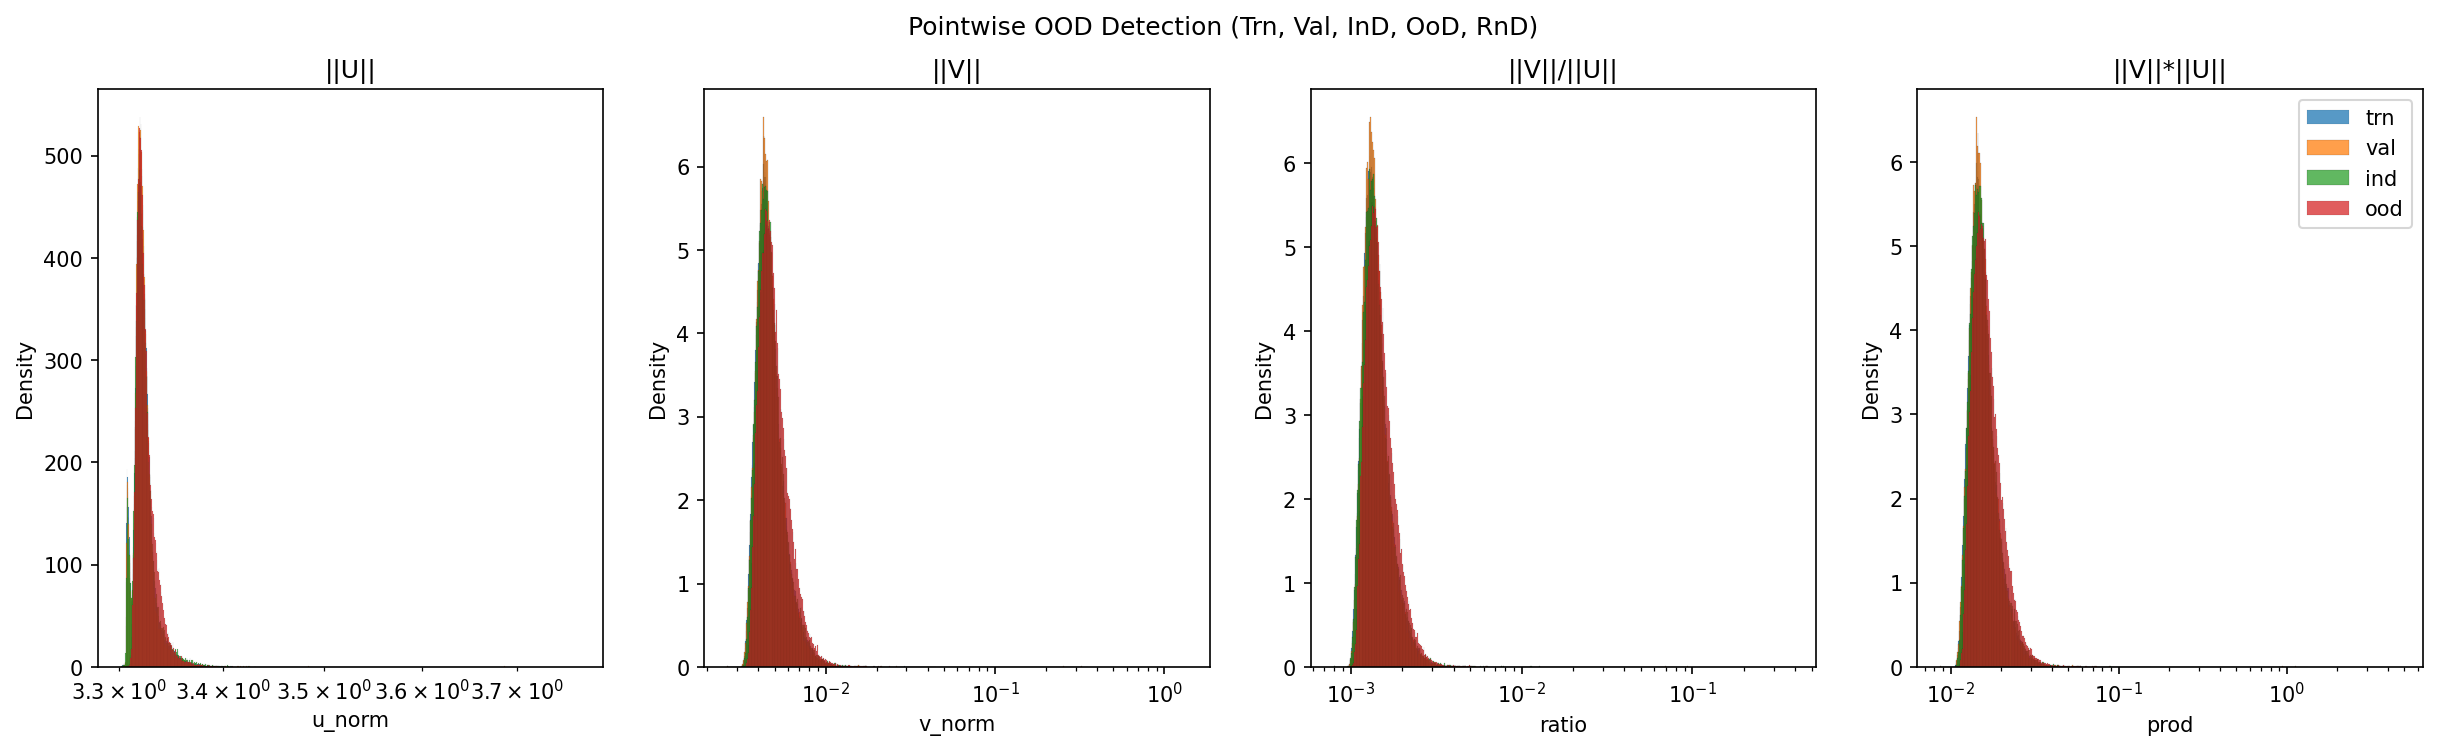

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 0.0026210467 0.35498115 0.3523601
Val 0.0026210467 0.32699162 0.32437056
Ind 0.0026210467 0.044570167 0.04194912
Ood 0.0026210467 1.3524563 1.3498353
Rnd 9.47544 12.335106 2.8596659
KstestResult(statistic=0.10716923378523241, pvalue=1.4055239111849826e-281, statistic_location=0.0047226055, statistic_sign=1)


[0 1 3 2 4]


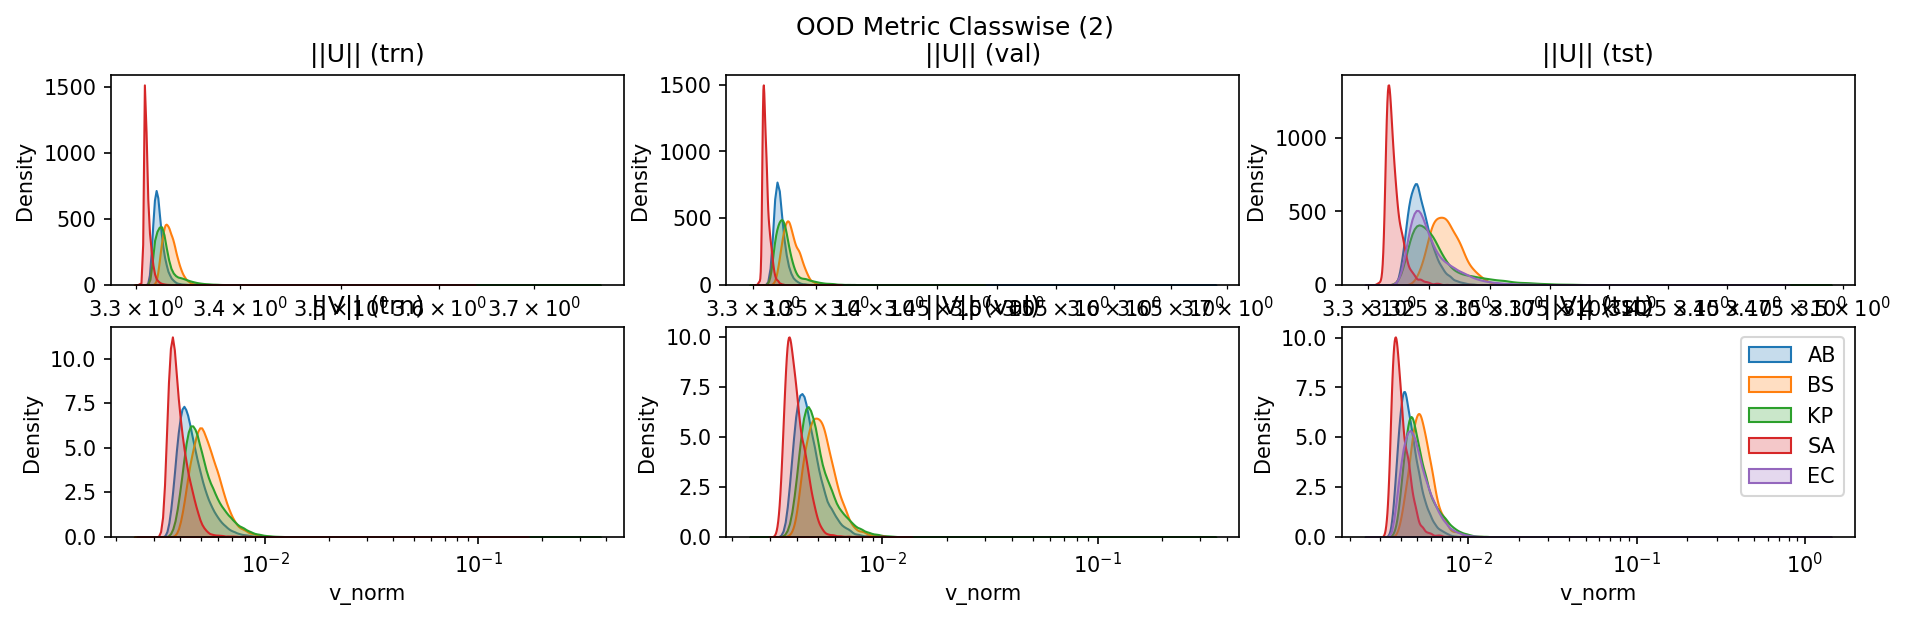

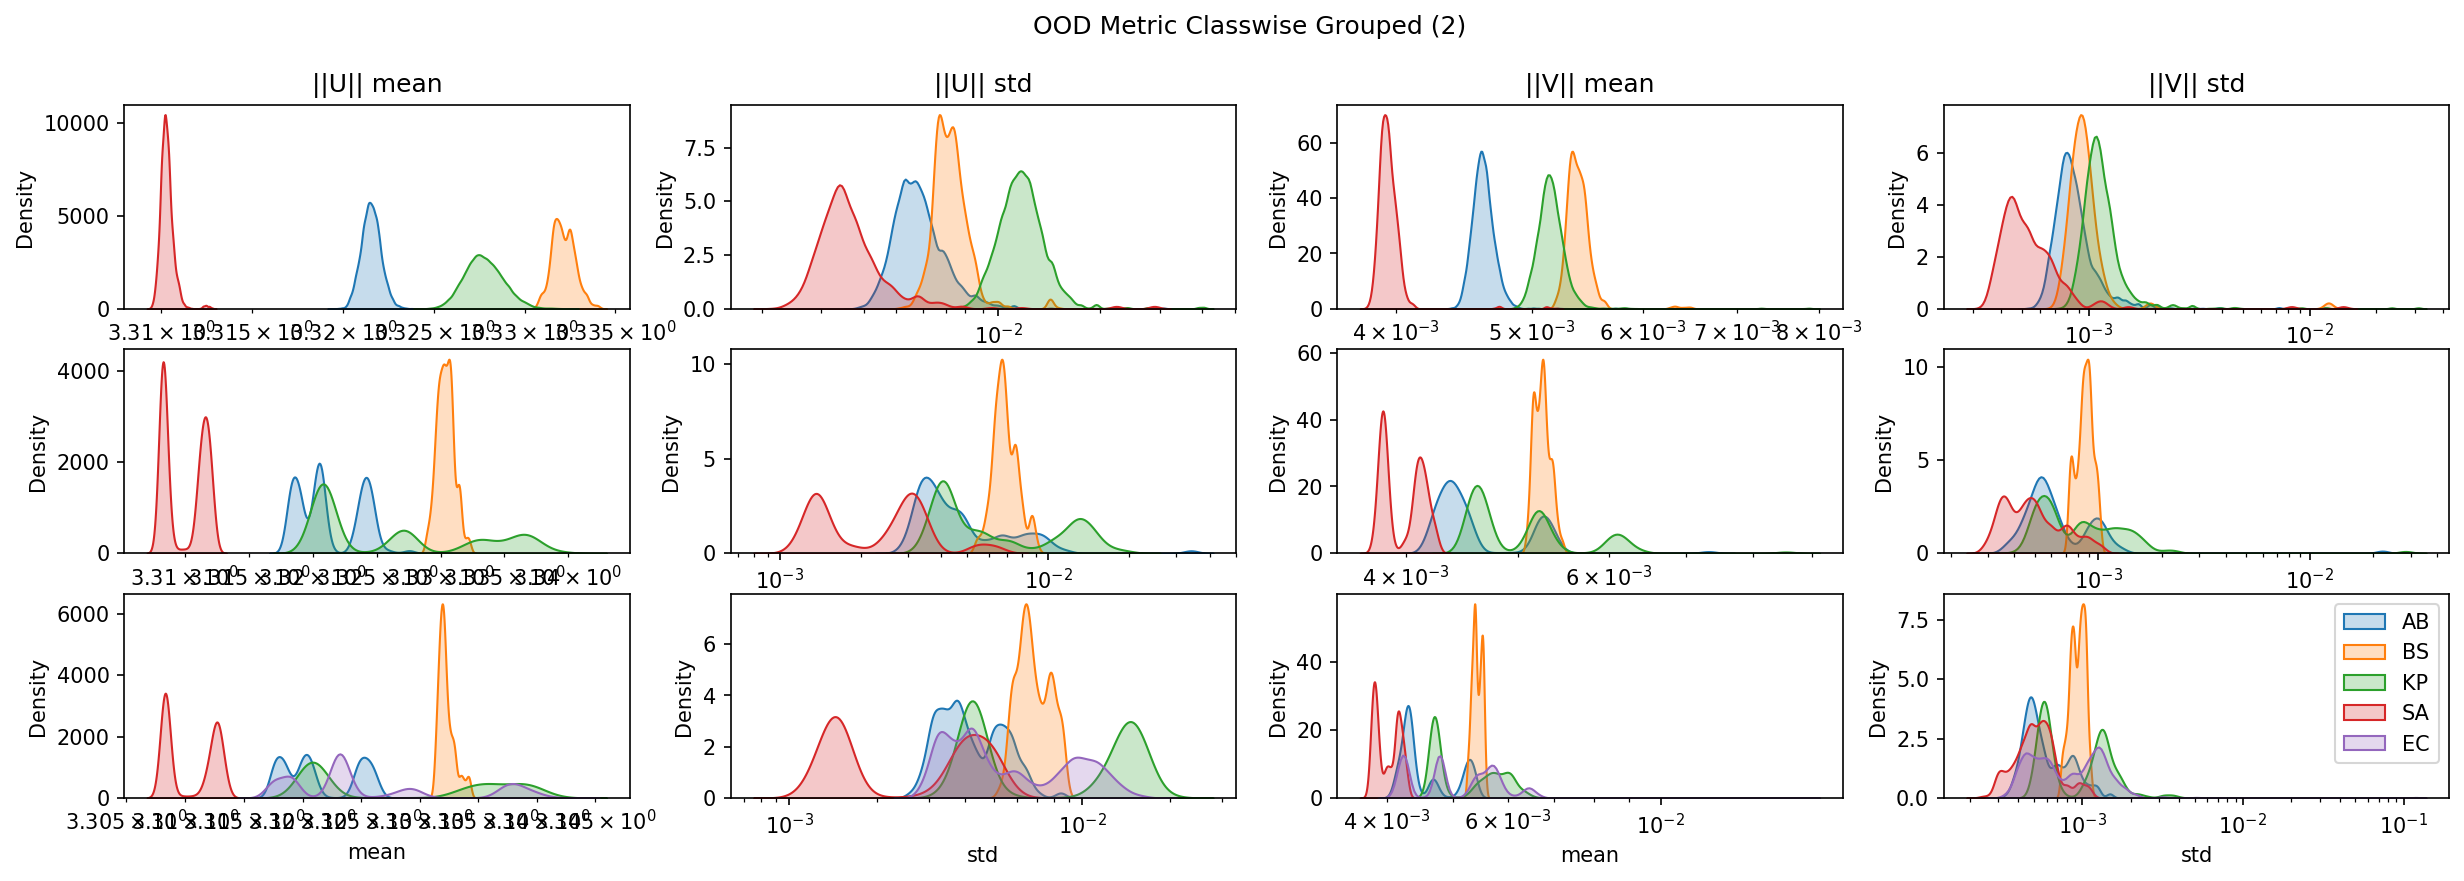

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)